# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


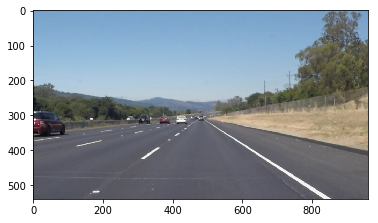

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [17]:
import math
from operator import itemgetter

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    left_lines=[]
    right_lines=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            line_det={}
            line_det['slope']=(y2-y1)/(x2-x1)
            line_det['d']=math.sqrt((y2-y1)**2+(x2-x1)**2)
            line_det['line']={}
            line_det['line']['x1']=x1
            line_det['line']['y1']=y1
            line_det['line']['x2']=x2
            line_det['line']['y2']=y2
            line_det['averagex']=(x2+x1)/2
            line_det['averagey']=(y2+y1)/2
            if (abs(line_det['slope'])<0.2) :
                continue
            if math.isinf(line_det['slope']):
                continue
            if line_det['averagex']<img.shape[1]/2 :
                left_lines.append(line_det)
                #cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
            else:
                right_lines.append(line_det)
            
    left_lines = sorted(left_lines, key=itemgetter('averagey')) 
    right_lines = sorted(right_lines, key=itemgetter('averagey')) 
    
    
    
    
            
    left_lines=filterLines(left_lines,2,"slope")
    mean_left =(sum(line1['slope']for line1 in left_lines)/len(left_lines))
    int_left =(sum((line1['averagey']-mean_left*line1['averagex'])for line1 in left_lines)/len(left_lines))
    #print(int_left)
    #print(image.shape[0]*mean_left+int_left)

    min_left_index=min(left_lines, key=lambda x:x['averagey'])
    #print(min_left_index)
    #print(mean_left)
    #print(left_lines)
    y1=int(image.shape[0])
    x1=int((image.shape[0]-int_left)/mean_left)
    y2=int(min_left_index['averagey'])
    x2=int((y2-int_left)/mean_left)
    cv2.line(img, (x1,y1), (x2,y2), color, thickness)


    right_lines=filterLines(right_lines,2,"slope")
    mean_right =(sum(line1['slope']for line1 in right_lines)/len(right_lines))
    int_right =(sum((line1['averagey']-mean_right*line1['averagex'])for line1 in right_lines)/len(right_lines))
    #print(int_right)
    #print(image.shape[0]*mean_right+int_right)

    min_right_index=min(right_lines, key=lambda x:x['averagey'])
    #print(min_right_index)
    #print(mean_right)
    #print(right_lines)
    y1=int(img.shape[0])
    x1=int((img.shape[0]-int_right)/mean_right)
    y2=int(min_right_index['averagey'])
    x2=int((y2-int_right)/mean_right)
    cv2.line(img, (x1,y1), (x2,y2), color, thickness)
def filterLines(list_lines,factor,attributeName):
    values=[line[attributeName] for line in list_lines]
    print (values)
    
    std=np.std(values)+0.0001
    median=np.median(values)
    print (std)
    print (median)
    print (factor)
    print([line for line in list_lines if abs(line[attributeName]-median)<factor*std])
    return [line for line in list_lines if abs(line[attributeName]-median)<factor*std]

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

6


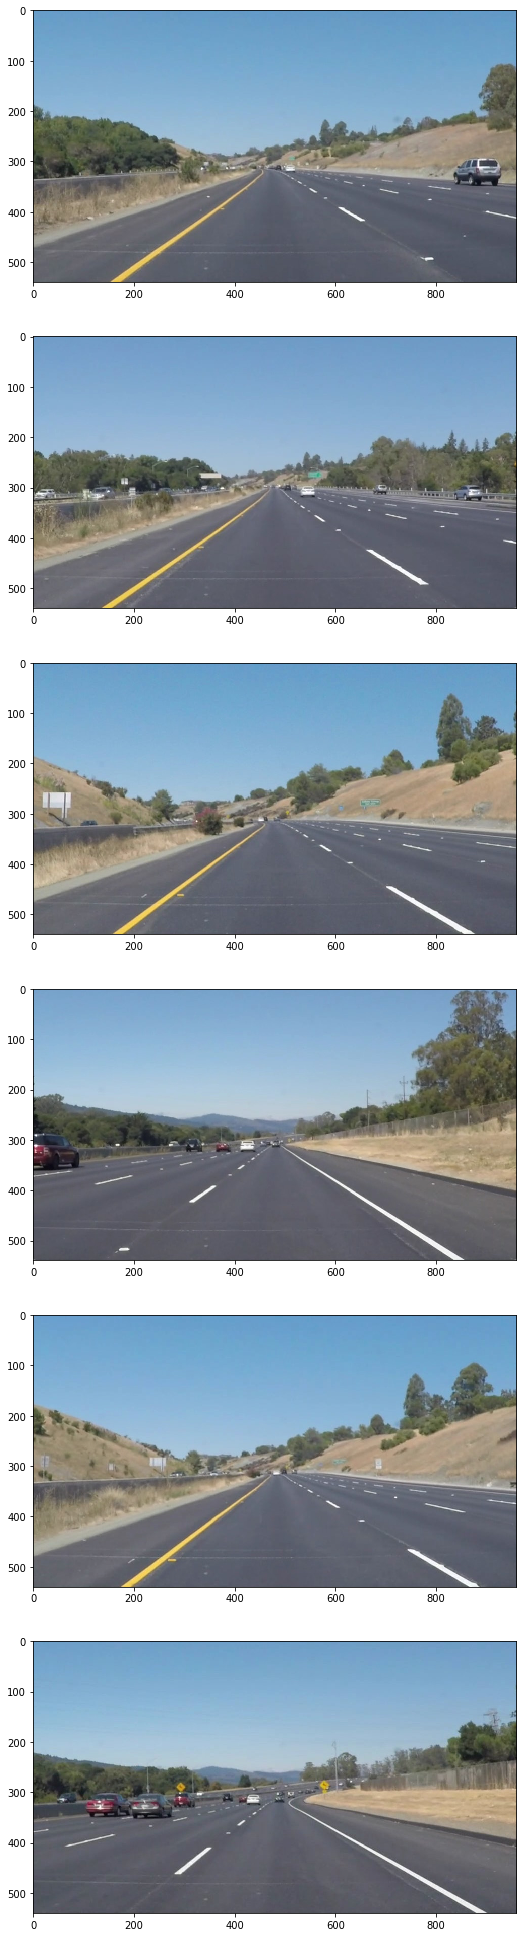

In [4]:
import os
print(len(os.listdir("test_images/")))
f, axarr = plt.subplots(len(os.listdir("test_images/")),figsize=[9,35])
for index, img in enumerate(os.listdir("test_images/")):
    image = mpimg.imread("test_images/"+img)
    axarr[index].imshow(image)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

6
solidYellowCurve.jpg
[-0.5476190476190477, -0.3191489361702128, 0.6170212765957447, -0.7708333333333334, -0.24242424242424243, -0.926829268292683, -0.7073170731707317, -0.37037037037037035, -0.3565217391304348, -0.34285714285714286, -0.7522123893805309, -0.7196969696969697, -0.7534246575342466, -0.7142857142857143, -0.7647058823529411, -0.6822429906542056, -0.7516339869281046, -0.7162162162162162, -0.7666666666666667, -0.6825396825396826]
0.32929817452913274
-0.7108013937282229
2
[{'line': {'y2': 323, 'y1': 294, 'x1': 451, 'x2': 498}, 'averagex': 474.5, 'slope': 0.6170212765957447, 'd': 55.226805085936306, 'averagey': 308.5}]
[0.7571428571428571, 0.5954198473282443, 0.5746268656716418, 0.6046511627906976, 0.6166666666666667, 0.6190476190476191, 0.5434782608695652, 0.5869565217391305, 0.6428571428571429, 0.5909090909090909]
0.05437750228227365
0.600035505059471
2
[{'line': {'y2': 344, 'y1': 291, 'x1': 459, 'x2': 529}, 'averagex': 494.0, 'slope': 0.7571428571428571, 'd': 87.80091115700

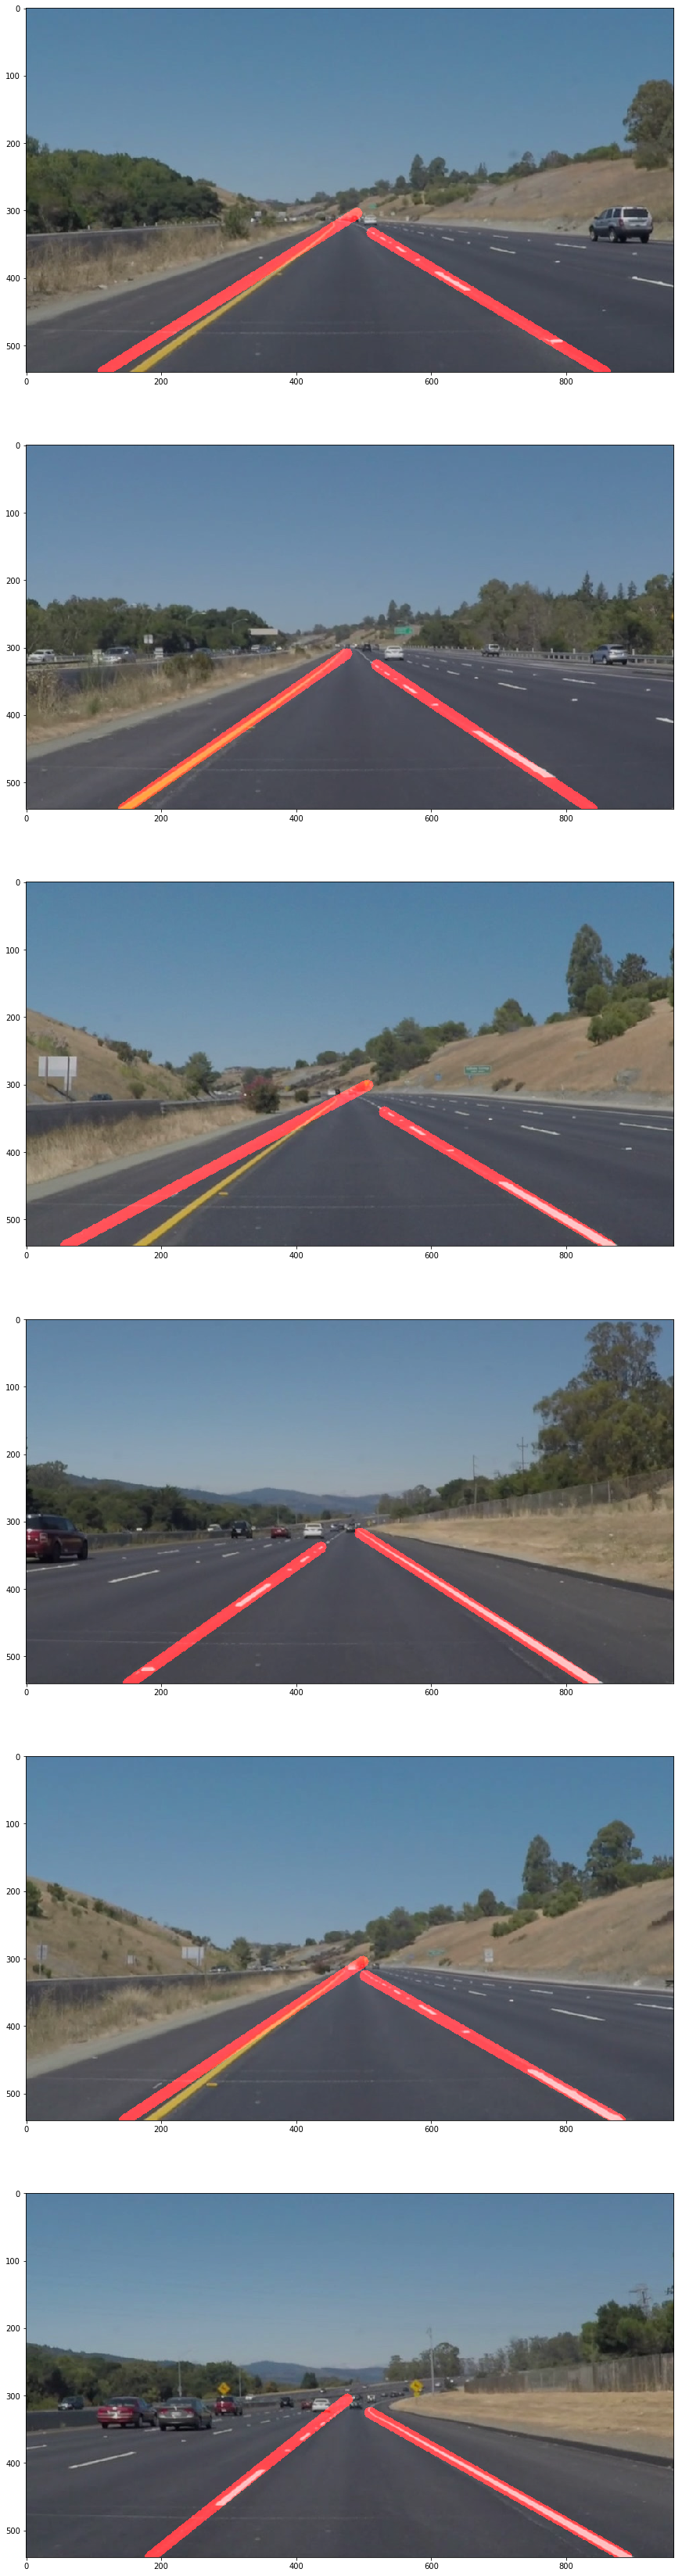

In [5]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    imshape = image.shape
    vertices=np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40#minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image

    line_image=hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

# Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
    lines_edges = weighted_img(line_image,image) 
    

    return lines_edges
print(len(os.listdir("test_images/")))
f, axarr = plt.subplots(len(os.listdir("test_images/")),figsize=[15,60])
for index, img in enumerate(os.listdir("test_images/")):
    image = mpimg.imread("test_images/"+img)
    print(img)
    image_output=process_image(image)
    axarr[index].imshow(image_output)
    mpimg.imsave("test_images_output/"+img,image_output)
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

['solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']
0.5947028721570544
0.5947028721570544
25.508456913771226
346.6480078785806
{'line': {'y2': 373, 'y1': 309, 'x1': 484, 'x2': 591}, 'averagex': 537.5, 'slope': 0.5981308411214953, 'd': 124.67958934805648, 'averagey': 341.0}
0.5947028721570544
[{'line': {'y2': 373, 'y1': 309, 'x1': 484, 'x2': 591}, 'averagex': 537.5, 'slope': 0.5981308411214953, 'd': 124.67958934805648, 'averagey': 341.0}, {'line': {'y2': 374, 'y1': 310, 'x1': 483, 'x2': 591}, 'averagex': 537.0, 'slope': 0.5925925925925926, 'd': 125.53883861180172, 'averagey': 342.0}, {'line': {'y2': 375, 'y1': 310, 'x1': 477, 'x2': 591}, 'averagex': 534.0, 'slope': 0.5701754385964912, 'd': 131.2288078129189, 'averagey': 342.5}, {'line': {'y2': 376, 'y1': 316, 'x1': 487, 'x2': 588}, 'averagex': 537.5, 'slope': 0.594059405940594, 'd': 117.47765745025733, 'averagey': 346.0}, {'line': {'y2': 497, 'y

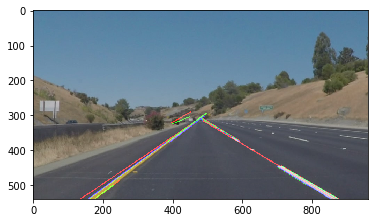

In [6]:
import math
print(os.listdir("test_images/"))
image = mpimg.imread("test_images/"+'solidYellowCurve2.jpg')
#image_output=process_image(image)
gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)

imshape = image.shape
vertices=np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40#minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
color=[255, 0, 0] 
thickness=2
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
line_img = np.zeros((masked_edges.shape[0], masked_edges.shape[1], 3), dtype=np.uint8)
left_lines=[]
right_lines=[]
for line in lines:
    for x1,y1,x2,y2 in line:
        line_det={}
        line_det['slope']=(y2-y1)/(x2-x1)
        line_det['d']=math.sqrt((y2-y1)**2+(x2-x1)**2)
        line_det['line']={}
        line_det['line']['x1']=x1
        line_det['line']['y1']=y1
        line_det['line']['x2']=x2
        line_det['line']['y2']=y2
        line_det['averagex']=(x2+x1)/2
        line_det['averagey']=(y2+y1)/2
        if (abs(line_det['slope'])<0.2) :
            continue
        if math.isinf(line_det['slope']):
            continue
            
        
        if line_det['slope']>0 :
            left_lines.append(line_det)
            #cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
        else:
            right_lines.append(line_det)
            
left_lines = sorted(left_lines, key=itemgetter('averagey')) 
right_lines = sorted(right_lines, key=itemgetter('averagey')) 
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = weighted_img(line_img,image) 
        
#print(left_lines)

mean_left =(sum(line1['slope']for line1 in left_lines)/len(left_lines))
print(mean_left)
left_lines=[line1 for line1 in left_lines if abs(line1['slope']-mean_left)<0.3]
mean_left =(sum(line1['slope']for line1 in left_lines)/len(left_lines))
print(mean_left)
left_lines=[line1 for line1 in left_lines if abs(line1['slope']-mean_left)<0.2]
mean_left =(sum(line1['slope']for line1 in left_lines)/len(left_lines))
int_left =(sum((line1['averagey']-mean_left*line1['averagex'])for line1 in left_lines)/len(left_lines))
print(int_left)
print(image.shape[0]*mean_left+int_left)

min_left_index=min(left_lines, key=lambda x:x['averagey'])
print(min_left_index)
print(mean_left)
print(left_lines)
y1=int(image.shape[0])
x1=int((image.shape[0]-int_left)/mean_left)

y2=int(min_left_index['averagey'])
x2=int((y2-int_left)/mean_left)
cv2.line(line_img, (x1,y1), (x2,y2), color, thickness)
    
    
mean_right =(sum(line1['slope']for line1 in right_lines)/len(right_lines))
print(mean_right)
right_lines=[line1 for line1 in right_lines if abs(line1['slope']-mean_right)<0.3]
mean_right =(sum(line1['slope']for line1 in right_lines)/len(right_lines))
print(mean_right)
right_lines=[line1 for line1 in right_lines if abs(line1['slope']-mean_right)<0.2]
mean_right =(sum(line1['slope']for line1 in right_lines)/len(right_lines))
int_right =(sum((line1['averagey']-mean_right*line1['averagex'])for line1 in right_lines)/len(right_lines))
print(int_right)
print(image.shape[0]*mean_right+int_right)

min_right_index=min(right_lines, key=lambda x:x['averagey'])
print(min_right_index)
print(mean_right)
print(right_lines)
y1=int(image.shape[0])
x1=int((image.shape[0]-int_right)/mean_right)

y2=int(min_right_index['averagey'])
x2=int((y2-int_right)/mean_right)
cv2.line(line_img, (x1,y1), (x2,y2), color, thickness)

#f, axarr = plt.subplots(len(right_lines)+1,figsize=[15,200])
for index, line_det in enumerate(left_lines):
    color=[0,0,0]
    color[index%3]=255-index
    line_img1 = np.zeros((masked_edges.shape[0], masked_edges.shape[1], 3), dtype=np.uint8)
    cv2.line(line_img, (line_det['line']['x1'], line_det['line']['y1']), (line_det['line']['x2'], line_det['line']['y2']), color, thickness)
    #cv2.line(line_img, (line_det['line']['x1'], line_det['line']['y1']), (line_det['line']['x2'], line_det['line']['y2']), color, thickness)
    #axarr[index].imshow(line_img1)
#axarr[len(right_lines)].imshow(line_img)
for index, line_det in enumerate(right_lines):
    color=[0,0,0]
    color[index%3]=255-index
    line_img1 = np.zeros((masked_edges.shape[0], masked_edges.shape[1], 3), dtype=np.uint8)
    cv2.line(line_img, (line_det['line']['x1'], line_det['line']['y1']), (line_det['line']['x2'], line_det['line']['y2']), color, thickness)
    #cv2.line(line_img, (line_det['line']['x1'], line_det['line']['y1']), (line_det['line']['x2'], line_det['line']['y2']), color, thickness)
    #axarr[index].imshow(line_img1)
#axarr[len(right_lines)].imshow(line_img)
# Run Hough on edge detected image
lines_edges = weighted_img(line_img,image) 
plt.imshow(lines_edges)


In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    imshape = image.shape
    vertices=np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40#minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image

    line_image=hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

# Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
    lines_edges = weighted_img(line_image,image) 
    

    return lines_edges

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[-0.20930232558139536, -0.23728813559322035, -0.7333333333333333, -0.723404255319149, -0.7263157894736842, -0.7529411764705882, -0.7254901960784313, -0.7333333333333333, -0.7304347826086957, -0.7272727272727273, -0.7256637168141593, -0.7570093457943925, -0.7560975609756098]
0.18526939059675254
-0.7272727272727273
2
[{'line': {'y2': 319, 'y1': 328, 'x1': 382, 'x2': 425}, 'averagex': 403.5, 'slope': -0.20930232558139536, 'd': 43.93176527297759, 'averagey': 323.5}, {'line': {'y2': 317, 'y1': 331, 'x1': 376, 'x2': 435}, 'averagex': 405.5, 'slope': -0.23728813559322035, 'd': 60.63827174318213, 'averagey': 324.0}]
[0.20430107526881722, 0.6046511627906976, 0.6255924170616114, 0.6266094420600858, 0.6004901960784313, 0.6170212765957447, 0.6047904191616766, 0.625, 0.6288659793814433]
0.12998582183309015
0.6170212765957447
2
[{'line': {'y2': 315, 'y1': 296, 'x1': 443, 'x2': 536}, 'averagex': 489.5, 'slope': 0.20430107526881722, 'd': 94.92101980067429, 'averagey': 305.5}]
[MoviePy] >>>> Building v

  4%|▍         | 9/222 [00:00<00:02, 88.35it/s]

[-0.20930232558139536, -0.23728813559322035, -0.7333333333333333, -0.723404255319149, -0.7263157894736842, -0.7529411764705882, -0.7254901960784313, -0.7333333333333333, -0.7304347826086957, -0.7272727272727273, -0.7256637168141593, -0.7570093457943925, -0.7560975609756098]
0.18526939059675254
-0.7272727272727273
2
[{'line': {'y2': 319, 'y1': 328, 'x1': 382, 'x2': 425}, 'averagex': 403.5, 'slope': -0.20930232558139536, 'd': 43.93176527297759, 'averagey': 323.5}, {'line': {'y2': 317, 'y1': 331, 'x1': 376, 'x2': 435}, 'averagex': 405.5, 'slope': -0.23728813559322035, 'd': 60.63827174318213, 'averagey': 324.0}]
[0.20430107526881722, 0.6046511627906976, 0.6255924170616114, 0.6266094420600858, 0.6004901960784313, 0.6170212765957447, 0.6047904191616766, 0.625, 0.6288659793814433]
0.12998582183309015
0.6170212765957447
2
[{'line': {'y2': 315, 'y1': 296, 'x1': 443, 'x2': 536}, 'averagex': 489.5, 'slope': 0.20430107526881722, 'd': 94.92101980067429, 'averagey': 305.5}]
[-0.23728813559322035, -0

[-0.23255813953488372, -0.6741573033707865, -0.8382352941176471, -0.673469387755102, -0.6739130434782609, -0.7058823529411765, -0.7818181818181819]
0.1819601462999649
-0.6741573033707865
2
[{'line': {'y2': 310, 'y1': 320, 'x1': 408, 'x2': 451}, 'averagex': 429.5, 'slope': -0.23255813953488372, 'd': 44.14748010928823, 'averagey': 315.0}]
[0.6285714285714286, 0.6309523809523809, 0.668918918918919, 0.6260387811634349, 0.625748502994012, 0.6698564593301436, 0.6714285714285714]
0.02097531022411556
0.6309523809523809
2
[]


  9%|▊         | 19/222 [00:00<00:02, 91.48it/s]

[-0.7450980392156863, -0.6777777777777778, -0.6777777777777778, -0.7, -0.6962025316455697]
0.024633032455500543
-0.6962025316455697
2
[]
[0.6226415094339622, 0.25, 0.6527196652719666, 0.6240409207161125, 0.6379310344827587, 0.624633431085044, 0.6549707602339181, 0.6486486486486487, 0.6296296296296297]
0.12217857854878388
0.6296296296296297
2
[{'line': {'y2': 317, 'y1': 307, 'x1': 501, 'x2': 541}, 'averagex': 521.0, 'slope': 0.25, 'd': 41.23105625617661, 'averagey': 312.0}]


 12%|█▏        | 27/222 [00:00<00:02, 86.93it/s]

[-0.5, -0.7843137254901961, -0.7252747252747253, -0.75, -0.7560975609756098, -0.7142857142857143, -0.675]
0.0880098232118206
-0.7252747252747253
2
[{'line': {'y2': 294, 'y1': 328, 'x1': 385, 'x2': 453}, 'averagex': 419.0, 'slope': -0.5, 'd': 76.02631123499285, 'averagey': 311.0}]
[0.24074074074074073, 0.6739130434782609, 0.6507936507936508, 0.6496350364963503, 0.6240409207161125, 0.6263736263736264, 0.6379310344827587, 0.6530612244897959, 0.6530612244897959]
0.12819565558363744
0.6496350364963503
2
[{'line': {'y2': 317, 'y1': 304, 'x1': 485, 'x2': 539}, 'averagex': 512.0, 'slope': 0.24074074074074073, 'd': 55.54277630799526, 'averagey': 310.5}]
[-0.20689655172413793, 0.25, -0.4027777777777778, -0.2375, -0.7205882352941176, -0.7263157894736842, -0.7303370786516854, -0.6767676767676768, -0.6976744186046512, -0.6122448979591837, -0.7045454545454546, -0.6888888888888889]
0.29413005104449663
-0.6828282828282828
2
[{'line': {'y2': 305, 'y1': 295, 'x1': 452, 'x2': 492}, 'averagex': 472.0, 'sl

[-0.21568627450980393, -0.5522388059701493, -0.717391304347826, -0.7216494845360825, -0.7241379310344828, -0.7446808510638298, -0.6888888888888889, -0.717391304347826, -0.7560975609756098]
0.1631689146240828
-0.717391304347826
2
[{'line': {'y2': 301, 'y1': 312, 'x1': 412, 'x2': 463}, 'averagex': 437.5, 'slope': -0.21568627450980393, 'd': 52.172789842982326, 'averagey': 306.5}]
[0.6025641025641025, 0.6582278481012658, 0.6190476190476191, 0.6504297994269341, 0.6244343891402715, 0.6509090909090909, 0.6201923076923077, 0.6206896551724138]
0.018481875793725015
0.6225620221563426
2
[]
[-0.3076923076923077, -0.2235294117647059, -0.7073170731707317, -0.8048780487804879, -0.75, -0.7216494845360825, -0.6727272727272727, -0.6538461538461539, -0.6727272727272727, -0.75, -0.72]
0.17962376068595134
-0.7073170731707317
2
[{'line': {'y2': 302, 'y1': 318, 'x1': 414, 'x2': 466}, 'averagex': 440.0, 'slope': -0.3076923076923077, 'd': 54.405882034941776, 'averagey': 310.0}, {'line': {'y2': 304, 'y1': 323, 

 19%|█▉        | 42/222 [00:00<00:02, 77.58it/s]

[-0.23214285714285715, -0.5869565217391305, -0.68, -0.725, -0.6724137931034483, -0.75, -0.7796610169491526, -0.696969696969697, -0.71875, -0.6818181818181818]
0.14842752939990903
-0.6893939393939394
2
[{'line': {'y2': 290, 'y1': 303, 'x1': 426, 'x2': 482}, 'averagex': 454.0, 'slope': -0.23214285714285715, 'd': 57.48912940721924, 'averagey': 296.5}]
[-0.21153846153846154, 0.23255813953488372, 0.5774647887323944, 0.6538461538461539, 0.5113636363636364, 0.6136363636363636, 0.624390243902439, 0.6265432098765432, 0.6515679442508711, 0.65234375, 0.624113475177305]
0.25464906452656505
0.624113475177305
2
[{'line': {'y2': 305, 'y1': 316, 'x1': 467, 'x2': 519}, 'averagex': 493.0, 'slope': -0.21153846153846154, 'd': 53.150729063673246, 'averagey': 310.5}]
[-0.6981132075471698, -0.7215189873417721, -0.75, -0.7272727272727273, -0.7142857142857143, -0.75, -0.7818181818181819, -0.75, -0.6987951807228916, -0.7564102564102564, -0.71875]
0.02504865548826394
-0.7272727272727273
2
[{'line': {'y2': 340, '

[-0.7058823529411765, -0.6714285714285714, -0.6695652173913044, -0.693069306930693, -0.7121212121212122, -0.7258064516129032]
0.02064193133236227
-0.6994758299359347
2
[]
[0.6851851851851852, 0.6470588235294118, 0.6595744680851063, 0.6717325227963525, 0.673469387755102, 0.6449704142011834, 0.6422018348623854, 0.6739130434782609, 0.6436781609195402]
0.015359795833197921
0.6595744680851063
2
[]
[-0.7804878048780488, -0.7021276595744681, -0.7045454545454546, -0.6756756756756757, -0.6736842105263158, -0.6736842105263158, -0.7532467532467533, -0.6792452830188679]
0.03794450612184454
-0.690686471296668
2
[{'line': {'y2': 290, 'y1': 322, 'x1': 436, 'x2': 477}, 'averagex': 456.5, 'slope': -0.7804878048780488, 'd': 52.009614495783374, 'averagey': 306.0}]
[0.6666666666666666, 0.6746987951807228, 0.6476190476190476, 0.66, 0.6746575342465754, 0.645320197044335, 0.6747404844290658, 0.65, 0.6415094339622641, 0.6736842105263158, 0.6506024096385542, 0.65]
0.012482295898189104
0.6553012048192771
2
[]


 25%|██▌       | 56/222 [00:00<00:02, 68.57it/s]

[-0.7017543859649122, -0.7010309278350515, -0.6739130434782609, -0.6764705882352942, -0.7014925373134329, -0.7073170731707317, -0.7166666666666667, -0.6981132075471698, -0.7047619047619048, -0.7272727272727273, -0.6984126984126984]
0.014584190807166343
-0.7014925373134329
2
[]
[-0.23809523809523808, -0.2127659574468085, 0.6707317073170732, 0.6309523809523809, 0.6298701298701299, 0.6716417910447762, 0.6263736263736264, 0.6292134831460674, 0.6692913385826772]
0.36315131590002125
0.6298701298701299
2
[{'line': {'y2': 300, 'y1': 310, 'x1': 464, 'x2': 506}, 'averagex': 485.0, 'slope': -0.23809523809523808, 'd': 43.174066289845804, 'averagey': 305.0}, {'line': {'y2': 301, 'y1': 311, 'x1': 464, 'x2': 511}, 'averagex': 487.5, 'slope': -0.2127659574468085, 'd': 48.05205510693585, 'averagey': 306.0}]
[-0.7, -0.75, -0.6990291262135923, -0.6736842105263158, -0.6767676767676768, -0.7021276595744681, -0.6971830985915493, -0.7307692307692307]
0.023935277408736393
-0.699514563106796
2
[{'line': {'y2':

[-0.6494845360824743, -0.6216216216216216, -0.6272727272727273, -0.647887323943662, -0.7045454545454546, -0.6737588652482269, -0.6739130434782609, -0.703125, -0.7068965517241379]
0.031102082744414578
-0.6737588652482269
2
[]
[0.6904761904761905, 0.6455696202531646, 0.6590909090909091, 0.6612903225806451, 0.673972602739726, 0.6729323308270677, 0.6473214285714286, 0.647887323943662]
0.014859750587981144
0.6601906158357771
2
[{'line': {'y2': 345, 'y1': 316, 'x1': 492, 'x2': 534}, 'averagex': 513.0, 'slope': 0.6904761904761905, 'd': 51.03920062069938, 'averagey': 330.5}]


 32%|███▏      | 71/222 [00:00<00:02, 68.33it/s]

[-0.21153846153846154, -0.4473684210526316, -0.2261904761904762, -0.2127659574468085, -0.6972477064220184, -0.6730769230769231, -0.67, -0.7171717171717171, -0.6470588235294118, -0.7413793103448276, -0.6513761467889908, -0.7326732673267327, -0.7205882352941176, -0.6538461538461539]
0.19746533243614847
-0.661923076923077
2
[{'line': {'y2': 291, 'y1': 302, 'x1': 428, 'x2': 480}, 'averagex': 454.0, 'slope': -0.21153846153846154, 'd': 53.150729063673246, 'averagey': 296.5}, {'line': {'y2': 306, 'y1': 325, 'x1': 437, 'x2': 521}, 'averagex': 479.0, 'slope': -0.2261904761904762, 'd': 86.12200647918046, 'averagey': 315.5}, {'line': {'y2': 307, 'y1': 327, 'x1': 393, 'x2': 487}, 'averagex': 440.0, 'slope': -0.2127659574468085, 'd': 96.1041102138717, 'averagey': 317.0}]
[0.2, 0.6732673267326733, 0.6441717791411042, 0.6595744680851063, 0.6730769230769231, 0.673469387755102, 0.6727941176470589, 0.6456310679611651, 0.6485148514851485]
0.145461409409009
0.6595744680851063
2
[{'line': {'y2': 319, 'y1':

[-0.5636363636363636, -0.23809523809523808, -0.7, -0.21428571428571427, -0.6491228070175439, -0.6796116504854369, -0.6829268292682927, -0.6770833333333334, -0.6582278481012658, -0.660377358490566, -0.6914893617021277, -0.65, -0.697841726618705, -0.6379310344827587, -0.6382978723404256]
0.15120104248157445
-0.6582278481012658
2
[{'line': {'y2': 304, 'y1': 314, 'x1': 411, 'x2': 453}, 'averagex': 432.0, 'slope': -0.23809523809523808, 'd': 43.174066289845804, 'averagey': 309.0}, {'line': {'y2': 317, 'y1': 326, 'x1': 392, 'x2': 434}, 'averagex': 413.0, 'slope': -0.21428571428571427, 'd': 42.95346318982906, 'averagey': 321.5}]
[0.2698412698412698, 0.6206896551724138, 0.6496815286624203, 0.6747404844290658, 0.6758241758241759, 0.648936170212766, 0.6473684210526316, 0.6666666666666666]
0.1284320824654796
0.6493088494375931
2
[{'line': {'y2': 318, 'y1': 301, 'x1': 480, 'x2': 543}, 'averagex': 511.5, 'slope': 0.2698412698412698, 'd': 65.25335240430181, 'averagey': 309.5}]
[-0.675, -0.75, -0.5833

 38%|███▊      | 85/222 [00:01<00:02, 67.55it/s]

[-0.75, -0.6346153846153846, -0.6774193548387096, -0.7011494252873564, -0.5972222222222222, -0.671875, -0.6]
0.051271832054132466
-0.671875
2
[]
[0.6507936507936508, 0.676056338028169, 0.6762589928057554, 0.6785714285714286, 0.6509433962264151, 0.6523076923076923, 0.6484641638225256, 0.6764705882352942, 0.6797385620915033]
0.013389763073980071
0.676056338028169
2
[{'line': {'y2': 530, 'y1': 340, 'x1': 533, 'x2': 826}, 'averagex': 679.5, 'slope': 0.6484641638225256, 'd': 349.21197001248396, 'averagey': 435.0}]
[-0.4583333333333333, -0.6704545454545454, -0.71, -0.696969696969697, -0.7022900763358778, -0.6956521739130435, -0.6666666666666666]
0.08254384563316265
-0.6956521739130435
2
[{'line': {'y2': 304, 'y1': 326, 'x1': 387, 'x2': 435}, 'averagex': 411.0, 'slope': -0.4583333333333333, 'd': 52.80151512977634, 'averagey': 315.0}]
[0.625, 0.625, 0.75, 0.6753246753246753, 0.6666666666666666, 0.6666666666666666, 0.6489028213166145, 0.6494845360824743, 0.6763285024154589, 0.68]
0.033723066570

 41%|████▏     | 92/222 [00:01<00:02, 62.11it/s]

[-0.8048780487804879, -0.5, -0.5, -0.6349206349206349, -0.6304347826086957, -0.6451612903225806, -0.6538461538461539, -0.6722689075630253, -0.7244094488188977]
0.09121571718997983
-0.6451612903225806
2
[]
[0.6491228070175439, 0.7222222222222222, 0.71875, 0.6739130434782609, 0.6729559748427673, 0.72, 0.6741573033707865, 0.7184466019417476, 0.6695652173913044, 0.7391304347826086, 0.6829268292682927]
0.02810443865283616
0.6829268292682927
2
[]
[-0.46511627906976744, -0.3076923076923077, -0.6933333333333334, -0.6476190476190476, -0.6210526315789474, -0.6226415094339622, -0.7469879518072289]
0.13932128964044424
-0.6226415094339622
2
[{'line': {'y2': 300, 'y1': 324, 'x1': 431, 'x2': 509}, 'averagex': 470.0, 'slope': -0.3076923076923077, 'd': 81.60882305241266, 'averagey': 312.0}]
[0.671875, 0.6341463414634146, 0.722972972972973, 0.7268292682926829, 0.6739130434782609, 0.6744186046511628, 0.7207207207207207, 0.6717171717171717, 0.7166666666666667, 0.6835443037974683, 0.6851851851851852, 0.68]

 45%|████▍     | 99/222 [00:01<00:02, 60.70it/s]

[-0.2857142857142857, -0.65, -0.6486486486486487, -0.6785714285714286, -0.6491228070175439, -0.625, -0.6941176470588235, -0.6296296296296297, -0.6962025316455697]
0.11977092629196762
-0.6491228070175439
2
[{'line': {'y2': 302, 'y1': 318, 'x1': 400, 'x2': 456}, 'averagex': 428.0, 'slope': -0.2857142857142857, 'd': 58.240879114244144, 'averagey': 310.0}]
[0.72, 0.68, 0.6944444444444444, 0.6808510638297872, 0.7260869565217392, 0.6769911504424779, 0.7247706422018348, 0.6754385964912281, 0.674074074074074]
0.021206504732192072
0.6808510638297872
2
[{'line': {'y2': 469, 'y1': 302, 'x1': 484, 'x2': 714}, 'averagex': 599.0, 'slope': 0.7260869565217392, 'd': 284.2340584799788, 'averagey': 385.5}, {'line': {'y2': 539, 'y1': 381, 'x1': 594, 'x2': 812}, 'averagex': 703.0, 'slope': 0.7247706422018348, 'd': 269.23595599399425, 'averagey': 460.0}]
[-0.4, -0.65, -0.6722689075630253, -0.6949152542372882, -0.6896551724137931, -0.7017543859649122, -0.6571428571428571, -0.6458333333333334, -0.648936170212

 48%|████▊     | 106/222 [00:01<00:01, 60.78it/s]

[-0.4788732394366197, 0.2127659574468085, -0.5111111111111111, -0.6447368421052632, -0.696969696969697, -0.6267605633802817, -0.7796610169491526, -0.75, -0.6296296296296297]
0.28357057415435516
-0.6296296296296297
2
[{'line': {'y2': 315, 'y1': 305, 'x1': 424, 'x2': 471}, 'averagex': 447.5, 'slope': 0.2127659574468085, 'd': 48.05205510693585, 'averagey': 310.0}]
[-0.21951219512195122, 0.5873015873015873, 0.65625, 0.65, 0.7232142857142857, 0.7062937062937062, 0.6774193548387096, 0.6758893280632411, 0.6862745098039216, 0.7043478260869566, 0.7021276595744681]
0.26010304943415435
0.6774193548387096
2
[{'line': {'y2': 298, 'y1': 307, 'x1': 465, 'x2': 506}, 'averagex': 485.5, 'slope': -0.21951219512195122, 'd': 41.97618372363071, 'averagey': 302.5}]
[-0.6481481481481481, -0.625, -0.6746987951807228, -0.6705882352941176, -0.6293103448275862]
0.02044201834182458
-0.6481481481481481
2
[]
[0.631578947368421, 0.7017543859649122, 0.7004608294930875, 0.6746031746031746, 0.6754385964912281, 0.6740740

 51%|█████     | 113/222 [00:01<00:01, 62.74it/s]

[-0.6428571428571429, -0.2602739726027397, -0.671875, -0.6724137931034483, -0.6517857142857143, -0.6752136752136753, -0.6513761467889908, -0.65, -0.6716417910447762, -0.6555555555555556, -0.6835443037974683, -0.6730769230769231]
0.11213854782128074
-0.6635986733001659
2
[{'line': {'y2': 305, 'y1': 324, 'x1': 432, 'x2': 505}, 'averagex': 468.5, 'slope': -0.2602739726027397, 'd': 75.43208866258443, 'averagey': 314.5}]
[0.6904761904761905, 0.675, 0.6694915254237288, 0.7735849056603774, 0.711864406779661, 0.7016129032258065, 0.6706827309236948, 0.6851851851851852, 0.6835443037974683, 0.6745098039215687, 0.6781609195402298, 0.6826923076923077, 0.6707317073170732, 0.6666666666666666]
0.026705910520650463
0.6804266136162688
2
[{'line': {'y2': 351, 'y1': 310, 'x1': 497, 'x2': 550}, 'averagex': 523.5, 'slope': 0.7735849056603774, 'd': 67.00746227100382, 'averagey': 330.5}]
[-0.5, -0.8, -0.7560975609756098, -0.6153846153846154, 0.22388059701492538, -0.34, -0.6721311475409836, -0.7012987012987013

 54%|█████▍    | 120/222 [00:01<00:01, 62.91it/s]

[-0.6190476190476191, -0.7804878048780488, -0.7619047619047619, -0.6813186813186813, -0.6774193548387096, -0.651685393258427, -0.6739130434782609, -0.6973684210526315, -0.7222222222222222, -0.7222222222222222]
0.04660113681982854
-0.6893435511856565
2
[]
[0.676056338028169, 0.6504854368932039, 0.6736842105263158, 0.6501650165016502, 0.6822429906542056, 0.6524822695035462, 0.6813186813186813, 0.6518518518518519, 0.6813186813186813, 0.648936170212766, 0.6818181818181818]
0.014483044707671873
0.6736842105263158
2
[]
[0.2, -0.28378378378378377, -0.34146341463414637, -0.6767676767676768, -0.6526315789473685, -0.673469387755102, -0.703125, -0.7291666666666666, -0.6829268292682927, -0.7045454545454546]
0.2845086809598725
-0.6751185322613894
2
[{'line': {'y2': 313, 'y1': 300, 'x1': 433, 'x2': 498}, 'averagex': 465.5, 'slope': 0.2, 'd': 66.2872536767062, 'averagey': 306.5}]
[0.6666666666666666, 0.6753731343283582, 0.673469387755102, 0.6474820143884892, 0.6517571884984026, 0.6666666666666666, 0.

 57%|█████▋    | 127/222 [00:01<00:01, 62.61it/s]

[-0.2602739726027397, -0.6842105263157895, -0.6698113207547169, -0.703125, -0.647887323943662]
0.16737148107049094
-0.6698113207547169
2
[{'line': {'y2': 306, 'y1': 325, 'x1': 428, 'x2': 501}, 'averagex': 464.5, 'slope': -0.2602739726027397, 'd': 75.43208866258443, 'averagey': 315.5}]
[0.6292134831460674, 0.6595744680851063, 0.6351351351351351, 0.6254180602006689, 0.6666666666666666, 0.6246056782334385, 0.6746411483253588, 0.6309523809523809, 0.6888888888888889]
0.02292329573802224
0.6351351351351351
2
[{'line': {'y2': 538, 'y1': 507, 'x1': 788, 'x2': 833}, 'averagex': 810.5, 'slope': 0.6888888888888889, 'd': 54.644304369257, 'averagey': 522.5}]
[-0.22950819672131148, -0.2682926829268293, -0.6739130434782609, -0.6222222222222222, -0.7066666666666667, -0.7028985507246377, -0.6764705882352942, -0.6444444444444445]
0.1849143532456777
-0.6591787439613527
2
[{'line': {'y2': 306, 'y1': 320, 'x1': 396, 'x2': 457}, 'averagex': 426.5, 'slope': -0.22950819672131148, 'd': 62.5859409132754, 'avera

 60%|██████    | 134/222 [00:01<00:01, 63.09it/s]

[-0.3037974683544304, -0.6767676767676768, -0.7032967032967034, -0.673469387755102, -0.6966292134831461, -0.6222222222222222, -0.7073170731707317, -0.7]
0.12796417900676224
-0.6866984451254114
2
[{'line': {'y2': 301, 'y1': 325, 'x1': 432, 'x2': 511}, 'averagex': 471.5, 'slope': -0.3037974683544304, 'd': 82.56512580987206, 'averagey': 313.0}]
[0.5106382978723404, 0.6263736263736264, 0.6503496503496503, 0.6246851385390428, 0.6517241379310345, 0.6217228464419475, 0.6578947368421053]
0.04688499120198325
0.6263736263736264
2
[{'line': {'y2': 340, 'y1': 292, 'x1': 447, 'x2': 541}, 'averagex': 494.0, 'slope': 0.5106382978723404, 'd': 105.54619841567009, 'averagey': 316.0}]
[-0.8, -0.6986301369863014, -0.6761904761904762, -0.7029702970297029, -0.7032967032967034, -0.66, -0.6666666666666666, -0.7346938775510204, -0.7333333333333333]
0.040792504101627054
-0.7029702970297029
2
[{'line': {'y2': 293, 'y1': 325, 'x1': 405, 'x2': 445}, 'averagex': 425.0, 'slope': -0.8, 'd': 51.22499389946279, 'averag

 64%|██████▍   | 143/222 [00:02<00:01, 67.66it/s]

[-0.6521739130434783, -0.6702127659574468, -0.7272727272727273, -0.6941176470588235, -0.7, -0.6521739130434783]
0.027190639714141686
-0.6821652065081352
2
[]
[0.6517857142857143, 0.6235632183908046, 0.6244343891402715, 0.6508379888268156, 0.6428571428571429, 0.6474820143884892, 0.6181818181818182]
0.013346207491500997
0.6428571428571429
2
[]
[-0.7323943661971831, -0.7282608695652174, -0.723404255319149, -0.7560975609756098, -0.7567567567567568, -0.7804878048780488]
0.02007115474244249
-0.7442459635863965
2
[]
[0.6495726495726496, 0.6233333333333333, 0.6236263736263736, 0.6498599439775911, 0.6512455516014235, 0.65, 0.6326530612244898]
0.012042516251022373
0.6495726495726496
2
[{'line': {'y2': 493, 'y1': 306, 'x1': 485, 'x2': 785}, 'averagex': 635.0, 'slope': 0.6233333333333333, 'd': 353.50954725438464, 'averagey': 399.5}, {'line': {'y2': 533, 'y1': 306, 'x1': 487, 'x2': 851}, 'averagex': 669.0, 'slope': 0.6236263736263736, 'd': 428.981351576033, 'averagey': 419.5}]
[-0.6829268292682927,

 68%|██████▊   | 151/222 [00:02<00:01, 69.47it/s]

[-0.6989247311827957, -0.7252747252747253, -0.7252747252747253, -0.75, -0.7222222222222222, -0.72, -0.7142857142857143, -0.7068965517241379]
0.014177747776521395
-0.721111111111111
2
[{'line': {'y2': 300, 'y1': 384, 'x1': 377, 'x2': 489}, 'averagex': 433.0, 'slope': -0.75, 'd': 140.0, 'averagey': 342.0}]
[0.6086956521739131, 0.625, 0.6502732240437158, 0.6497326203208557, 0.6246648793565683, 0.6228813559322034, 0.6379310344827587, 0.6290322580645161]
0.013293814243159724
0.627016129032258
2
[]
[-0.45614035087719296, -0.5714285714285714, -0.75, -0.7213114754098361, -0.7263157894736842, -0.782608695652174, -0.7282608695652174, -0.7222222222222222, -0.7261904761904762, -0.7301587301587301]
0.09414263112008711
-0.7262531328320803
2
[{'line': {'y2': 294, 'y1': 320, 'x1': 404, 'x2': 461}, 'averagex': 432.5, 'slope': -0.45614035087719296, 'd': 62.64982043070834, 'averagey': 307.0}]
[0.6086956521739131, 0.625, 0.65, 0.6508379888268156, 0.6246648793565683, 0.6513409961685823, 0.6232558139534884]

 75%|███████▌  | 167/222 [00:02<00:00, 71.77it/s]

[-0.7045454545454546, -0.6944444444444444, -0.7009345794392523, -0.7311827956989247, -0.7, -0.68, -0.7777777777777778, -0.7848101265822784, -0.7831325301204819, -0.6923076923076923]
0.03928135714398037
-0.7027400169923534
2
[{'line': {'y2': 473, 'y1': 535, 'x1': 182, 'x2': 261}, 'averagex': 221.5, 'slope': -0.7848101265822784, 'd': 100.42410069301094, 'averagey': 504.0}, {'line': {'y2': 474, 'y1': 539, 'x1': 178, 'x2': 261}, 'averagex': 219.5, 'slope': -0.7831325301204819, 'd': 105.4229576515476, 'averagey': 506.5}]
[0.5972222222222222, 0.6, 0.6022727272727273, 0.6119402985074627, 0.6006389776357828, 0.5979020979020979, 0.625, 0.625]
0.010957968730228966
0.601455852454255
2
[{'line': {'y2': 534, 'y1': 384, 'x1': 612, 'x2': 852}, 'averagex': 732.0, 'slope': 0.625, 'd': 283.0194339616981, 'averagey': 459.0}, {'line': {'y2': 538, 'y1': 418, 'x1': 666, 'x2': 858}, 'averagex': 762.0, 'slope': 0.625, 'd': 226.4155471693585, 'averagey': 478.0}]
[-0.5, -0.5208333333333334, -0.7192982456140351,

 79%|███████▉  | 176/222 [00:02<00:00, 74.39it/s]

[-0.75, -0.86, -0.723404255319149, -0.8103448275862069, -0.8142857142857143]
0.048838078472226154
-0.8103448275862069
2
[]
[0.54, 0.5384615384615384, 0.6043956043956044, 0.603225806451613, 0.577922077922078, 0.6022727272727273, 0.5741935483870968]
0.026564350377054537
0.577922077922078
2
[]
[-0.5581395348837209, -0.7608695652173914, -0.7204301075268817, -0.8354430379746836, -0.8108108108108109, -0.7741935483870968, -0.7843137254901961, -0.8640776699029126]
0.08811383983138182
-0.7792536369386465
2
[{'line': {'y2': 290, 'y1': 314, 'x1': 407, 'x2': 450}, 'averagex': 428.5, 'slope': -0.5581395348837209, 'd': 49.24428900898052, 'averagey': 302.0}]
[0.589041095890411, 0.5294117647058824, 0.5833333333333334, 0.5932203389830508, 0.6019736842105263, 0.5791139240506329, 0.6007604562737643, 0.5606060606060606, 0.6015037593984962, 0.5882352941176471]
0.021386439871604778
0.588638195004029
2
[{'line': {'y2': 343, 'y1': 316, 'x1': 499, 'x2': 550}, 'averagex': 524.5, 'slope': 0.5294117647058824, 'd'

 83%|████████▎ | 184/222 [00:02<00:00, 63.93it/s]

[-0.8095238095238095, -0.813953488372093, -0.8068181818181818, -0.8064516129032258, -0.7790697674418605, -0.7816091954022989, -0.8354430379746836, -0.7966101694915254]
0.01698853124371544
-0.8066348973607038
2
[]
[0.5769230769230769, 0.5740740740740741, 0.5797101449275363, 0.5816993464052288, 0.6071428571428571, 0.6, 0.5791245791245792, 0.578125, 0.6, 0.6, 0.6, 0.6551724137931034, 0.6481481481481481]
0.02518920188571925
0.6
2
[{'line': {'y2': 535, 'y1': 497, 'x1': 766, 'x2': 824}, 'averagex': 795.0, 'slope': 0.6551724137931034, 'd': 69.33974329343886, 'averagey': 516.0}]
[-0.62, -0.2391304347826087, -0.8032786885245902, -0.7752808988764045, -0.7802197802197802, -0.8414634146341463, -0.6966292134831461, -0.7547169811320755, -0.75, -0.8409090909090909]
0.16908856113723617
-0.7649989400042401
2
[{'line': {'y2': 302, 'y1': 313, 'x1': 421, 'x2': 467}, 'averagex': 444.0, 'slope': -0.2391304347826087, 'd': 47.29693436154187, 'averagey': 307.5}]
[0.5915492957746479, 0.5789473684210527, 0.61666

 86%|████████▌ | 191/222 [00:02<00:00, 59.51it/s]

[-0.6956521739130435, -0.7016129032258065, -0.7835051546391752, -0.8350515463917526, -0.8709677419354839, -0.6825396825396826]
0.0730688688421441
-0.7425590289324908
2
[]
[0.5346534653465347, 0.6, 0.5810055865921788, 0.5957446808510638, 0.5625, 0.6007905138339921, 0.5925925925925926, 0.579136690647482, 0.5945945945945946, 0.6, 0.6063829787234043]
0.02022397451738013
0.5945945945945946
2
[{'line': {'y2': 345, 'y1': 291, 'x1': 449, 'x2': 550}, 'averagex': 499.5, 'slope': 0.5346534653465347, 'd': 114.5294721894762, 'averagey': 318.0}]
[-0.5901639344262295, -0.7857142857142857, -0.8365384615384616, -0.8350515463917526, -0.7717391304347826]
0.09062053523242392
-0.7857142857142857
2
[{'line': {'y2': 299, 'y1': 335, 'x1': 442, 'x2': 503}, 'averagex': 472.5, 'slope': -0.5901639344262295, 'd': 70.83078426785913, 'averagey': 317.0}]
[0.5576923076923077, 0.6, 0.6038647342995169, 0.6025236593059937, 0.5789473684210527, 0.5799256505576208, 0.6046511627906976, 0.6052631578947368]
0.01636854954489285

 92%|█████████▏| 205/222 [00:03<00:00, 59.56it/s]

[-0.7045454545454546, -0.696, -0.8735632183908046]
0.08176438087168625
-0.7045454545454546
2
[{'line': {'y2': 312, 'y1': 388, 'x1': 382, 'x2': 469}, 'averagex': 425.5, 'slope': -0.8735632183908046, 'd': 115.52056094046635, 'averagey': 350.0}]
[0.5952380952380952, 0.5966386554621849, 0.5697674418604651, 0.575, 0.6, 0.5775075987841946, 0.5909090909090909, 0.5775862068965517, 0.6009174311926605]
0.01134507532530196
0.5909090909090909
2
[]
[-0.5230769230769231, -0.7058823529411765, -0.8461538461538461, -0.8348623853211009, -0.8387096774193549, -0.8076923076923077]
0.11587040784436652
-0.8212773465067043
2
[{'line': {'y2': 301, 'y1': 335, 'x1': 440, 'x2': 505}, 'averagex': 472.5, 'slope': -0.5230769230769231, 'd': 73.35529974037323, 'averagey': 318.0}]
[0.5970149253731343, 0.5747126436781609, 0.5913978494623656, 0.5955882352941176, 0.573170731707317, 0.6111111111111112, 0.5740740740740741, 0.6, 0.5756578947368421, 0.5754716981132075, 0.6]
0.013046050553948396
0.5913978494623656
2
[]
[-0.822

100%|█████████▉| 221/222 [00:03<00:00, 66.22it/s]

[0.22448979591836735, -0.7241379310344828, -0.8141592920353983, -0.7033898305084746, -0.782051282051282]
0.394164876275807
-0.7241379310344828
2
[{'line': {'y2': 318, 'y1': 307, 'x1': 421, 'x2': 470}, 'averagex': 445.5, 'slope': 0.22448979591836735, 'd': 50.21951811795888, 'averagey': 312.5}]
[0.5921052631578947, 0.5490196078431373, 0.5539906103286385, 0.5746478873239437, 0.5512820512820513, 0.5753424657534246]
0.015772890681606495
0.5643192488262911
2
[]
[-0.7543859649122807, -0.7407407407407407, -0.7216494845360825, -0.7040816326530612, -0.8055555555555556, -0.8076923076923077]
0.03923895720056206
-0.7475633528265107
2
[]
[0.5700934579439252, 0.5534591194968553, 0.5777777777777777, 0.5536585365853659, 0.5775, 0.5546218487394958]
0.010905658731106464
0.5623576533417105
2
[]
[-0.7246376811594203, -0.8125, -0.7540983606557377, -0.9607843137254902]
0.0909914223815258
-0.7832991803278688
2
[]
[0.5694444444444444, 0.5512820512820513, 0.5542168674698795, 0.5563549160671463, 0.57653061224489

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.61 s, sys: 1.82 s, total: 5.43 s
Wall time: 3.69 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[-1.2222222222222223, -1.2058823529411764, -0.35, -0.32432432432432434, -0.6036585365853658, -0.6294117647058823, -0.628099173553719, -0.603225806451613, -0.6140350877192983, -0.6013289036544851, -0.6011904761904762, -0.6265822784810127, -0.6235294117647059]
0.25456612972256776
-0.6140350877192983
2
[{'line': {'y2': 291, 'y1': 335, 'x1': 444, 'x2': 480}, 'averagex': 462.0, 'slope': -1.2222222222222223, 'd': 56.85068161420758, 'averagey': 313.0}, {'line': {'y2': 297, 'y1': 338, 'x1': 440, 'x2': 474}, 'averagex': 457.0, 'slope': -1.2058823529411764, 'd': 53.2634959423431, 'averagey': 317.5}]
[1.0, 0.75, 0.7285714285714285, 0.7313432835820896, 0.6481481481481481, 0.696969696969697, 0.696969696969697, 0.6428571428571429]
0.105713797636003
0.7127705627705627
2
[{'line': {'y2': 343, 'y1': 300, 'x1': 496, 'x2': 539}, 'averagex': 517.5, 'slope': 1.0, 'd': 60.81118318204309, 'averagey': 321.5}]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_vid

  1%|▏         | 9/682 [00:00<00:08, 81.30it/s]

[-1.2222222222222223, -1.2058823529411764, -0.35, -0.32432432432432434, -0.6036585365853658, -0.6294117647058823, -0.628099173553719, -0.603225806451613, -0.6140350877192983, -0.6013289036544851, -0.6011904761904762, -0.6265822784810127, -0.6235294117647059]
0.25456612972256776
-0.6140350877192983
2
[{'line': {'y2': 291, 'y1': 335, 'x1': 444, 'x2': 480}, 'averagex': 462.0, 'slope': -1.2222222222222223, 'd': 56.85068161420758, 'averagey': 313.0}, {'line': {'y2': 297, 'y1': 338, 'x1': 440, 'x2': 474}, 'averagex': 457.0, 'slope': -1.2058823529411764, 'd': 53.2634959423431, 'averagey': 317.5}]
[1.0, 0.75, 0.7285714285714285, 0.7313432835820896, 0.6481481481481481, 0.696969696969697, 0.696969696969697, 0.6428571428571429]
0.105713797636003
0.7127705627705627
2
[{'line': {'y2': 343, 'y1': 300, 'x1': 496, 'x2': 539}, 'averagex': 517.5, 'slope': 1.0, 'd': 60.81118318204309, 'averagey': 321.5}]
[-1.0, -0.6136363636363636, -0.6730769230769231, -0.6714285714285714, -0.6282051282051282, -0.6086956

[-1.12, -0.9767441860465116, -0.6738197424892703, -0.7008547008547008, -0.7017543859649122, -0.6862745098039216, -0.6666666666666666, -0.6949152542372882, -0.6727272727272727]
0.15512497535341951
-0.6949152542372882
2
[{'line': {'y2': 291, 'y1': 347, 'x1': 428, 'x2': 478}, 'averagex': 453.0, 'slope': -1.12, 'd': 75.07329751649384, 'averagey': 319.0}]
[0.6818181818181818, 0.7037037037037037, 0.6764705882352942, 0.6024096385542169, 0.6794871794871795, 0.627906976744186, 0.6326530612244898, 0.6071428571428571, 0.671875, 0.6176470588235294]
0.034470813324659816
0.6522640306122449
2
[]
[-1.2285714285714286, -0.4024390243902439, -0.40350877192982454, -0.9333333333333333, -0.71, -0.6733870967741935, -0.6744186046511628, -0.7192982456140351, -0.6740506329113924, -0.7007299270072993, -0.6612903225806451]
0.21610021715013558
-0.6744186046511628
2
[{'line': {'y2': 299, 'y1': 342, 'x1': 435, 'x2': 470}, 'averagex': 452.5, 'slope': -1.2285714285714286, 'd': 55.44366510251645, 'averagey': 320.5}]
[0

  4%|▍         | 28/682 [00:00<00:07, 86.09it/s]

[-0.9565217391304348, -1.0740740740740742, -0.96, -0.7058823529411765, -0.6743119266055045, -0.6762820512820513, -0.7007575757575758, -0.7027027027027027]
0.15172921568206316
-0.7042925278219396
2
[{'line': {'y2': 292, 'y1': 350, 'x1': 423, 'x2': 477}, 'averagex': 450.0, 'slope': -1.0740740740740742, 'd': 79.2464510246358, 'averagey': 321.0}]
[0.896551724137931, 0.6527777777777778, 0.6290322580645161, 0.6724137931034483, 0.6739130434782609]
0.09717876484097399
0.6724137931034483
2
[{'line': {'y2': 351, 'y1': 299, 'x1': 495, 'x2': 553}, 'averagex': 524.0, 'slope': 0.896551724137931, 'd': 77.89736837660179, 'averagey': 325.0}]
[-1.0754716981132075, -0.9607843137254902, -1.0465116279069768, -0.674074074074074, -0.7058823529411765, -0.6773162939297125, -0.7030075187969925, -0.6717948717948717, -0.7096774193548387]
0.1620035861444899
-0.7058823529411765
2
[{'line': {'y2': 290, 'y1': 347, 'x1': 425, 'x2': 478}, 'averagex': 451.5, 'slope': -1.0754716981132075, 'd': 77.83315488916018, 'average

  6%|▌         | 38/682 [00:00<00:07, 87.90it/s]

[-1.1063829787234043, -1.0, -1.0, -0.775, -0.7266187050359713, -0.726775956284153, -0.7586206896551724, -0.7528735632183908, -0.7666666666666667, -0.7531914893617021, -0.7215189873417721, -0.7142857142857143, -0.746268656716418, -0.7209302325581395]
0.1238608967217916
-0.7530325262900465
2
[{'line': {'y2': 290, 'y1': 342, 'x1': 426, 'x2': 473}, 'averagex': 449.5, 'slope': -1.1063829787234043, 'd': 70.09279563550022, 'averagey': 316.0}]
[0.6989247311827957, 0.6730769230769231, 0.6704545454545454, 0.6428571428571429, 0.6056338028169014, 0.6029411764705882, 0.640625]
0.033019697649959996
0.6428571428571429
2
[]
[-0.9361702127659575, -0.875, -0.7962962962962963, -0.7265625, -0.7787610619469026, -0.7268041237113402, -0.7543103448275862, -0.7183098591549296, -0.7424242424242424, -0.7272727272727273]
0.06927598581319738
-0.7483672936259143
2
[{'line': {'y2': 292, 'y1': 336, 'x1': 428, 'x2': 475}, 'averagex': 451.5, 'slope': -0.9361702127659575, 'd': 64.38167441127949, 'averagey': 314.0}]
[0.8

  7%|▋         | 47/682 [00:00<00:07, 84.70it/s]

[-1.018181818181818, -0.967741935483871, -1.0, -0.8936170212765957, -0.75, -0.75, -0.7166666666666667, -0.6865671641791045, -0.7542372881355932, -0.7533632286995515, -0.7012987012987013, -0.7005649717514124, -0.7551020408163265, -0.7070707070707071]
0.11455440915770591
-0.7516816143497758
2
[{'line': {'y2': 290, 'y1': 346, 'x1': 420, 'x2': 475}, 'averagex': 447.5, 'slope': -1.018181818181818, 'd': 78.49203781276162, 'averagey': 318.0}, {'line': {'y2': 295, 'y1': 356, 'x1': 408, 'x2': 469}, 'averagex': 438.5, 'slope': -1.0, 'd': 86.2670273047588, 'averagey': 325.5}]
[0.9387755102040817, 0.9387755102040817, 0.6463414634146342, 0.7547169811320755, 0.6666666666666666, 0.5769230769230769, 0.5724137931034483, 0.6222222222222222, 0.6194029850746269, 0.5774647887323944]
0.1338855398035622
0.6342818428184283
2
[{'line': {'y2': 336, 'y1': 290, 'x1': 490, 'x2': 539}, 'averagex': 514.5, 'slope': 0.9387755102040817, 'd': 67.20863039818622, 'averagey': 313.0}, {'line': {'y2': 337, 'y1': 291, 'x1': 4

[-0.86, -1.0, -0.7674418604651163, -0.7261904761904762, -0.7254901960784313, -0.7553191489361702, -0.7555555555555555, -0.7537688442211056, -0.7205882352941176, -0.71900826446281, -0.7115384615384616]
0.08201863573050258
-0.7537688442211056
2
[{'line': {'y2': 290, 'y1': 348, 'x1': 418, 'x2': 476}, 'averagex': 447.0, 'slope': -1.0, 'd': 82.02438661763951, 'averagey': 319.0}]
[0.7307692307692307, 0.6774193548387096, 0.627906976744186, 0.6481481481481481, 0.6226415094339622, 0.575, 0.5773809523809523, 0.6211180124223602, 0.6194690265486725, 0.5773195876288659]
0.046365493104529865
0.6218797609281612
2
[{'line': {'y2': 365, 'y1': 308, 'x1': 499, 'x2': 577}, 'averagex': 538.0, 'slope': 0.7307692307692307, 'd': 96.60745312862771, 'averagey': 336.5}]
[-0.7, -0.7142857142857143, -0.7065217391304348, -0.7540983606557377, -0.7553191489361702, -0.7030075187969925, -0.7045454545454546, -0.7473684210526316]
0.0229728984634645
-0.7104037267080745
2
[]
[0.7752808988764045, 0.648936170212766, 0.623376

  9%|▉         | 63/682 [00:00<00:07, 77.67it/s]

[-1.0, -0.7079646017699115, -0.7954545454545454, -0.7534246575342466, -0.7954545454545454, -0.7040816326530612, -0.7038461538461539, -0.711864406779661, -0.7482993197278912, -0.75]
0.0843821981213991
-0.7491496598639455
2
[{'line': {'y2': 291, 'y1': 349, 'x1': 418, 'x2': 476}, 'averagex': 447.0, 'slope': -1.0, 'd': 82.02438661763951, 'averagey': 320.0}]
[0.6517857142857143, 0.6767676767676768, 0.6458333333333334, 0.62, 0.5918367346938775]
0.029005290561901972
0.6458333333333334
2
[]
[-1.04, -0.7058823529411765, -0.7054263565891473, -0.7534883720930232, -0.7007575757575758, -0.680327868852459, -0.7608695652173914, -0.75, -0.75]
0.10241658252995334
-0.75
2
[{'line': {'y2': 291, 'y1': 343, 'x1': 426, 'x2': 476}, 'averagex': 451.0, 'slope': -1.04, 'd': 72.13875518748573, 'averagey': 317.0}]
[0.8688524590163934, 0.6428571428571429, 0.6290322580645161, 0.6727272727272727, 0.6078431372549019, 0.6590909090909091]
0.08692834426976737
0.650974025974026
2
[{'line': {'y2': 343, 'y1': 290, 'x1': 48

 12%|█▏        | 79/682 [00:01<00:08, 71.00it/s]

[-0.7058823529411765, -0.6585365853658537, -0.6304347826086957, -0.6794871794871795, -0.7268041237113402, -0.7282229965156795, -0.6781115879828327, -0.7115384615384616, -0.725, -0.7073170731707317]
0.0309561982374118
-0.706599713055954
2
[{'line': {'y2': 328, 'y1': 357, 'x1': 401, 'x2': 447}, 'averagex': 424.0, 'slope': -0.6304347826086957, 'd': 54.378304497290095, 'averagey': 342.5}]
[0.723404255319149, 0.6575342465753424, 0.6363636363636364, 0.6774193548387096]
0.032170175200748934
0.667476800707026
2
[]
[-0.4393939393939394, -0.8913043478260869, -0.9583333333333334, -0.9242424242424242, -0.6666666666666666, -0.64, -0.6818181818181818, -0.7262569832402235, -0.678391959798995, -0.7391304347826086, -0.6767241379310345, -0.74, -0.7205882352941176, -0.6752136752136753]
0.12628906955807026
-0.7012032085561497
2
[{'line': {'y2': 290, 'y1': 319, 'x1': 399, 'x2': 465}, 'averagex': 432.0, 'slope': -0.4393939393939394, 'd': 72.09022125087424, 'averagey': 304.5}, {'line': {'y2': 299, 'y1': 345,

 14%|█▍        | 94/682 [00:01<00:08, 71.30it/s]

[0.32608695652173914, -0.8297872340425532, -0.671875, -0.6764705882352942, -0.680327868852459, -0.7263681592039801, -0.7265625, -0.676595744680851, -0.7213114754098361]
0.3300580084626232
-0.680327868852459
2
[{'line': {'y2': 305, 'y1': 290, 'x1': 450, 'x2': 496}, 'averagex': 473.0, 'slope': 0.32608695652173914, 'd': 48.38388161361178, 'averagey': 297.5}]
[0.675, 0.696078431372549, 0.6979166666666666, 0.6790123456790124, 0.6833333333333333, 0.7424242424242424, 0.5952380952380952]
0.04085933461086817
0.6833333333333333
2
[{'line': {'y2': 402, 'y1': 377, 'x1': 596, 'x2': 638}, 'averagex': 617.0, 'slope': 0.5952380952380952, 'd': 48.877397639399746, 'averagey': 389.5}]
[-0.6792452830188679, -0.6753246753246753, -0.6756756756756757, -0.678082191780822, -0.7264957264957265, -0.7263513513513513, -0.6752136752136753, -0.6714285714285714, -0.7307692307692307]
0.024645202232120942
-0.678082191780822
2
[{'line': {'y2': 501, 'y1': 539, 'x1': 154, 'x2': 206}, 'averagex': 180.0, 'slope': -0.7307692

[-0.6444444444444445, -0.5538461538461539, 0.2558139534883721, -0.8571428571428571, -0.6533333333333333, -0.7045454545454546, -0.6754385964912281, -0.6914893617021277, -0.7007299270072993, -0.6724137931034483, -0.6712328767123288]
0.27811980082504645
-0.6724137931034483
2
[{'line': {'y2': 315, 'y1': 304, 'x1': 425, 'x2': 468}, 'averagex': 446.5, 'slope': 0.2558139534883721, 'd': 44.384682042344295, 'averagey': 309.5}]
[0.5454545454545454, 0.6829268292682927, 0.6517857142857143, 0.6307692307692307, 0.6071428571428571, 0.6792452830188679, 0.6020408163265306]
0.04494043402162855
0.6307692307692307
2
[]
[0.4918032786885246, -0.6666666666666666, -0.6774193548387096, -0.7079646017699115, -0.6759002770083102, -0.674074074074074, -0.7014388489208633, -0.675, -0.7055555555555556]
0.37027875074933475
-0.6759002770083102
2
[{'line': {'y2': 322, 'y1': 292, 'x1': 449, 'x2': 510}, 'averagex': 479.5, 'slope': 0.4918032786885246, 'd': 67.97793759742936, 'averagey': 307.0}]
[0.6458333333333334, 0.65432

 15%|█▍        | 102/682 [00:01<00:08, 71.63it/s]

[-0.5476190476190477, -0.6590909090909091, -0.6065573770491803, -0.6170212765957447, -0.6341463414634146, -0.7068965517241379, -0.7073170731707317, -0.705, -0.6757679180887372, -0.7, -0.6754385964912281, -0.6923076923076923]
0.04795108808586204
-0.6756032572899826
2
[{'line': {'y2': 290, 'y1': 313, 'x1': 409, 'x2': 451}, 'averagex': 430.0, 'slope': -0.5476190476190477, 'd': 47.885279575251516, 'averagey': 301.5}]
[0.926829268292683, 0.7027027027027027, 0.7037037037037037, 0.6904761904761905, 0.68, 0.6346153846153846, 0.6, 0.6739130434782609, 0.6808510638297872, 0.6590909090909091]
0.08290386062386246
0.6804255319148936
2
[{'line': {'y2': 330, 'y1': 292, 'x1': 478, 'x2': 519}, 'averagex': 498.5, 'slope': 0.926829268292683, 'd': 55.90169943749474, 'averagey': 311.0}]
[-0.5714285714285714, -0.8, -0.7872340425531915, -0.7475728155339806, -0.726027397260274, -0.6775510204081633, -0.7241379310344828, -0.6748251748251748, -0.7212121212121212, -0.7191011235955056, -0.6805555555555556]
0.059134

 16%|█▌        | 110/682 [00:01<00:08, 70.18it/s]

[-0.6818181818181818, -0.3472222222222222, -0.7083333333333334, -0.675, -0.3443708609271523, -0.72, -0.6733333333333333, -0.6745098039215687, -0.7030075187969925, -0.701195219123506, -0.6744186046511628]
0.1337089890708339
-0.675
2
[{'line': {'y2': 307, 'y1': 332, 'x1': 398, 'x2': 470}, 'averagex': 434.0, 'slope': -0.3472222222222222, 'd': 76.21679604916491, 'averagey': 319.5}, {'line': {'y2': 302, 'y1': 354, 'x1': 336, 'x2': 487}, 'averagex': 411.5, 'slope': -0.3443708609271523, 'd': 159.70284906663375, 'averagey': 328.0}]
[0.20454545454545456, 0.7073170731707317, 0.23148148148148148, 0.525, 0.675, 0.7009345794392523, 0.6666666666666666, 0.6697247706422018, 0.676923076923077, 0.6136363636363636, 0.6428571428571429]
0.17450169978154673
0.6666666666666666
2
[{'line': {'y2': 312, 'y1': 303, 'x1': 488, 'x2': 532}, 'averagex': 510.0, 'slope': 0.20454545454545456, 'd': 44.91102314577124, 'averagey': 307.5}, {'line': {'y2': 322, 'y1': 297, 'x1': 443, 'x2': 551}, 'averagex': 497.0, 'slope': 0

 17%|█▋        | 117/682 [00:01<00:08, 69.62it/s]

[0.20689655172413793, -0.6888888888888889, 0.20833333333333334, -0.6862745098039216, -0.6724137931034483, -0.6756756756756757, -0.3413173652694611, -0.7076923076923077, -0.6736842105263158, -0.6751269035532995, -0.6746575342465754, -0.7019607843137254, -0.7029702970297029, -0.6666666666666666]
0.3147816718893733
-0.6748922188999374
2
[{'line': {'y2': 309, 'y1': 297, 'x1': 443, 'x2': 501}, 'averagex': 472.0, 'slope': 0.20689655172413793, 'd': 59.22837157984339, 'averagey': 303.0}, {'line': {'y2': 313, 'y1': 303, 'x1': 455, 'x2': 503}, 'averagex': 479.0, 'slope': 0.20833333333333334, 'd': 49.03060268852505, 'averagey': 308.0}]
[0.46511627906976744, 0.625, 0.7816091954022989, 0.6140350877192983, 0.5609756097560976, 0.6164383561643836, 0.65, 0.59375, 0.6166666666666667]
0.07810979908684511
0.6164383561643836
2
[{'line': {'y2': 363, 'y1': 295, 'x1': 477, 'x2': 564}, 'averagex': 520.5, 'slope': 0.7816091954022989, 'd': 110.42191811411355, 'averagey': 329.0}]
[-0.525, -0.6808510638297872, -0.

 18%|█▊        | 124/682 [00:01<00:08, 68.95it/s]

[-0.425, -0.3274336283185841, -0.3191489361702128, -0.7272727272727273, -0.7250996015936255, -0.7, -0.6793893129770993, -0.7251655629139073, -0.7111111111111111, -0.6909090909090909, -0.6909090909090909, -0.7073170731707317, -0.7254901960784313, -0.7021276595744681]
0.1462152396623756
-0.701063829787234
2
[{'line': {'y2': 310, 'y1': 347, 'x1': 357, 'x2': 470}, 'averagex': 413.5, 'slope': -0.3274336283185841, 'd': 118.90332207301863, 'averagey': 328.5}, {'line': {'y2': 322, 'y1': 337, 'x1': 389, 'x2': 436}, 'averagex': 412.5, 'slope': -0.3191489361702128, 'd': 49.33558553417604, 'averagey': 329.5}]
[0.23214285714285715, 0.22807017543859648, 0.6555555555555556, 0.6222222222222222, 0.6212121212121212, 0.6198347107438017, 0.5818181818181818, 0.5967741935483871, 0.6666666666666666]
0.16533927519564978
0.6198347107438017
2
[{'line': {'y2': 322, 'y1': 296, 'x1': 439, 'x2': 551}, 'averagex': 495.0, 'slope': 0.23214285714285715, 'd': 114.97825881443848, 'averagey': 309.0}, {'line': {'y2': 323, 

 19%|█▉        | 132/682 [00:01<00:07, 69.77it/s]

[-0.5952380952380952, 0.24390243902439024, -0.7, -0.6967741935483871, -0.6971830985915493, -0.7253731343283583, -0.7253731343283583, -0.6971428571428572, -0.6986301369863014]
0.29633029149255663
-0.6971830985915493
2
[{'line': {'y2': 319, 'y1': 309, 'x1': 421, 'x2': 462}, 'averagex': 441.5, 'slope': 0.24390243902439024, 'd': 42.20189569201838, 'averagey': 314.0}]
[0.23008849557522124, 0.2222222222222222, 0.6545454545454545, 0.646551724137931, 0.6764705882352942, 0.696969696969697, 0.7027027027027027, 0.6607142857142857, 0.5697674418604651, 0.6179775280898876, 0.6436781609195402, 0.6585365853658537, 0.6444444444444445]
0.15698111688768948
0.646551724137931
2
[{'line': {'y2': 323, 'y1': 297, 'x1': 438, 'x2': 551}, 'averagex': 494.5, 'slope': 0.23008849557522124, 'd': 115.95257651298655, 'averagey': 310.0}, {'line': {'y2': 318, 'y1': 308, 'x1': 498, 'x2': 543}, 'averagex': 520.5, 'slope': 0.2222222222222222, 'd': 46.09772228646444, 'averagey': 313.0}]
[-0.6122448979591837, -0.322314049586

 20%|██        | 139/682 [00:01<00:07, 69.27it/s]

[-0.5869565217391305, -0.5797101449275363, -0.6458333333333334, -0.7272727272727273, -0.3181818181818182, -0.6727272727272727, -0.7424242424242424, -0.30851063829787234, -0.7256317689530686, -0.67578125, -0.6754385964912281, -0.7202797202797203]
0.14371965454464913
-0.6740829346092504
2
[{'line': {'y2': 313, 'y1': 327, 'x1': 423, 'x2': 467}, 'averagex': 445.0, 'slope': -0.3181818181818182, 'd': 46.17358552246078, 'averagey': 320.0}, {'line': {'y2': 328, 'y1': 357, 'x1': 329, 'x2': 423}, 'averagex': 376.0, 'slope': -0.30851063829787234, 'd': 98.37174391053561, 'averagey': 342.5}]
[0.5849056603773585, -0.2727272727272727, 0.6, 0.6261682242990654, 0.6261682242990654, 0.6233766233766234, 0.5789473684210527, 0.5846153846153846, 0.6210526315789474, 0.5853658536585366, 0.6086956521739131]
0.2526340193788358
0.6
2
[{'line': {'y2': 306, 'y1': 318, 'x1': 463, 'x2': 507}, 'averagex': 485.0, 'slope': -0.2727272727272727, 'd': 45.60701700396552, 'averagey': 312.0}]
[-0.4166666666666667, 0.281690140

 21%|██▏       | 146/682 [00:01<00:07, 67.70it/s]

[0.6046511627906976, -0.3333333333333333, -0.31932773109243695, -0.6811594202898551, -0.6796116504854369, -0.6666666666666666, -0.7262773722627737, -0.7246376811594203, -0.6764705882352942, -0.6772486772486772, -0.7244094488188977]
0.3798469559499713
-0.6772486772486772
2
[{'line': {'y2': 321, 'y1': 295, 'x1': 455, 'x2': 498}, 'averagex': 476.5, 'slope': 0.6046511627906976, 'd': 50.24937810560445, 'averagey': 308.0}]
[0.2222222222222222, 0.5985401459854015, 0.6239316239316239, 0.6218487394957983, 0.6792452830188679, 0.6111111111111112, 0.625, 0.6111111111111112, 0.6346153846153846, 0.6287878787878788, 0.6187050359712231, 0.5822784810126582, 0.6290322580645161]
0.10864961001606821
0.6218487394957983
2
[{'line': {'y2': 319, 'y1': 299, 'x1': 437, 'x2': 527}, 'averagex': 482.0, 'slope': 0.2222222222222222, 'd': 92.19544457292888, 'averagey': 309.0}]
[-0.4074074074074074, 0.2, -0.5223880597014925, -0.32142857142857145, -0.6770833333333334, -0.6829268292682927, -0.3188405797101449, -0.673913

 22%|██▏       | 153/682 [00:02<00:07, 67.80it/s]

[-0.2727272727272727, -0.2391304347826087, -0.38636363636363635, -1.0357142857142858, 0.36363636363636365, -0.32098765432098764, -0.7209302325581395, -0.325, -0.6972972972972973, -0.6752136752136753, -0.6740947075208914, -0.71, -0.7058823529411765, -0.6783216783216783, -0.7019230769230769]
0.3194502064240706
-0.6752136752136753
2
[{'line': {'y2': 330, 'y1': 314, 'x1': 406, 'x2': 450}, 'averagex': 428.0, 'slope': 0.36363636363636365, 'd': 46.8187996428785, 'averagey': 322.0}]
[0.6078431372549019, 0.6, 0.5943396226415094, 0.6179775280898876, 0.6964285714285714, 0.625, 0.6136363636363636, 0.6417910447761194, 0.6013071895424836, 0.6, 0.6524822695035462, 0.647887323943662]
0.028704174612011562
0.6158069458631257
2
[{'line': {'y2': 372, 'y1': 333, 'x1': 524, 'x2': 580}, 'averagex': 552.0, 'slope': 0.6964285714285714, 'd': 68.24221567329127, 'averagey': 352.5}]


 23%|██▎       | 160/682 [00:02<00:08, 64.26it/s]

[-0.7560975609756098, -0.42857142857142855, 0.5454545454545454, 0.5714285714285714, -0.35714285714285715, -0.2558139534883721, -0.5087719298245614, -0.7191011235955056, -0.6732673267326733, -0.3273809523809524, -0.31875, -0.7, -0.7209302325581395, -0.6904761904761905, -0.7, -0.7142857142857143, -0.7253218884120172, -0.6944444444444444, -0.7692307692307693, -0.7073170731707317, -0.7142857142857143]
0.3774920714747069
-0.6944444444444444
2
[{'line': {'y2': 319, 'y1': 295, 'x1': 442, 'x2': 486}, 'averagex': 464.0, 'slope': 0.5454545454545454, 'd': 50.11985634456667, 'averagey': 307.0}, {'line': {'y2': 325, 'y1': 297, 'x1': 452, 'x2': 501}, 'averagex': 476.5, 'slope': 0.5714285714285714, 'd': 56.43580423808985, 'averagey': 311.0}]
[0.4262295081967213, 0.22950819672131148, 0.21818181818181817, 0.616822429906542, 0.5789473684210527, 0.5763888888888888, 0.5980392156862745, 0.6231884057971014, 0.5970149253731343, 0.6029411764705882, 0.6260162601626016, 0.624]
0.1447434457326899
0.5975270705297

[-0.2345679012345679, -0.27450980392156865, -0.734375, -0.36082474226804123, -0.35135135135135137, -0.7, -0.6974789915966386, -0.7269938650306749, -0.7083333333333334, -0.7269372693726938, -0.7006369426751592]
0.19926551594280947
-0.7
2
[{'line': {'y2': 308, 'y1': 327, 'x1': 434, 'x2': 515}, 'averagex': 474.5, 'slope': -0.2345679012345679, 'd': 83.19855767980596, 'averagey': 317.5}, {'line': {'y2': 311, 'y1': 325, 'x1': 419, 'x2': 470}, 'averagex': 444.5, 'slope': -0.27450980392156865, 'd': 52.88667128870941, 'averagey': 318.0}]
[-0.24242424242424243, 0.25, 0.4318181818181818, 0.5364238410596026, 0.5785123966942148, 0.6037735849056604, 0.5584415584415584, 0.5735294117647058, 0.5789473684210527, 0.6, 0.5909090909090909]
0.24351889985658992
0.5735294117647058
2
[{'line': {'y2': 309, 'y1': 325, 'x1': 460, 'x2': 526}, 'averagex': 493.0, 'slope': -0.24242424242424243, 'd': 67.91170738539859, 'averagey': 317.0}]
[0.5294117647058824, 0.2826086956521739, 0.4383561643835616, -0.6724137931034483

 26%|██▌       | 174/682 [00:02<00:07, 64.45it/s]

[0.5510204081632653, 0.3018867924528302, -0.4875, -0.803921568627451, -0.7368421052631579, -0.7297297297297297, -0.3424657534246575, -0.3448275862068966, -0.7235772357723578, -0.7111111111111111, -0.711864406779661, -0.7299270072992701, -0.7279693486590039, -0.6956521739130435, -0.6976744186046512]
0.39319605711858263
-0.7111111111111111
2
[{'line': {'y2': 321, 'y1': 294, 'x1': 444, 'x2': 493}, 'averagex': 468.5, 'slope': 0.5510204081632653, 'd': 55.94640292279746, 'averagey': 307.5}, {'line': {'y2': 318, 'y1': 302, 'x1': 444, 'x2': 497}, 'averagex': 470.5, 'slope': 0.3018867924528302, 'd': 55.362442142665635, 'averagey': 310.0}]
[0.5882352941176471, 0.5538461538461539, 0.5942028985507246, 0.5777777777777777, 0.5909090909090909, 0.576271186440678, 0.6, 0.5785123966942148, 0.5945945945945946]
0.013230998705100137
0.5882352941176471
2
[{'line': {'y2': 333, 'y1': 297, 'x1': 453, 'x2': 518}, 'averagex': 485.5, 'slope': 0.5538461538461539, 'd': 74.30343195303969, 'averagey': 315.0}]
[-0.75,

[-0.41304347826086957, 0.525, -0.42105263157894735, -0.8541666666666666, -0.8695652173913043, -0.7377049180327869, -0.3382352941176471, -0.34673366834170855, -0.3269230769230769, -0.7553191489361702, -0.7487179487179487, -0.78, -0.7781569965870307, -0.7619047619047619, -0.7444444444444445, -0.7678571428571429]
0.34161638188665144
-0.7465811965811966
2
[{'line': {'y2': 317, 'y1': 296, 'x1': 442, 'x2': 482}, 'averagex': 462.0, 'slope': 0.525, 'd': 45.17742799230607, 'averagey': 306.5}]
[0.5463917525773195, 0.50920245398773, 0.5060240963855421, 0.5774647887323944, 0.5777777777777777, 0.532258064516129, 0.5283018867924528, 0.5471698113207547, 0.5531914893617021, 0.5793650793650794, 0.5609756097560976]
0.024920661345057535
0.5471698113207547
2
[]
[-0.4528301886792453, -1.0980392156862746, -0.7213114754098361, -0.26785714285714285, 0.38636363636363635, -0.35526315789473684, -0.3488372093023256, -0.7368421052631579, -0.36585365853658536, -0.7325581395348837, -0.7285714285714285, -0.7821229050

 28%|██▊       | 188/682 [00:02<00:07, 65.61it/s]

[-0.4418604651162791, -0.3670886075949367, -0.8695652173913043, -0.8979591836734694, 0.3488372093023256, -0.35294117647058826, -0.3548387096774194, -0.3717948717948718, -0.7484662576687117, -0.75, -0.7806451612903226, -0.7804054054054054, -0.78125, -0.7619047619047619, -0.7448979591836735]
0.3158109890212015
-0.7484662576687117
2
[{'line': {'y2': 328, 'y1': 313, 'x1': 417, 'x2': 460}, 'averagex': 438.5, 'slope': 0.3488372093023256, 'd': 45.5411901469428, 'averagey': 320.5}]
[0.5056179775280899, 0.5739130434782609, 0.5274725274725275, 0.5958904109589042, 0.4888888888888889, 0.574468085106383, 0.5531914893617021, 0.5555555555555556, 0.5853658536585366, 0.5952380952380952]
0.03537992471704613
0.5647342995169082
2
[{'line': {'y2': 362, 'y1': 340, 'x1': 529, 'x2': 574}, 'averagex': 551.5, 'slope': 0.4888888888888889, 'd': 50.08991914547278, 'averagey': 351.0}]
[-0.68, 0.5208333333333334, -0.25, -0.35714285714285715, -0.3582089552238806, -0.3614457831325301, -0.7529411764705882, -0.75, -0.78

[-0.4, -0.4492753623188406, -0.32558139534883723, -0.33858267716535434, -0.7647058823529411, -0.7441860465116279, -0.7844311377245509, -0.7517006802721088, -0.7851851851851852, -0.7528735632183908, -0.7835051546391752, -0.7515151515151515, -0.7850467289719626]
0.18199756480439597
-0.7517006802721088
2
[{'line': {'y2': 309, 'y1': 337, 'x1': 401, 'x2': 487}, 'averagex': 444.0, 'slope': -0.32558139534883723, 'd': 90.44335243676011, 'averagey': 323.0}, {'line': {'y2': 315, 'y1': 358, 'x1': 337, 'x2': 464}, 'averagex': 400.5, 'slope': -0.33858267716535434, 'd': 134.08206442324789, 'averagey': 336.5}]
[0.4838709677419355, 0.5555555555555556, -0.3090909090909091, -0.2857142857142857, 0.5454545454545454, 0.5333333333333333, 0.5119047619047619, 0.62, 0.576271186440678, 0.4888888888888889, 0.5384615384615384, 0.5478260869565217, 0.5803571428571429, 0.5794392523364486]
0.29751709677291666
0.5419580419580419
2
[{'line': {'y2': 304, 'y1': 321, 'x1': 459, 'x2': 514}, 'averagex': 486.5, 'slope': -0.3

 30%|██▉       | 203/682 [00:02<00:07, 64.53it/s]

[-0.47619047619047616, 0.5238095238095238, 0.5333333333333333, -0.4393939393939394, -0.32335329341317365, -0.7377049180327869, -0.7865168539325843, -0.3253012048192771, -0.7708333333333334, -0.7536231884057971, -0.7508305647840532, -0.783068783068783, -0.75, -0.7875]
0.44211100840508955
-0.7438524590163935
2
[{'line': {'y2': 321, 'y1': 299, 'x1': 443, 'x2': 485}, 'averagex': 464.0, 'slope': 0.5238095238095238, 'd': 47.41307836451879, 'averagey': 310.0}, {'line': {'y2': 322, 'y1': 298, 'x1': 444, 'x2': 489}, 'averagex': 466.5, 'slope': 0.5333333333333333, 'd': 51.0, 'averagey': 310.0}]
[0.4461538461538462, 0.5352112676056338, 0.23076923076923078, 0.5546218487394958, 0.5284552845528455, 0.5306122448979592, 0.5535714285714286]
0.10832937409075864
0.5306122448979592
2
[{'line': {'y2': 325, 'y1': 313, 'x1': 486, 'x2': 538}, 'averagex': 512.0, 'slope': 0.23076923076923078, 'd': 53.36665625650534, 'averagey': 319.0}]
[-0.4489795918367347, 0.5365853658536586, -0.3114754098360656, -0.8051948051

[0.5434782608695652, -0.35294117647058826, -0.34591194968553457, -0.7751937984496124, -0.7413793103448276, -0.7264150943396226, -0.8, -0.8070175438596491, -0.8068965517241379, -0.732824427480916, -0.8068181818181818, -0.7169811320754716]
0.37617969533130713
-0.7371018689128719
2
[{'line': {'y2': 324, 'y1': 299, 'x1': 443, 'x2': 489}, 'averagex': 466.0, 'slope': 0.5434782608695652, 'd': 52.354560450833695, 'averagey': 311.5}]
[0.25, 0.2878787878787879, 0.5777777777777777, 0.5534591194968553, 0.5769230769230769, 0.5548387096774193, 0.5714285714285714, 0.5581395348837209, 0.5483870967741935, 0.5543478260869565, 0.5783132530120482, 0.5844155844155844]
0.11149175619749872
0.5564891222805701
2
[{'line': {'y2': 325, 'y1': 300, 'x1': 433, 'x2': 533}, 'averagex': 483.0, 'slope': 0.25, 'd': 103.07764064044152, 'averagey': 312.5}, {'line': {'y2': 323, 'y1': 304, 'x1': 468, 'x2': 534}, 'averagex': 501.0, 'slope': 0.2878787878787879, 'd': 68.6804193347711, 'averagey': 313.5}]
[-0.6923076923076923, 

 32%|███▏      | 217/682 [00:03<00:07, 64.53it/s]

[-0.7021276595744681, -0.40425531914893614, -0.2169811320754717, -0.32954545454545453, -0.3384615384615385, -0.7533333333333333, -0.7252747252747253, -0.7574257425742574, -0.7263843648208469, -0.7263157894736842, -0.7583333333333333, -0.7666666666666667]
0.2011962121141147
-0.7257952573742048
2
[{'line': {'y2': 315, 'y1': 338, 'x1': 367, 'x2': 473}, 'averagex': 420.0, 'slope': -0.2169811320754717, 'd': 108.4665847162157, 'averagey': 326.5}]
[-0.2708333333333333, 0.5728155339805825, 0.5511811023622047, 0.5503875968992248, 0.575, 0.5324675324675324]
0.30861874808361084
0.5507843496307148
2
[{'line': {'y2': 307, 'y1': 320, 'x1': 456, 'x2': 504}, 'averagex': 480.0, 'slope': -0.2708333333333333, 'd': 49.72926703662542, 'averagey': 313.5}]
[0.5476190476190477, -0.2222222222222222, -0.48314606741573035, -0.5324675324675324, -0.43478260869565216, -0.3333333333333333, -0.7659574468085106, -0.34615384615384615, -0.3389830508474576, -0.7588652482269503, -0.7233009708737864, -0.7572815533980582, -

[-0.4, -0.6923076923076923, -1.0338983050847457, -0.3611111111111111, -0.72, -0.7011494252873564, -0.3442622950819672, -0.3484848484848485, -0.7533333333333333, -0.7545126353790613, -0.703125, -0.7012987012987013, -0.75177304964539]
0.20034867278790933
-0.7012987012987013
2
[]
[0.5945945945945946, 0.5759493670886076, 0.6, 0.6, 0.5977011494252874, 0.5932203389830508, 0.5925925925925926, 0.5869565217391305, 0.5909090909090909]
0.007083740600839645
0.5932203389830508
2
[{'line': {'y2': 387, 'y1': 296, 'x1': 450, 'x2': 608}, 'averagex': 529.0, 'slope': 0.5759493670886076, 'd': 182.33211456021672, 'averagey': 341.5}]
[-0.2903225806451613, -0.3170731707317073, 0.52, -1.0754716981132075, -0.3728813559322034, -0.37209302325581395, -0.7088607594936709, -0.675, -0.34210526315789475, -0.7542372881355932, -0.7030075187969925, -0.7021276595744681, -0.7484662576687117]
0.37096534511714113
-0.675
2
[{'line': {'y2': 325, 'y1': 299, 'x1': 440, 'x2': 490}, 'averagex': 465.0, 'slope': 0.52, 'd': 56.35601

 34%|███▍      | 231/682 [00:03<00:06, 65.29it/s]

[-0.47619047619047616, 0.5777777777777777, 0.6, -0.75, -0.6774193548387096, -0.7528735632183908, -0.751937984496124, -0.7008196721311475, -0.6967741935483871, -0.75, -0.75]
0.5031764160856562
-0.7008196721311475
2
[{'line': {'y2': 323, 'y1': 297, 'x1': 442, 'x2': 487}, 'averagex': 464.5, 'slope': 0.5777777777777777, 'd': 51.97114584074513, 'averagey': 310.0}, {'line': {'y2': 326, 'y1': 296, 'x1': 445, 'x2': 495}, 'averagex': 470.0, 'slope': 0.6, 'd': 58.309518948453004, 'averagey': 311.0}]
[0.5703125, 0.5813953488372093, 0.6229508196721312, 0.6033057851239669, 0.6037735849056604]
0.018507777477628343
0.6033057851239669
2
[]
[-0.6904761904761905, -0.525, 0.5882352941176471, -0.5818181818181818, 0.6037735849056604, -1.0681818181818181, -0.5849056603773585, -0.30434782608695654, -0.3125, -0.7397260273972602, -0.7333333333333333, -0.6975308641975309, -0.7004830917874396, -0.7295918367346939, -0.7272727272727273, -0.7073170731707317]
0.4463475268045686
-0.6940035273368607
2
[{'line': {'y2':

[-0.25, 0.5892857142857143, -1.0526315789473684, -0.975609756097561, -0.2926829268292683, -0.2876712328767123, -0.7012195121951219, -0.7295081967213115, -0.6950354609929078, -0.7169811320754716, -0.7313432835820896]
0.4358686255906247
-0.7012195121951219
2
[{'line': {'y2': 327, 'y1': 294, 'x1': 447, 'x2': 503}, 'averagex': 475.0, 'slope': 0.5892857142857143, 'd': 65.0, 'averagey': 310.5}]
[0.8, -0.26785714285714285, 0.6210526315789474, 0.5979381443298969, 0.6666666666666666, 0.576271186440678]
0.35058033443210496
0.6094953879544222
2
[{'line': {'y2': 305, 'y1': 320, 'x1': 455, 'x2': 511}, 'averagex': 483.0, 'slope': -0.26785714285714285, 'd': 57.97413216254298, 'averagey': 312.5}]
[-0.625, -0.323943661971831, 0.5892857142857143, -0.27692307692307694, -0.3870967741935484, -0.29411764705882354, -0.7021276595744681, -0.2876712328767123, -0.6991150442477876, -0.6983471074380165, -0.7275985663082437, -0.7282608695652174, -0.7292576419213974, -0.7083333333333334, -0.696969696969697, -0.69298

 35%|███▍      | 238/682 [00:03<00:07, 62.65it/s]

[-0.6153846153846154, -0.6274509803921569, 0.6, -0.3125, -0.2777777777777778, -0.7283950617283951, -0.7005988023952096, -0.6985294117647058, -0.7299270072992701, -0.7237354085603113, -0.6956521739130435, -0.6888888888888889]
0.36849948023325585
-0.6922705314009662
2
[{'line': {'y2': 328, 'y1': 295, 'x1': 447, 'x2': 502}, 'averagex': 474.5, 'slope': 0.6, 'd': 64.1404708432983, 'averagey': 311.5}]
[-0.2909090909090909, 0.6039603960396039, 0.5728155339805825, 0.6176470588235294, 0.5980392156862745, 0.574468085106383, 0.5681818181818182]
0.30843994274017655
0.574468085106383
2
[{'line': {'y2': 304, 'y1': 320, 'x1': 456, 'x2': 511}, 'averagex': 483.5, 'slope': -0.2909090909090909, 'd': 57.28001396647874, 'averagey': 312.0}]
[-0.6341463414634146, -0.5230769230769231, -1.0638297872340425, -1.0526315789473684, -0.29577464788732394, -0.2894736842105263, -0.7009345794392523, -0.6991525423728814, -0.7272727272727273, -0.6967741935483871, -0.711864406779661, -0.6923076923076923]
0.2267696583402429

 36%|███▌      | 245/682 [00:03<00:06, 63.79it/s]

[-1.0, 0.5245901639344263, -0.9295774647887324, -0.7230769230769231, -0.7, -0.7011494252873564, -0.7290322580645161, -0.7262773722627737, -0.6904761904761905, -0.6737588652482269, -0.7]
0.3821729078739827
-0.7011494252873564
2
[{'line': {'y2': 331, 'y1': 299, 'x1': 443, 'x2': 504}, 'averagex': 473.5, 'slope': 0.5245901639344263, 'd': 68.8839603971781, 'averagey': 315.0}]
[0.48, 0.573170731707317, 0.5583333333333333, 0.5573770491803278, 0.5537190082644629, 0.5740740740740741, 0.5849056603773585]
0.032138263076077235
0.5583333333333333
2
[{'line': {'y2': 325, 'y1': 301, 'x1': 475, 'x2': 525}, 'averagex': 500.0, 'slope': 0.48, 'd': 55.46169849544819, 'averagey': 313.0}]


 37%|███▋      | 252/682 [00:03<00:06, 62.57it/s]

[-0.717391304347826, -0.6730769230769231, -0.7307692307692307, -0.7282051282051282, -0.7266881028938906, -0.6776556776556777, -0.676, -0.7236842105263158]
0.02439431780799731
-0.7205377574370709
2
[]
[0.23728813559322035, 0.6186440677966102, 0.6260869565217392, 0.6186440677966102, 0.6304347826086957, 0.5581395348837209, 0.5555555555555556]
0.13069317860959184
0.6186440677966102
2
[{'line': {'y2': 323, 'y1': 309, 'x1': 489, 'x2': 548}, 'averagex': 518.5, 'slope': 0.23728813559322035, 'd': 60.63827174318213, 'averagey': 316.0}]
[-0.7021276595744681, -1.0, -0.3592233009708738, -0.6739130434782609, -0.6307692307692307, -0.8913043478260869, -0.2777777777777778, -0.7283236994219653, -0.7266187050359713, -0.673469387755102, -0.67578125, -0.6736401673640168, -0.7225806451612903]
0.17979972333256758
-0.67578125
2
[{'line': {'y2': 343, 'y1': 358, 'x1': 327, 'x2': 381}, 'averagex': 354.0, 'slope': -0.2777777777777778, 'd': 56.04462507680822, 'averagey': 350.5}]
[0.5106382978723404, 0.470588235294

 38%|███▊      | 259/682 [00:03<00:06, 62.86it/s]

[-0.37777777777777777, 0.55, -0.4838709677419355, 0.27631578947368424, -0.5084745762711864, -0.328125, 0.5769230769230769, 0.59375, -0.7708333333333334, -0.34415584415584416, -0.7018633540372671, -0.703125, -0.7525083612040134, -0.7020408163265306, -0.7333333333333333, -0.704]
0.49783518707802954
-0.49617277200656096
2
[{'line': {'y2': 319, 'y1': 297, 'x1': 445, 'x2': 485}, 'averagex': 465.0, 'slope': 0.55, 'd': 45.65084884205331, 'averagey': 308.0}, {'line': {'y2': 328, 'y1': 298, 'x1': 445, 'x2': 497}, 'averagex': 471.0, 'slope': 0.5769230769230769, 'd': 60.03332407921454, 'averagey': 313.0}, {'line': {'y2': 334, 'y1': 296, 'x1': 447, 'x2': 511}, 'averagex': 479.0, 'slope': 0.59375, 'd': 74.43117626371358, 'averagey': 315.0}]
[0.43103448275862066, 0.5733333333333334, 0.5737704918032787, 0.5909090909090909, 0.5957446808510638]
0.06161922336185485
0.5737704918032787
2
[{'line': {'y2': 350, 'y1': 300, 'x1': 433, 'x2': 549}, 'averagex': 491.0, 'slope': 0.43103448275862066, 'd': 126.31706

 39%|███▉      | 266/682 [00:03<00:06, 64.03it/s]

[-0.4074074074074074, -0.40476190476190477, 0.5208333333333334, -0.5076923076923077, 0.5714285714285714, 0.5217391304347826, -0.3591549295774648, -0.775, -0.7017543859649122, -0.36486486486486486, -0.7043478260869566, -0.7516556291390728, -0.7021276595744681, -0.7525252525252525]
0.4837025467384816
-0.45754985754985755
2
[{'line': {'y2': 325, 'y1': 300, 'x1': 443, 'x2': 491}, 'averagex': 467.0, 'slope': 0.5208333333333334, 'd': 54.120236510939236, 'averagey': 312.5}, {'line': {'y2': 333, 'y1': 297, 'x1': 446, 'x2': 509}, 'averagex': 477.5, 'slope': 0.5714285714285714, 'd': 72.56031973468694, 'averagey': 315.0}, {'line': {'y2': 335, 'y1': 299, 'x1': 443, 'x2': 512}, 'averagex': 477.5, 'slope': 0.5217391304347826, 'd': 77.82673062643708, 'averagey': 317.0}]
[0.5921052631578947, 0.5793650793650794, 0.6, 0.5882352941176471]
0.007426745489772468
0.5901702786377709
2
[]
[-0.3829787234042553, 0.55, -0.32558139534883723, -0.34415584415584416, -0.7321428571428571, -0.7169811320754716, -0.716981

 40%|████      | 273/682 [00:03<00:06, 64.91it/s]

[0.5869565217391305, -0.4222222222222222, 0.5217391304347826, -0.3333333333333333, -0.703125, -0.3227848101265823, -0.7254901960784313, -0.7263157894736842, -0.7005988023952096, -0.6984615384615385, -0.7269503546099291, -0.7, -0.7300613496932515, -0.7115384615384616]
0.4372318619534857
-0.7002994011976047
2
[{'line': {'y2': 319, 'y1': 292, 'x1': 447, 'x2': 493}, 'averagex': 470.0, 'slope': 0.5869565217391305, 'd': 53.33854141237835, 'averagey': 305.5}, {'line': {'y2': 319, 'y1': 295, 'x1': 443, 'x2': 489}, 'averagex': 466.0, 'slope': 0.5217391304347826, 'd': 51.884487084291386, 'averagey': 307.0}]
[0.5517241379310345, 0.5714285714285714, 0.5806451612903226, 0.6181818181818182, 0.5681818181818182, 0.575]
0.02024530334585615
0.5732142857142857
2
[{'line': {'y2': 370, 'y1': 336, 'x1': 523, 'x2': 578}, 'averagex': 550.5, 'slope': 0.6181818181818182, 'd': 64.66065264130884, 'averagey': 353.0}]


 41%|████      | 280/682 [00:04<00:06, 64.75it/s]

[-0.4782608695652174, -0.2982456140350877, -0.33620689655172414, -0.34265734265734266, -0.7014925373134329, -0.7256637168141593, -0.7142857142857143, -0.7142857142857143, -0.7, -0.7006172839506173, -0.7296137339055794, -0.7292817679558011, -0.6964285714285714]
0.1655974751202349
-0.7006172839506173
2
[{'line': {'y2': 297, 'y1': 314, 'x1': 433, 'x2': 490}, 'averagex': 461.5, 'slope': -0.2982456140350877, 'd': 59.481089431852205, 'averagey': 305.5}, {'line': {'y2': 312, 'y1': 351, 'x1': 359, 'x2': 475}, 'averagex': 417.0, 'slope': -0.33620689655172414, 'd': 122.38055401083949, 'averagey': 331.5}, {'line': {'y2': 311, 'y1': 360, 'x1': 330, 'x2': 473}, 'averagex': 401.5, 'slope': -0.34265734265734266, 'd': 151.16216457830973, 'averagey': 335.5}]
[0.2125, 0.5701754385964912, 0.46875, 0.5357142857142857, 0.5510204081632653, 0.5471698113207547, 0.625, 0.5957446808510638]
0.1214735329699053
0.54909510974201
2
[{'line': {'y2': 317, 'y1': 300, 'x1': 446, 'x2': 526}, 'averagex': 486.0, 'slope': 0

 42%|████▏     | 287/682 [00:04<00:06, 65.16it/s]

[-0.7, -0.22807017543859648, -0.33663366336633666, -0.828125, -0.34210526315789475, -0.75, -0.75, -0.7009345794392523, -0.7021943573667712, -0.7522522522522522, -0.7526315789473684, -0.706766917293233, -0.7538461538461538]
0.18890681132913903
-0.706766917293233
2
[{'line': {'y2': 302, 'y1': 315, 'x1': 405, 'x2': 462}, 'averagex': 433.5, 'slope': -0.22807017543859648, 'd': 58.463663928973865, 'averagey': 308.5}]
[0.27692307692307694, 0.5742574257425742, 0.6213592233009708, 0.5782312925170068, 0.5496688741721855, 0.5486111111111112, 0.6, 0.6078431372549019, 0.5714285714285714]
0.09849050290470078
0.5742574257425742
2
[{'line': {'y2': 312, 'y1': 294, 'x1': 455, 'x2': 520}, 'averagex': 487.5, 'slope': 0.27692307692307694, 'd': 67.446274915669, 'averagey': 303.0}]


 43%|████▎     | 294/682 [00:04<00:05, 65.07it/s]

[0.5681818181818182, -0.38, -0.46835443037974683, -0.35365853658536583, -0.3416149068322981, -0.7142857142857143, -0.7192982456140351, -0.34615384615384615, -0.7309941520467836, -0.7315789473684211, -0.7009345794392523, -0.7, -0.73, -0.7008547008547008, -0.73, -0.7169811320754716]
0.3245930863891699
-0.7008946401469766
2
[{'line': {'y2': 321, 'y1': 296, 'x1': 440, 'x2': 484}, 'averagex': 462.0, 'slope': 0.5681818181818182, 'd': 50.60632371551998, 'averagey': 308.5}]
[0.65, 0.5748031496062992, 0.5538461538461539, 0.5522388059701493, 0.5679012345679012, 0.5333333333333333, 0.5909090909090909, 0.5454545454545454, 0.65]
0.04071310849601312
0.5679012345679012
2
[{'line': {'y2': 323, 'y1': 297, 'x1': 466, 'x2': 506}, 'averagex': 486.0, 'slope': 0.65, 'd': 47.70744176750625, 'averagey': 310.0}, {'line': {'y2': 449, 'y1': 423, 'x1': 657, 'x2': 697}, 'averagex': 677.0, 'slope': 0.65, 'd': 47.70744176750625, 'averagey': 436.0}]
[-0.4, -0.3793103448275862, -0.8333333333333334, -0.3392857142857143

 44%|████▍     | 301/682 [00:04<00:05, 65.54it/s]

[-0.30612244897959184, -0.4423076923076923, -0.38181818181818183, -0.35294117647058826, -0.8928571428571429, -0.9298245614035088, -0.34057971014492755, -0.34328358208955223, -0.7088607594936709, -0.7384615384615385, -0.7352941176470589, -0.6990881458966566, -0.700507614213198, -0.7287234042553191, -0.7142857142857143, -0.7, -0.7142857142857143]
0.1980005780842604
-0.700507614213198
2
[]
[0.5961538461538461, 0.5833333333333334, 0.6229508196721312, 0.6229508196721312, 0.5983606557377049, 0.59375, 0.5915492957746479, 0.573170731707317, 0.618421052631579]
0.016727603610960592
0.5961538461538461
2
[]


 45%|████▌     | 308/682 [00:04<00:05, 65.48it/s]

[-0.44680851063829785, -0.35714285714285715, 0.325, -0.8958333333333334, -0.9215686274509803, -0.3626373626373626, -0.3384615384615385, -0.7027027027027027, -0.7033898305084746, -0.7548387096774194, -0.7540322580645161, -0.6995884773662552, -0.7, -0.7432432432432432]
0.3110609170950892
-0.7013513513513514
2
[{'line': {'y2': 329, 'y1': 303, 'x1': 430, 'x2': 510}, 'averagex': 470.0, 'slope': 0.325, 'd': 84.11896337925236, 'averagey': 316.0}]
[0.48623853211009177, 0.5740740740740741, 0.6422764227642277, 0.5539568345323741, 0.6444444444444445, 0.6444444444444445, 0.5742574257425742, 0.6210526315789474]
0.052605498443644025
0.5976550286607608
2
[{'line': {'y2': 353, 'y1': 300, 'x1': 442, 'x2': 551}, 'averagex': 496.5, 'slope': 0.48623853211009177, 'd': 121.2023102090055, 'averagey': 326.5}]
[-0.30434782608695654, -0.4528301886792453, -0.4868421052631579, -0.4716981132075472, -0.4358974358974359, -0.9358974358974359, -1.0465116279069768, -0.3125, -0.6865671641791045, -0.6875, -0.753138075313

 46%|████▌     | 315/682 [00:04<00:05, 65.18it/s]

[-0.20930232558139536, -0.7916666666666666, -0.425, -0.42718446601941745, 0.38202247191011235, -0.7333333333333333, -0.29411764705882354, -0.74, -0.7263157894736842, -0.7243589743589743, -0.717391304347826, -0.728, -0.730593607305936, -0.6951219512195121, -0.6818181818181818, -0.7073170731707317]
0.29839503303504045
-0.7123541887592788
2
[{'line': {'y2': 334, 'y1': 300, 'x1': 432, 'x2': 521}, 'averagex': 476.5, 'slope': 0.38202247191011235, 'd': 95.2732911156112, 'averagey': 317.0}]
[0.5942028985507246, 0.5784313725490197, 0.5773195876288659, 0.6956521739130435, 0.5185185185185185, 0.6153846153846154, 0.5950413223140496, 0.6, 0.6218487394957983]
0.04414494441227253
0.5950413223140496
2
[{'line': {'y2': 373, 'y1': 341, 'x1': 532, 'x2': 578}, 'averagex': 555.0, 'slope': 0.6956521739130435, 'd': 56.0357029044876, 'averagey': 357.0}]


 47%|████▋     | 322/682 [00:04<00:05, 66.51it/s]

[-0.4666666666666667, 0.5348837209302325, -0.6744186046511628, -0.8571428571428571, -0.8333333333333334, -0.6739130434782609, -0.8611111111111112, -0.684931506849315, -0.3620689655172414, -0.3103448275862069, -0.7547169811320755, -0.7361111111111112, -0.68, -0.7291666666666666, -0.7304347826086957, -0.679144385026738, -0.6761904761904762]
0.3206430127620493
-0.68
2
[{'line': {'y2': 322, 'y1': 299, 'x1': 444, 'x2': 487}, 'averagex': 465.5, 'slope': 0.5348837209302325, 'd': 48.76474136094644, 'averagey': 310.5}]
[0.5256410256410257, 0.5540540540540541, 0.6222222222222222, 0.5698924731182796, 0.6078431372549019, 0.6103896103896104, 0.5960264900662252, 0.5945945945945946, 0.6091954022988506, 0.6]
0.02850700790075277
0.5980132450331126
2
[{'line': {'y2': 337, 'y1': 296, 'x1': 441, 'x2': 519}, 'averagex': 480.0, 'slope': 0.5256410256410257, 'd': 88.11923740024082, 'averagey': 316.5}]
[-0.2962962962962963, -0.4470588235294118, -0.6904761904761905, -0.6326530612244898, -0.3492063492063492, -0.

 48%|████▊     | 330/682 [00:04<00:05, 68.23it/s]

[-0.4583333333333333, -0.7073170731707317, -0.2727272727272727, -0.39215686274509803, -0.2857142857142857, -0.6122448979591837, -0.42, -0.34375, -0.6962025316455697, -0.726027397260274, -0.6982248520710059, -0.7255520504731862, -0.7333333333333333, -0.6933333333333334]
0.17466518607751094
-0.6527891156462585
2
[{'line': {'y2': 304, 'y1': 319, 'x1': 421, 'x2': 476}, 'averagex': 448.5, 'slope': -0.2727272727272727, 'd': 57.0087712549569, 'averagey': 311.5}, {'line': {'y2': 307, 'y1': 321, 'x1': 434, 'x2': 483}, 'averagex': 458.5, 'slope': -0.2857142857142857, 'd': 50.96076922496363, 'averagey': 314.0}]
[0.6739130434782609, 0.6078431372549019, 0.44144144144144143, 0.6037735849056604, 0.6229508196721312, 0.5827814569536424, 0.6, 0.5909090909090909, 0.5783132530120482, 0.5714285714285714, 0.6024096385542169, 0.6075949367088608]
0.05147972288319231
0.6012048192771084
2
[{'line': {'y2': 349, 'y1': 300, 'x1': 434, 'x2': 545}, 'averagex': 489.5, 'slope': 0.44144144144144143, 'd': 121.3342490807

 49%|████▉     | 337/682 [00:04<00:05, 68.35it/s]

[0.5853658536585366, -0.32432432432432434, -0.6458333333333334, 0.5714285714285714, -0.21518987341772153, -0.3076923076923077, 0.5862068965517241, -0.34615384615384615, -0.34444444444444444, -0.697986577181208, -0.7263157894736842, -0.7272727272727273, -0.6968503937007874, -0.7005347593582888, -0.7261904761904762]
0.48161711721508826
-0.34615384615384615
2
[]
[0.6590909090909091, 0.6458333333333334, 0.5909090909090909, 0.5789473684210527, 0.5740740740740741, 0.5737704918032787, 0.5944055944055944]
0.0326634139230717
0.5909090909090909
2
[{'line': {'y2': 320, 'y1': 291, 'x1': 468, 'x2': 512}, 'averagex': 490.0, 'slope': 0.6590909090909091, 'd': 52.69724850502159, 'averagey': 305.5}]
[-0.43478260869565216, 0.6190476190476191, 0.5813953488372093, -0.5849056603773585, -0.7045454545454546, 0.5681818181818182, 0.5625, -0.39344262295081966, 0.375, -0.3564356435643564, -0.7115384615384616, -0.36363636363636365, -0.6981981981981982, -0.7058823529411765, -0.7115384615384616, -0.7255520504731862,

[-0.5365853658536586, -0.5555555555555556, -0.3770491803278688, 0.5, -0.28888888888888886, -0.7, -0.3826086956521739, -0.3392857142857143, -0.675, -0.6733067729083665, -0.6744868035190615, -0.7027972027972028, -0.7014388489208633, -0.6704545454545454]
0.30961346341070267
-0.6130050505050505
2
[{'line': {'y2': 326, 'y1': 301, 'x1': 442, 'x2': 492}, 'averagex': 467.0, 'slope': 0.5, 'd': 55.90169943749474, 'averagey': 313.5}]
[0.6078431372549019, 0.673469387755102, 0.66, 0.6521739130434783, 0.7073170731707317, 0.6231884057971014, 0.5263157894736842, 0.5534591194968553, 0.675, 0.5813953488372093, 0.5853658536585366]
0.054050802890429905
0.6231884057971014
2
[]


 51%|█████▏    | 351/682 [00:05<00:05, 65.06it/s]

[-0.3620689655172414, -0.5238095238095238, 0.5909090909090909, -0.64, -0.34782608695652173, -0.38095238095238093, 0.5272727272727272, 0.36363636363636365, -1.1951219512195121, -0.37815126050420167, -0.32941176470588235, -0.7142857142857143, -0.6756756756756757, -0.6718146718146718, -0.701067615658363, -0.7011070110701108, -0.6720430107526881, -0.6610169491525424]
0.45387108493912987
-0.5819047619047619
2
[{'line': {'y2': 317, 'y1': 291, 'x1': 449, 'x2': 493}, 'averagex': 471.0, 'slope': 0.5909090909090909, 'd': 51.10772935672255, 'averagey': 304.0}, {'line': {'y2': 329, 'y1': 300, 'x1': 445, 'x2': 500}, 'averagex': 472.5, 'slope': 0.5272727272727272, 'd': 62.177166226839255, 'averagey': 314.5}, {'line': {'y2': 338, 'y1': 302, 'x1': 428, 'x2': 527}, 'averagex': 477.5, 'slope': 0.36363636363636365, 'd': 105.34229919647663, 'averagey': 320.0}]
[0.7619047619047619, 0.6888888888888889, 0.6133333333333333, 0.6206896551724138, 0.5317460317460317, 0.6, 0.6477272727272727, 0.7407407407407407]
0

[-0.39285714285714285, 0.6097560975609756, 0.6, 0.6, 0.55, 0.574468085106383, 0.5666666666666667, -1.302325581395349, -0.676056338028169, -0.35802469135802467, -0.31746031746031744, -0.75, -0.7142857142857143, -0.6862745098039216, -0.6729323308270677, -0.7019607843137254, -0.6714285714285714, -0.6909090909090909, -0.65]
0.6096416471781073
-0.65
2
[{'line': {'y2': 319, 'y1': 294, 'x1': 456, 'x2': 497}, 'averagex': 476.5, 'slope': 0.6097560975609756, 'd': 48.02082881417188, 'averagey': 306.5}, {'line': {'y2': 319, 'y1': 295, 'x1': 455, 'x2': 495}, 'averagex': 475.0, 'slope': 0.6, 'd': 46.647615158762406, 'averagey': 307.0}, {'line': {'y2': 319, 'y1': 295, 'x1': 454, 'x2': 494}, 'averagex': 474.0, 'slope': 0.6, 'd': 46.647615158762406, 'averagey': 307.0}, {'line': {'y2': 327, 'y1': 300, 'x1': 445, 'x2': 492}, 'averagex': 468.5, 'slope': 0.574468085106383, 'd': 54.20332093147061, 'averagey': 313.5}]
[0.6382978723404256, 0.6521739130434783, 0.6304347826086957, 0.625, 0.5491803278688525, 0.5

 54%|█████▎    | 365/682 [00:05<00:04, 64.42it/s]

[-0.46, 0.6585365853658537, 0.5714285714285714, 0.589041095890411, -0.3611111111111111, -1.25, -0.675, 0.3854166666666667, -1.0545454545454545, -0.5555555555555556, -0.36024844720496896, -0.7564102564102564, -0.6724137931034483, -0.6719745222929936, -0.7027027027027027, -0.6904761904761905]
0.5786952533650775
-0.6137650389242746
2
[{'line': {'y2': 317, 'y1': 290, 'x1': 450, 'x2': 491}, 'averagex': 470.5, 'slope': 0.6585365853658537, 'd': 49.09175083453431, 'averagey': 303.5}, {'line': {'y2': 324, 'y1': 300, 'x1': 445, 'x2': 487}, 'averagex': 466.0, 'slope': 0.5714285714285714, 'd': 48.373546489791295, 'averagey': 312.0}, {'line': {'y2': 337, 'y1': 294, 'x1': 442, 'x2': 515}, 'averagex': 478.5, 'slope': 0.589041095890411, 'd': 84.72307831990054, 'averagey': 315.5}]
[0.6428571428571429, 0.6585365853658537, 0.275, 0.6197183098591549, 0.5307692307692308, 0.6162790697674418, 0.6166666666666667, 0.5932203389830508, 0.6]
0.11049512207101536
0.6162790697674418
2
[{'line': {'y2': 317, 'y1': 306

[-0.4339622641509434, -0.4418604651162791, -0.3392857142857143, -0.35294117647058826, -0.8, -0.8, -0.373134328358209, -0.3870967741935484, -0.782608695652174, -0.78, -0.7833333333333333, -0.6777777777777778, -0.6888888888888889, -0.6748768472906403, -0.7058823529411765, -0.6748466257668712, -0.7166666666666667]
0.17236214334759295
-0.6777777777777778
2
[]
[0.5319148936170213, 0.6666666666666666, 0.6829268292682927, 0.6266666666666667, 0.5317460317460317, 0.53125, 0.53125, 0.5121951219512195]
0.06537729763415709
0.5318304626815265
2
[{'line': {'y2': 320, 'y1': 290, 'x1': 464, 'x2': 509}, 'averagex': 486.5, 'slope': 0.6666666666666666, 'd': 54.08326913195984, 'averagey': 305.0}, {'line': {'y2': 321, 'y1': 293, 'x1': 471, 'x2': 512}, 'averagex': 491.5, 'slope': 0.6829268292682927, 'd': 49.64876634922564, 'averagey': 307.0}]


 56%|█████▌    | 379/682 [00:05<00:04, 64.37it/s]

[-0.40350877192982454, -0.4222222222222222, 0.6744186046511628, -1.2647058823529411, 0.5581395348837209, -0.40229885057471265, -0.33035714285714285, -0.8, -0.84, -0.75, -0.4, -0.7538461538461538, -0.7407407407407407, -0.7380952380952381, -0.7239263803680982, -0.7272727272727273, -0.6782178217821783, -0.676829268292683]
0.45641185289079983
-0.7010721010751382
2
[{'line': {'y2': 321, 'y1': 292, 'x1': 458, 'x2': 501}, 'averagex': 479.5, 'slope': 0.6744186046511628, 'd': 51.86520991955976, 'averagey': 306.5}, {'line': {'y2': 324, 'y1': 300, 'x1': 444, 'x2': 487}, 'averagex': 465.5, 'slope': 0.5581395348837209, 'd': 49.24428900898052, 'averagey': 312.0}]
[0.6904761904761905, 0.7045454545454546, 0.6976744186046512, 0.6976744186046512, 0.6976744186046512, 0.6744186046511628, 0.5760869565217391, 0.5748031496062992, 0.5538461538461539, 0.5853658536585366, 0.5714285714285714, 0.5777777777777777, 0.6]
0.059302953810814206
0.6
2
[]
[-0.40350877192982454, -0.3902439024390244, -0.41935483870967744, 

[-0.3488372093023256, -0.32432432432432434, -0.5365853658536586, -0.3333333333333333, -0.25, 0.5285714285714286, -0.34375, -0.3391304347826087, -0.509090909090909, -0.6767676767676768, -0.7253886010362695, -0.723404255319149, -0.6746987951807228, -0.6765799256505576, -0.7222222222222222, -0.6904761904761905]
0.3068237321665751
-0.5228381374722838
2
[{'line': {'y2': 335, 'y1': 298, 'x1': 438, 'x2': 508}, 'averagex': 473.0, 'slope': 0.5285714285714286, 'd': 79.17701686727027, 'averagey': 316.5}]
[0.65, 0.5985401459854015, 0.5984251968503937, 0.6031746031746031, 0.5982142857142857, 0.6231884057971014, 0.6744186046511628, 0.6, 0.5882352941176471]
0.027347860831909026
0.6
2
[{'line': {'y2': 424, 'y1': 395, 'x1': 609, 'x2': 652}, 'averagex': 630.5, 'slope': 0.6744186046511628, 'd': 51.86520991955976, 'averagey': 409.5}]


 58%|█████▊    | 394/682 [00:05<00:04, 65.26it/s]

[-0.3488372093023256, -0.55, 0.6271186440677966, 0.6190476190476191, -0.3627450980392157, -1.0384615384615385, -0.7551020408163265, -0.3584905660377358, -0.6708860759493671, -0.2558139534883721, -0.6764705882352942, -0.7244094488188977, -0.6751269035532995, -0.6761565836298933, -0.7413793103448276, -0.7211538461538461, -0.6833333333333333, -0.6829268292682927]
0.43091051476649633
-0.6756417435915965
2
[{'line': {'y2': 329, 'y1': 292, 'x1': 446, 'x2': 505}, 'averagex': 475.5, 'slope': 0.6271186440677966, 'd': 69.6419413859206, 'averagey': 310.5}, {'line': {'y2': 332, 'y1': 293, 'x1': 445, 'x2': 508}, 'averagex': 476.5, 'slope': 0.6190476190476191, 'd': 74.09453421137081, 'averagey': 312.5}]
[0.5086206896551724, 0.512, 0.6194029850746269, 0.625, 0.578125, 0.6415094339622641, 0.6379310344827587]
0.0532915208127989
0.6194029850746269
2
[{'line': {'y2': 356, 'y1': 297, 'x1': 437, 'x2': 553}, 'averagex': 495.0, 'slope': 0.5086206896551724, 'd': 130.14222988715076, 'averagey': 326.5}, {'line'

[-0.6, -0.6666666666666666, 0.3064516129032258, -0.3333333333333333, -0.4090909090909091, -0.6875, -0.6166666666666667, -0.31746031746031744, -0.2909090909090909, -0.8, -0.3090909090909091, -0.6756756756756757, -0.6750902527075813, -0.6990881458966566, -0.6875, -0.7054794520547946, -0.6666666666666666]
0.2630360214883449
-0.6666666666666666
2
[{'line': {'y2': 320, 'y1': 301, 'x1': 431, 'x2': 493}, 'averagex': 462.0, 'slope': 0.3064516129032258, 'd': 64.8459713474939, 'averagey': 310.5}]
[0.5346534653465347, 0.646551724137931, 0.7, 0.64, 0.6938775510204082, 0.6935483870967742, 0.6129032258064516, 0.6197183098591549, 0.6268656716417911, 0.671875, 0.6666666666666666]
0.04587760152880717
0.646551724137931
2
[{'line': {'y2': 350, 'y1': 296, 'x1': 440, 'x2': 541}, 'averagex': 490.5, 'slope': 0.5346534653465347, 'd': 114.5294721894762, 'averagey': 323.0}]
[-0.40476190476190477, 0.2073170731707317, -0.24528301886792453, -0.25396825396825395, -0.2545454545454545, 0.3380281690140845, -0.28358208

 60%|█████▉    | 408/682 [00:06<00:04, 64.94it/s]

[-0.2549019607843137, 0.6, -0.25925925925925924, 0.36585365853658536, -0.927536231884058, -0.32432432432432434, -0.27906976744186046, -0.2916666666666667, -0.32, -0.6703296703296703, -0.6818181818181818, -0.7021276595744681, -0.7003154574132492, -0.6994818652849741, -0.6701570680628273, -0.668918918918919]
0.3962870572418938
-0.49662162162162166
2
[{'line': {'y2': 320, 'y1': 293, 'x1': 445, 'x2': 490}, 'averagex': 467.5, 'slope': 0.6, 'd': 52.478567053607705, 'averagey': 306.5}, {'line': {'y2': 331, 'y1': 301, 'x1': 430, 'x2': 512}, 'averagex': 471.0, 'slope': 0.36585365853658536, 'd': 87.31551981177229, 'averagey': 316.0}]
[0.3382352941176471, 0.625, 0.5981308411214953, 0.6056338028169014, 0.6228070175438597, 0.6454545454545455, 0.6481481481481481, 0.6190476190476191]
0.09569417653606252
0.6209273182957393
2
[{'line': {'y2': 314, 'y1': 291, 'x1': 452, 'x2': 520}, 'averagex': 486.0, 'slope': 0.3382352941176471, 'd': 71.78439941937245, 'averagey': 302.5}]
[-0.3, -0.3037037037037037, -0.

[-0.2826086956521739, -0.23529411764705882, -0.47058823529411764, 0.5737704918032787, -0.43902439024390244, -0.6666666666666666, -0.5333333333333333, -0.6515151515151515, -0.33884297520661155, -0.6494845360824743, -0.29310344827586204, -0.7009063444108762, -0.6996197718631179, -0.6530612244897959, -0.6511627906976745, -0.6502732240437158]
0.3102268417212218
-0.5914089347079038
2
[{'line': {'y2': 330, 'y1': 295, 'x1': 443, 'x2': 504}, 'averagex': 473.5, 'slope': 0.5737704918032787, 'd': 70.32780389006896, 'averagey': 312.5}]
[-0.26666666666666666, 0.6290322580645161, 0.6470588235294118, 0.6463414634146342, 0.6507936507936508, 0.6727272727272727, 0.6428571428571429, 0.6506024096385542, 0.654320987654321, 0.65]
0.2749811272283519
0.6485294117647059
2
[{'line': {'y2': 307, 'y1': 323, 'x1': 451, 'x2': 511}, 'averagex': 481.0, 'slope': -0.26666666666666666, 'd': 62.0966987850401, 'averagey': 315.0}]
[-0.23636363636363636, -0.7777777777777778, -0.3235294117647059, -0.672566371681416, -0.67474

 62%|██████▏   | 422/682 [00:06<00:04, 64.87it/s]

[-0.23636363636363636, -0.23214285714285715, -0.32038834951456313, -0.696551724137931, -0.6548672566371682, -0.6530612244897959, -0.7018072289156626, -0.7031802120141343, -0.6530612244897959, -0.6541353383458647]
0.19057568410955691
-0.6535982814178303
2
[{'line': {'y2': 290, 'y1': 303, 'x1': 432, 'x2': 487}, 'averagex': 459.5, 'slope': -0.23636363636363636, 'd': 56.515484603779164, 'averagey': 296.5}, {'line': {'y2': 301, 'y1': 314, 'x1': 445, 'x2': 501}, 'averagex': 473.0, 'slope': -0.23214285714285715, 'd': 57.48912940721924, 'averagey': 307.5}]
[0.6434108527131783, 0.5984848484848485, 0.5826086956521739, 0.6986301369863014, 0.6259541984732825, 0.6212121212121212, 0.6695652173913044, 0.6727272727272727]
0.03700504115821096
0.6346825255932305
2
[]
[0.6511627906976745, -0.2, -0.22580645161290322, -0.3541666666666667, -0.3235294117647059, -0.6717948717948717, -0.6740506329113924, -0.6987951807228916, -0.7024221453287197, -0.673469387755102, -0.6885245901639344, -0.6666666666666666]
0.3

[-0.42, -0.25, -0.2, 0.4084507042253521, -0.6779661016949152, -0.3185840707964602, -0.7090909090909091, -0.6761904761904762, -0.6719242902208202, -0.7010309278350515, -0.7028985507246377, -0.6862745098039216, -0.6862745098039216]
0.31631643397569525
-0.6761904761904762
2
[{'line': {'y2': 329, 'y1': 300, 'x1': 441, 'x2': 512}, 'averagex': 476.5, 'slope': 0.4084507042253521, 'd': 76.69419795525604, 'averagey': 314.5}]
[0.3582089552238806, 0.3125, 0.5957446808510638, 0.6518518518518519, 0.5555555555555556, 0.6470588235294118, 0.5833333333333334, 0.6415094339622641, 0.6440677966101694, 0.5985915492957746, 0.5972222222222222, 0.6590909090909091]
0.10990229686884363
0.5979068857589984
2
[{'line': {'y2': 316, 'y1': 292, 'x1': 472, 'x2': 539}, 'averagex': 505.5, 'slope': 0.3582089552238806, 'd': 71.16881339463234, 'averagey': 304.0}, {'line': {'y2': 316, 'y1': 301, 'x1': 489, 'x2': 537}, 'averagex': 513.0, 'slope': 0.3125, 'd': 50.28916384272063, 'averagey': 308.5}]
[-0.4444444444444444, -0.67

 64%|██████▍   | 436/682 [00:06<00:03, 63.21it/s]

[-0.5185185185185185, -0.6590909090909091, -0.7209302325581395, -0.2857142857142857, -0.7391304347826086, -0.25301204819277107, -0.24691358024691357, -0.21212121212121213, -0.6730769230769231, -0.574468085106383, -0.7142857142857143, -0.30864197530864196, -0.32075471698113206, -0.6875, -0.6724137931034483, -0.6736401673640168, -0.7003484320557491, -0.7027027027027027, -0.6862745098039216]
0.19312332000151233
-0.6724137931034483
2
[{'line': {'y2': 301, 'y1': 313, 'x1': 449, 'x2': 491}, 'averagex': 470.0, 'slope': -0.2857142857142857, 'd': 43.68065933568311, 'averagey': 307.0}, {'line': {'y2': 300, 'y1': 321, 'x1': 424, 'x2': 507}, 'averagex': 465.5, 'slope': -0.25301204819277107, 'd': 85.61541917201598, 'averagey': 310.5}, {'line': {'y2': 301, 'y1': 321, 'x1': 426, 'x2': 507}, 'averagex': 466.5, 'slope': -0.24691358024691357, 'd': 83.43260753446461, 'averagey': 311.0}, {'line': {'y2': 308, 'y1': 322, 'x1': 430, 'x2': 496}, 'averagex': 463.0, 'slope': -0.21212121212121213, 'd': 67.468511

[-0.6976744186046512, -0.6271186440677966, -0.3076923076923077, -0.7108433734939759, -0.3125, -0.7272727272727273, -0.7014925373134329, -0.35, -0.7115384615384616, -0.7209302325581395, -0.6875, -0.7857142857142857, -0.672514619883041, -0.6724137931034483, -0.7391304347826086, -0.7238095238095238]
0.15315052362148554
-0.699583477959042
2
[{'line': {'y2': 300, 'y1': 332, 'x1': 403, 'x2': 507}, 'averagex': 455.0, 'slope': -0.3076923076923077, 'd': 108.81176406988355, 'averagey': 316.0}, {'line': {'y2': 325, 'y1': 345, 'x1': 365, 'x2': 429}, 'averagex': 397.0, 'slope': -0.3125, 'd': 67.05221845696084, 'averagey': 335.0}, {'line': {'y2': 343, 'y1': 357, 'x1': 329, 'x2': 369}, 'averagex': 349.0, 'slope': -0.35, 'd': 42.37924020083418, 'averagey': 350.0}]
[0.6, 0.6028368794326241, 0.5985915492957746, 0.6153846153846154, 0.648, 0.6220472440944882, 0.6226415094339622, 0.6909090909090909]
0.029140466299371892
0.6187159297395518
2
[{'line': {'y2': 528, 'y1': 490, 'x1': 759, 'x2': 814}, 'averagex'

 66%|██████▌   | 450/682 [00:06<00:03, 61.33it/s]

[-0.2391304347826087, -0.2, -0.2857142857142857, -0.5573770491803278, -0.4166666666666667, -0.32786885245901637, -0.575, -0.6888888888888889, -0.6742424242424242, -0.6738197424892703, -0.7023411371237458, -0.6818181818181818, -0.6721311475409836]
0.1853102786479972
-0.575
2
[{'line': {'y2': 301, 'y1': 314, 'x1': 440, 'x2': 505}, 'averagex': 472.5, 'slope': -0.2, 'd': 66.2872536767062, 'averagey': 307.5}]
[0.65, 0.6513761467889908, 0.5714285714285714, 0.648854961832061, 0.6666666666666666, 0.6153846153846154, 0.5853658536585366, 0.5797101449275363, 0.673469387755102, 0.6666666666666666, 0.6585365853658537]
0.036485607562566885
0.65
2
[{'line': {'y2': 344, 'y1': 320, 'x1': 492, 'x2': 534}, 'averagex': 513.0, 'slope': 0.5714285714285714, 'd': 48.373546489791295, 'averagey': 332.0}]
[-0.4, -0.5625, -0.3333333333333333, -0.6607142857142857, -0.3125, -0.6741573033707865, -0.6997084548104956, -0.7005988023952096, -0.7003367003367004, -0.6713286713286714, -0.6666666666666666, -0.66666666666666

[-0.36666666666666664, -0.49230769230769234, -0.3559322033898305, -0.6530612244897959, -0.6818181818181818, -0.37662337662337664, -0.3333333333333333, -0.4444444444444444, -0.40476190476190477, -0.29914529914529914, -0.3582089552238806, 0.20833333333333334, -0.34, -0.6733067729083665, -0.7024221453287197, -0.673972602739726, -0.7009966777408638, -0.7028985507246377, -0.6888888888888889, -0.6923076923076923]
0.22248058093572343
-0.4683760683760684
2
[{'line': {'y2': 331, 'y1': 321, 'x1': 396, 'x2': 444}, 'averagex': 420.0, 'slope': 0.20833333333333334, 'd': 49.03060268852505, 'averagey': 326.0}]
[0.5967741935483871, 0.59375, 0.6484375, 0.7441860465116279, 0.6666666666666666, 0.6170212765957447, 0.6194690265486725, 0.6696428571428571, 0.6178861788617886, 0.6744186046511628]
0.043489816884582776
0.6339532632743363
2
[{'line': {'y2': 373, 'y1': 341, 'x1': 536, 'x2': 579}, 'averagex': 557.5, 'slope': 0.7441860465116279, 'd': 53.600373133029585, 'averagey': 357.0}]


 68%|██████▊   | 464/682 [00:06<00:03, 62.34it/s]

[-0.3548387096774194, -0.3815789473684211, -0.6, -0.6730769230769231, -0.3695652173913043, -0.36220472440944884, -0.6190476190476191, -0.36024844720496896, -0.6706586826347305, -0.7, -0.673469387755102, -0.7, -0.7011834319526628, -0.6712328767123288, -0.6811594202898551, -0.6739130434782609, -0.6904761904761905]
0.14155791791807035
-0.6712328767123288
2
[{'line': {'y2': 290, 'y1': 312, 'x1': 411, 'x2': 473}, 'averagex': 442.0, 'slope': -0.3548387096774194, 'd': 65.7875368135941, 'averagey': 301.0}, {'line': {'y2': 291, 'y1': 320, 'x1': 396, 'x2': 472}, 'averagex': 434.0, 'slope': -0.3815789473684211, 'd': 81.34494452638098, 'averagey': 305.5}, {'line': {'y2': 306, 'y1': 323, 'x1': 416, 'x2': 462}, 'averagex': 439.0, 'slope': -0.3695652173913043, 'd': 49.040799340956916, 'averagey': 314.5}, {'line': {'y2': 297, 'y1': 343, 'x1': 367, 'x2': 494}, 'averagex': 430.5, 'slope': -0.36220472440944884, 'd': 135.07405376311175, 'averagey': 320.0}, {'line': {'y2': 296, 'y1': 354, 'x1': 334, 'x2': 

[-0.4528301886792453, -0.4157303370786517, 0.5925925925925926, -0.5932203389830508, -0.68, -0.5686274509803921, -0.6818181818181818, -0.29347826086956524, -0.21428571428571427, -0.2268041237113402, -0.6971830985915493, -0.6721311475409836, -0.6713615023474179, -0.7, -0.6687116564417178, -0.6983471074380165, -0.6758620689655173, -0.6724137931034483]
0.3115544672540719
-0.6700365793945678
2
[{'line': {'y2': 326, 'y1': 294, 'x1': 446, 'x2': 500}, 'averagex': 473.0, 'slope': 0.5925925925925926, 'd': 62.76941930590086, 'averagey': 310.0}]
[0.6805555555555556, 0.7, 0.5948275862068966, 0.5714285714285714, 0.6666666666666666, 0.6, 0.59375, 0.6607142857142857]
0.04545306694264002
0.6303571428571428
2
[]


 70%|███████   | 478/682 [00:07<00:03, 63.53it/s]

[-0.2857142857142857, -0.2191780821917808, -0.5581395348837209, -1.1956521739130435, -0.23863636363636365, -0.23232323232323232, -0.9565217391304348, -0.7008547008547008, -0.6607142857142857, -0.30158730158730157, -0.654320987654321, -0.6988847583643123, -0.6528301886792452, -0.6991525423728814, -0.6503496503496503]
0.27303472892639935
-0.6528301886792452
2
[]
[0.6413043478260869, 0.5094339622641509, 0.6590909090909091, 0.6510067114093959, 0.6727272727272727, 0.6739130434782609, 0.6190476190476191, 0.6190476190476191, 0.6136363636363636]
0.047375840766527615
0.6413043478260869
2
[{'line': {'y2': 349, 'y1': 295, 'x1': 441, 'x2': 547}, 'averagex': 494.0, 'slope': 0.5094339622641509, 'd': 118.96217886370441, 'averagey': 322.0}]
[-0.35555555555555557, -0.3404255319148936, -0.55, 0.5862068965517241, -0.2727272727272727, -0.63, -0.3055555555555556, -0.6975308641975309, -0.6428571428571429, -0.6526315789473685, -0.6984126984126984, -0.6948051948051948, -0.656]
0.3388510716636094
-0.63
2
[{'li

 72%|███████▏  | 492/682 [00:07<00:02, 64.55it/s]

[-0.475, -0.525, -0.421875, -0.28125, -0.6756756756756757, -0.2882882882882883, -0.7008547008547008, -0.6736111111111112, -0.6988304093567251, -0.6744186046511628, -0.7018867924528301, -0.6705202312138728, -0.6909090909090909]
0.1529242278173108
-0.6736111111111112
2
[{'line': {'y2': 296, 'y1': 314, 'x1': 411, 'x2': 475}, 'averagex': 443.0, 'slope': -0.28125, 'd': 66.48308055437865, 'averagey': 305.0}, {'line': {'y2': 306, 'y1': 338, 'x1': 393, 'x2': 504}, 'averagex': 448.5, 'slope': -0.2882882882882883, 'd': 115.52056094046635, 'averagey': 322.0}]
[0.6585365853658537, 0.6, 0.672566371681416, 0.5774647887323944, 0.5789473684210527, 0.6022727272727273]
0.037204349458437605
0.6011363636363636
2
[]
[-0.4418604651162791, -0.42028985507246375, -0.2845528455284553, -0.6842105263157895, -0.6805555555555556, -0.6794871794871795, -0.6756756756756757, -0.6747404844290658, -0.7014925373134329, -0.7004048582995951, -0.6688741721854304]
0.13919725728801305
-0.6756756756756757
2
[{'line': {'y2': 303

 74%|███████▍  | 506/682 [00:07<00:02, 65.28it/s]

[-0.2692307692307692, -0.34328358208955223, -0.5087719298245614, -0.3055555555555556, -0.32978723404255317, -0.3448275862068966, -0.2838709677419355, -0.2871287128712871, -0.6761904761904762, -0.673469387755102, -0.6741573033707865, -0.6875, -0.6742857142857143, -0.6742424242424242, -0.7041666666666667, -0.7025641025641025, -0.6851851851851852, -0.6818181818181818]
0.1801197046866134
-0.6738133455629443
2
[{'line': {'y2': 296, 'y1': 310, 'x1': 415, 'x2': 467}, 'averagex': 441.0, 'slope': -0.2692307692307692, 'd': 53.85164807134504, 'averagey': 303.0}, {'line': {'y2': 300, 'y1': 322, 'x1': 427, 'x2': 499}, 'averagex': 463.0, 'slope': -0.3055555555555556, 'd': 75.28612089887484, 'averagey': 311.0}, {'line': {'y2': 302, 'y1': 346, 'x1': 356, 'x2': 511}, 'averagex': 433.5, 'slope': -0.2838709677419355, 'd': 161.1241757155021, 'averagey': 324.0}, {'line': {'y2': 317, 'y1': 346, 'x1': 360, 'x2': 461}, 'averagex': 410.5, 'slope': -0.2871287128712871, 'd': 105.08092119885512, 'averagey': 331.5

 76%|███████▌  | 520/682 [00:07<00:02, 65.17it/s]

[-0.5094339622641509, -0.5945945945945946, -0.7, -0.7169811320754716, -0.30612244897959184, -0.5981308411214953, -0.6511627906976745, -0.4318181818181818, -0.40350877192982454, -0.6494252873563219, -0.6567164179104478, -0.7, -0.6555555555555556, -0.6541353383458647, -0.7090909090909091, -0.6538461538461539]
0.11839192429045742
-0.6525044722719142
2
[{'line': {'y2': 302, 'y1': 347, 'x1': 366, 'x2': 513}, 'averagex': 439.5, 'slope': -0.30612244897959184, 'd': 153.73353570382747, 'averagey': 324.5}, {'line': {'y2': 338, 'y1': 361, 'x1': 326, 'x2': 383}, 'averagex': 354.5, 'slope': -0.40350877192982454, 'd': 61.465437442517235, 'averagey': 349.5}]
[0.6296296296296297, 0.6222222222222222, 0.6027397260273972, 0.6029411764705882, 0.5945945945945946, 0.5535714285714286, 0.576271186440678, 0.6181818181818182, 0.6181818181818182]
0.022996609010160977
0.6029411764705882
2
[{'line': {'y2': 429, 'y1': 398, 'x1': 623, 'x2': 679}, 'averagex': 651.0, 'slope': 0.5535714285714286, 'd': 64.00781202322104

 78%|███████▊  | 534/682 [00:08<00:02, 66.04it/s]

[-0.323943661971831, -0.46511627906976744, -0.6483516483516484, -0.3072916666666667, -0.631578947368421, -0.35714285714285715, -0.6716417910447762, -0.6703910614525139, -0.700374531835206, -0.70042194092827, -0.7004830917874396, -0.6714285714285714]
0.1520756256697921
-0.6593713549020812
2
[{'line': {'y2': 292, 'y1': 315, 'x1': 408, 'x2': 479}, 'averagex': 443.5, 'slope': -0.323943661971831, 'd': 74.63243262818116, 'averagey': 303.5}, {'line': {'y2': 303, 'y1': 362, 'x1': 320, 'x2': 512}, 'averagex': 416.0, 'slope': -0.3072916666666667, 'd': 200.8606482116395, 'averagey': 332.5}]
[0.6666666666666666, 0.5984251968503937, 0.6698113207547169, 0.6521739130434783, 0.6470588235294118, 0.6041666666666666, 0.618421052631579, 0.6172839506172839, 0.671875, 0.6]
0.028487129085205856
0.6327399380804954
2
[]
[-0.34375, -0.3148148148148148, -0.6046511627906976, -0.7058823529411765, -0.3021978021978022, -0.6229508196721312, -0.3492063492063492, -0.6333333333333333, -0.6190476190476191, -0.61904761904

 80%|████████  | 549/682 [00:08<00:01, 66.95it/s]

[-0.34285714285714286, -0.3146067415730337, -0.6938775510204082, -0.3103448275862069, -0.671875, -0.6724137931034483, -0.6976744186046512, -0.7560975609756098, -0.6995884773662552, -0.6735537190082644, -0.6741573033707865]
0.1664176624343675
-0.6735537190082644
2
[{'line': {'y2': 302, 'y1': 330, 'x1': 424, 'x2': 513}, 'averagex': 468.5, 'slope': -0.3146067415730337, 'd': 93.30058949438637, 'averagey': 316.0}, {'line': {'y2': 319, 'y1': 364, 'x1': 316, 'x2': 461}, 'averagex': 388.5, 'slope': -0.3103448275862069, 'd': 151.82226450688975, 'averagey': 341.5}]
[0.6288659793814433, 0.6024096385542169, 0.6404494382022472, 0.6265060240963856, 0.6166666666666667, 0.6186440677966102, 0.6517857142857143, 0.6486486486486487, 0.6153846153846154]
0.015561047507812169
0.6265060240963856
2
[]
[-0.35714285714285715, -0.28888888888888886, 0.4, -0.3113207547169811, -0.2982456140350877, -0.7101449275362319, -0.6666666666666666, -0.6742424242424242, -0.2982456140350877, -0.6851851851851852, -0.700581395348

 82%|████████▏ | 556/682 [00:08<00:02, 57.97it/s]

[-0.34146341463414637, -0.3247863247863248, -0.32098765432098764, -0.6978021978021978, -0.7265625, -0.7254901960784313, -0.6951219512195121, -0.6949152542372882, -0.7014925373134329, -0.7264150943396226, -0.6875]
0.1688444976910099
-0.6951219512195121
2
[{'line': {'y2': 291, 'y1': 305, 'x1': 428, 'x2': 469}, 'averagex': 448.5, 'slope': -0.34146341463414637, 'd': 43.32435804486894, 'averagey': 298.0}, {'line': {'y2': 300, 'y1': 338, 'x1': 392, 'x2': 509}, 'averagex': 450.5, 'slope': -0.3247863247863248, 'd': 123.01625908797584, 'averagey': 319.0}, {'line': {'y2': 331, 'y1': 357, 'x1': 333, 'x2': 414}, 'averagex': 373.5, 'slope': -0.32098765432098764, 'd': 85.07055894961546, 'averagey': 344.0}]
[0.59375, 0.6014492753623188, 0.6036036036036037, 0.5945945945945946, 0.6326530612244898, 0.5789473684210527, 0.6349206349206349, 0.6013986013986014, 0.6230769230769231, 0.6133333333333333, 0.6341463414634146]
0.01797146898005891
0.6036036036036037
2
[]
[-0.38, -0.37037037037037035, -0.33333333333

 84%|████████▎ | 571/682 [00:08<00:01, 65.11it/s]

[-0.28888888888888886, -0.3584905660377358, -0.38095238095238093, -0.6470588235294118, -0.6349206349206349, -0.32608695652173914, -1.0, -0.6206896551724138, -0.3404255319148936, -0.33636363636363636, -0.6666666666666666, -0.6775956284153005, -0.7250755287009063, -0.6772727272727272, -0.7252747252747253, -0.6756756756756757]
0.1961451348025253
-0.6409897292250233
2
[]
[0.6282051282051282, 0.6122448979591837, 0.5967741935483871, 0.6454545454545455, 0.6442307692307693, 0.6263736263736264, 0.6030534351145038, 0.6031746031746031, 0.6171875, 0.6190476190476191]
0.01587412624786666
0.6181175595238095
2
[]
[-0.27450980392156865, -0.3877551020408163, 0.24390243902439024, -0.3157894736842105, -0.6904761904761905, -0.7340425531914894, -0.328042328042328, -0.325, -0.7142857142857143, -0.6970954356846473, -0.7267267267267268, -0.7263157894736842, -0.717391304347826, -0.7115384615384616, -0.711864406779661, -0.7192982456140351]
0.2688428743078763
-0.7043169486115544
2
[{'line': {'y2': 315, 'y1': 305

 86%|████████▌ | 587/682 [00:08<00:01, 68.27it/s]

[-0.3442622950819672, 0.38095238095238093, -0.3282828282828283, -0.7288135593220338, -0.7547169811320755, -0.7559523809523809, -0.7407407407407407, -0.7246835443037974, -0.7450980392156863, -0.7300884955752213, -0.7577639751552795, -0.7545454545454545, -0.7555555555555555]
0.3177289135594204
-0.7407407407407407
2
[{'line': {'y2': 324, 'y1': 308, 'x1': 419, 'x2': 461}, 'averagex': 440.0, 'slope': 0.38095238095238093, 'd': 44.94441010848846, 'averagey': 316.0}]
[-0.2857142857142857, -0.5862068965517241, 0.576, 0.5833333333333334, 0.6119402985074627, 0.5733333333333334, 0.5544554455445545, 0.6043956043956044, 0.5934065934065934, 0.6, 0.5584415584415584]
0.3989163912681527
0.576
2
[{'line': {'y2': 298, 'y1': 310, 'x1': 464, 'x2': 506}, 'averagex': 485.0, 'slope': -0.2857142857142857, 'd': 43.68065933568311, 'averagey': 304.0}, {'line': {'y2': 300, 'y1': 334, 'x1': 451, 'x2': 509}, 'averagex': 480.0, 'slope': -0.5862068965517241, 'd': 67.23094525588644, 'averagey': 317.0}]
[-0.6923076923076

 88%|████████▊ | 603/682 [00:09<00:01, 70.75it/s]

[-0.3181818181818182, 0.58, -0.7017543859649122, 0.3953488372093023, -0.8113207547169812, -0.7846153846153846, -1.0, -0.3222748815165877, -0.8032786885245902, -0.32653061224489793, -0.7286585365853658, -0.7268292682926829, -0.7782608695652173, -0.7794117647058824, -0.7368421052631579]
0.44203314980347336
-0.7286585365853658
2
[{'line': {'y2': 319, 'y1': 290, 'x1': 453, 'x2': 503}, 'averagex': 478.0, 'slope': 0.58, 'd': 57.8013840664737, 'averagey': 304.5}, {'line': {'y2': 331, 'y1': 314, 'x1': 418, 'x2': 461}, 'averagex': 439.5, 'slope': 0.3953488372093023, 'd': 46.238512086787566, 'averagey': 322.5}]
[0.6190476190476191, 0.5784313725490197, 0.5818181818181818, 0.5932203389830508, 0.5760869565217391, 0.6027397260273972, 0.6037735849056604]
0.014688995414062872
0.5932203389830508
2
[]
[-0.3235294117647059, -0.2727272727272727, -0.2631578947368421, -0.7741935483870968, 0.38636363636363635, -0.7761194029850746, -0.7380952380952381, -0.32407407407407407, -0.3235294117647059, -0.72530864197

 91%|█████████ | 619/682 [00:09<00:00, 71.52it/s]

[-0.38333333333333336, -0.3, -0.37681159420289856, -0.7380952380952381, -0.23529411764705882, -0.7090909090909091, -0.3645833333333333, -0.48333333333333334, -0.34146341463414637, -0.78, -0.7551020408163265, -0.7526315789473684, -0.7461538461538462, -0.7840909090909091, -0.7810650887573964, -0.7659574468085106, -0.7704918032786885, -0.7532467532467533, -0.775]
0.200407818084711
-0.7461538461538462
2
[{'line': {'y2': 301, 'y1': 313, 'x1': 447, 'x2': 487}, 'averagex': 467.0, 'slope': -0.3, 'd': 41.7612260356422, 'averagey': 307.0}, {'line': {'y2': 310, 'y1': 322, 'x1': 425, 'x2': 476}, 'averagex': 450.5, 'slope': -0.23529411764705882, 'd': 52.392747589718944, 'averagey': 316.0}, {'line': {'y2': 337, 'y1': 379, 'x1': 289, 'x2': 412}, 'averagex': 350.5, 'slope': -0.34146341463414637, 'd': 129.9730741346068, 'averagey': 358.0}]
[-0.3333333333333333, 0.5230769230769231, 0.5954198473282443, 0.5294117647058824, 0.5657894736842105, 0.5581395348837209, 0.5714285714285714, 0.5714285714285714, 0.5

 93%|█████████▎| 635/682 [00:09<00:00, 72.74it/s]

[-0.34177215189873417, -0.3469387755102041, -0.8983050847457628, -0.8666666666666667, 0.35555555555555557, -0.38392857142857145, -0.8625954198473282, -0.3829787234042553, -0.3902439024390244, -0.782051282051282, -0.8545454545454545, -0.8536585365853658, -0.7827868852459017, -0.7777777777777778, -0.8373983739837398, -0.8]
0.3289796909375882
-0.7824190836485918
2
[{'line': {'y2': 336, 'y1': 320, 'x1': 405, 'x2': 450}, 'averagex': 427.5, 'slope': 0.35555555555555557, 'd': 47.75981574503821, 'averagey': 328.0}]
[0.6666666666666666, 0.5259259259259259, 0.6176470588235294, 0.581081081081081, 0.5571428571428572, 0.5529411764705883, 0.5529411764705883, 0.573170731707317, 0.5789473684210527]
0.03925385209229503
0.573170731707317
2
[{'line': {'y2': 345, 'y1': 313, 'x1': 489, 'x2': 537}, 'averagex': 513.0, 'slope': 0.6666666666666666, 'd': 57.688820407423826, 'averagey': 329.0}]
[-0.38461538461538464, -0.851063829787234, -0.9761904761904762, -0.38392857142857145, -0.3815789473684211, -0.807228915

 94%|█████████▍| 643/682 [00:09<00:00, 71.66it/s]

[-0.3780487804878049, -0.30526315789473685, -0.3163265306122449, -0.3333333333333333, -0.35294117647058826, -0.36666666666666664, -0.7910447761194029, -0.8387096774193549, -0.3644859813084112, -0.3670886075949367, -0.7647058823529411, -0.8384879725085911, -0.7827868852459017, -0.8385416666666666, -0.7959183673469388]
0.23061691304793683
-0.3780487804878049
2
[]
[0.5510204081632653, 0.59375, 0.55, 0.576, 0.5533980582524272, 0.5740740740740741, 0.5869565217391305, 0.5521472392638037, 0.5769230769230769, 0.525, 0.5564516129032258]
0.019101792501196566
0.5564516129032258
2
[]
[0.5333333333333333, -0.4107142857142857, -0.33695652173913043, -0.3442622950819672, -0.3684210526315789, -0.85, -0.3640776699029126, -0.8050847457627118, -0.8370786516853933, -0.78125, -0.7783251231527094, -0.8342245989304813, -0.8382352941176471]
0.3776265883844725
-0.7783251231527094
2
[{'line': {'y2': 318, 'y1': 294, 'x1': 447, 'x2': 492}, 'averagex': 469.5, 'slope': 0.5333333333333333, 'd': 51.0, 'averagey': 306.

 97%|█████████▋| 659/682 [00:09<00:00, 71.38it/s]

[0.6097560975609756, -0.25396825396825395, -0.27586206896551724, -0.2857142857142857, -0.8421052631578947, -0.717948717948718, -0.2318840579710145, -0.6938775510204082, -0.8333333333333334, -0.7592592592592593, -0.3475177304964539, -0.8058823529411765, -0.7550335570469798, -0.808695652173913, -0.7549019607843137, -0.8076923076923077]
0.375625258138322
-0.7364253393665159
2
[{'line': {'y2': 318, 'y1': 293, 'x1': 447, 'x2': 488}, 'averagex': 467.5, 'slope': 0.6097560975609756, 'd': 48.02082881417188, 'averagey': 305.5}]
[0.5591397849462365, 0.6, 0.6052631578947368, 0.5679012345679012, 0.5352112676056338, 0.6065573770491803, 0.547945205479452, 0.5571428571428572, 0.6]
0.026025040687219766
0.5679012345679012
2
[]
[-0.30434782608695654, -0.3008130081300813, -0.5555555555555556, -0.8082191780821918, -0.36, -0.3624161073825503, -0.3611111111111111, -0.803921568627451, -0.7538461538461538, -0.7549668874172185, -0.8061674008810573, -0.8090452261306532]
0.21695267880152685
-0.6547008547008547
2


 99%|█████████▉| 675/682 [00:10<00:00, 72.34it/s]

[-0.33962264150943394, -0.7704918032786885, -0.7474747474747475, -0.7235772357723578, -0.7142857142857143, -0.72, -0.755700325732899, -0.7513812154696132, -0.7215189873417721, -0.7215189873417721]
0.12033491277251326
-0.7225481115570649
2
[{'line': {'y2': 309, 'y1': 327, 'x1': 408, 'x2': 461}, 'averagex': 434.5, 'slope': -0.33962264150943394, 'd': 55.97320787662612, 'averagey': 318.0}]
[0.6470588235294118, 0.673469387755102, 0.6210526315789474, 0.5490196078431373, 0.6162790697674418, 0.5970149253731343, 0.6666666666666666]
0.040030328277938856
0.6210526315789474
2
[]
[-0.4423076923076923, -0.37037037037037035, -0.7027027027027027, -0.7547169811320755, -0.75, -0.7035573122529645, -0.7538940809968847, -0.7026022304832714, -0.7524752475247525, -0.7053571428571429]
0.1315914296850573
-0.7044572275550537
2
[{'line': {'y2': 307, 'y1': 327, 'x1': 407, 'x2': 461}, 'averagex': 434.0, 'slope': -0.37037037037037035, 'd': 57.584720195551874, 'averagey': 317.0}]
[0.6122448979591837, 0.6027397260273

100%|█████████▉| 681/682 [00:10<00:00, 67.23it/s]


[0.5967741935483871, -0.38271604938271603, -0.28888888888888886, -0.2840909090909091, -0.6923076923076923, -0.7391304347826086, -0.684931506849315, -0.6779661016949152, -0.7538461538461538, -0.7533783783783784, -0.7040816326530612, -0.7558139534883721, -0.7524752475247525, -0.7052631578947368]
0.35713378506792504
-0.6981946624803768
2
[{'line': {'y2': 330, 'y1': 293, 'x1': 445, 'x2': 507}, 'averagex': 476.0, 'slope': 0.5967741935483871, 'd': 72.20110802473879, 'averagey': 311.5}]
[0.49230769230769234, 0.5875, 0.5913978494623656, 0.6086956521739131, 0.5892857142857143, 0.5961538461538461, 0.6153846153846154]
0.038242499736332786
0.5913978494623656
2
[{'line': {'y2': 360, 'y1': 296, 'x1': 439, 'x2': 569}, 'averagex': 504.0, 'slope': 0.49230769230769234, 'd': 144.89996549343965, 'averagey': 328.0}]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 11.8 s, sys: 5.53 s, total: 17.3 s
Wall time: 10.5 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [18]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[0.25, -0.5384615384615384, -0.2638888888888889, -0.5116279069767442, -0.6, -0.275, -0.2777777777777778, -0.6741573033707865, -0.2826086956521739, -0.2692307692307692, -0.72, -0.6717557251908397, -0.6706349206349206, -0.7242990654205608, -0.725]
0.26452693231822316
-0.5384615384615384
2
[{'line': {'y2': 443, 'y1': 471, 'x1': 578, 'x2': 630}, 'averagex': 604.0, 'slope': -0.5384615384615384, 'd': 59.0592922409336, 'averagey': 457.0}, {'line': {'y2': 440, 'y1': 497, 'x1': 368, 'x2': 584}, 'averagex': 476.0, 'slope': -0.2638888888888889, 'd': 223.3942702935776, 'averagey': 468.5}, {'line': {'y2': 464, 'y1': 486, 'x1': 556, 'x2': 599}, 'averagex': 577.5, 'slope': -0.5116279069767442, 'd': 48.30113870293329, 'averagey': 475.0}, {'line': {'y2': 445, 'y1': 508, 'x1': 519, 'x2': 624}, 'averagex': 571.5, 'slope': -0.6, 'd': 122.4499897917513, 'averagey': 476.5}, {'line': {'y2': 494, 'y1': 516, 'x1': 297, 'x2': 377}, 'averagex': 337.0, 'slope': -0.275, 'd': 82.96987405076617, 'averagey': 505.0}, 


  2%|▏         | 4/251 [00:00<00:07, 33.17it/s]

[0.25, -0.5384615384615384, -0.2638888888888889, -0.5116279069767442, -0.6, -0.275, -0.2777777777777778, -0.6741573033707865, -0.2826086956521739, -0.2692307692307692, -0.72, -0.6717557251908397, -0.6706349206349206, -0.7242990654205608, -0.725]
0.26452693231822316
-0.5384615384615384
2
[{'line': {'y2': 443, 'y1': 471, 'x1': 578, 'x2': 630}, 'averagex': 604.0, 'slope': -0.5384615384615384, 'd': 59.0592922409336, 'averagey': 457.0}, {'line': {'y2': 440, 'y1': 497, 'x1': 368, 'x2': 584}, 'averagex': 476.0, 'slope': -0.2638888888888889, 'd': 223.3942702935776, 'averagey': 468.5}, {'line': {'y2': 464, 'y1': 486, 'x1': 556, 'x2': 599}, 'averagex': 577.5, 'slope': -0.5116279069767442, 'd': 48.30113870293329, 'averagey': 475.0}, {'line': {'y2': 445, 'y1': 508, 'x1': 519, 'x2': 624}, 'averagex': 571.5, 'slope': -0.6, 'd': 122.4499897917513, 'averagey': 476.5}, {'line': {'y2': 494, 'y1': 516, 'x1': 297, 'x2': 377}, 'averagex': 337.0, 'slope': -0.275, 'd': 82.96987405076617, 'averagey': 505.0}, 

[0.3023255813953488, 0.3, -0.45121951219512196, -0.26900584795321636, -0.6617647058823529, -0.28703703703703703, -0.2727272727272727, -0.2840909090909091, -0.7011494252873564, -0.2714285714285714, -0.7003484320557491, -0.2679738562091503, -0.2916666666666667, -0.6666666666666666, -0.24074074074074073, -0.25, -0.6730158730158731, -0.6690647482014388, -0.7009803921568627, -0.7016574585635359, -0.6727272727272727, -0.875]
0.30731779729598363
-0.3714430894308943
2
[{'line': {'y2': 431, 'y1': 468, 'x1': 584, 'x2': 666}, 'averagex': 625.0, 'slope': -0.45121951219512196, 'd': 89.96110270555825, 'averagey': 449.5}, {'line': {'y2': 440, 'y1': 486, 'x1': 415, 'x2': 586}, 'averagex': 500.5, 'slope': -0.26900584795321636, 'd': 177.0790783802536, 'averagey': 463.0}, {'line': {'y2': 459, 'y1': 504, 'x1': 531, 'x2': 599}, 'averagex': 565.0, 'slope': -0.6617647058823529, 'd': 81.54140052758476, 'averagey': 481.5}, {'line': {'y2': 479, 'y1': 510, 'x1': 345, 'x2': 453}, 'averagex': 399.0, 'slope': -0.28


  4%|▍         | 11/251 [00:00<00:07, 30.52it/s]

[0.21951219512195122, 0.2235294117647059, 0.25, 0.25, 0.2619047619047619, 0.2826086956521739, -0.22916666666666666, 0.29411764705882354, 0.3220338983050847, -0.7741935483870968, -0.6292134831460674, -0.26126126126126126, -0.2676056338028169, -0.7543859649122807, -0.2857142857142857, -0.6517857142857143, -0.6496350364963503, -0.2733812949640288, -0.27350427350427353, -0.6590909090909091, -0.7272727272727273, -0.28846153846153844, -0.2748091603053435, -0.2835820895522388, -0.7234848484848485, -0.7272727272727273, -0.6741071428571429, -0.7217391304347827]
0.393174226196187
-0.27919562492879113
2
[{'line': {'y2': 372, 'y1': 363, 'x1': 459, 'x2': 500}, 'averagex': 479.5, 'slope': 0.21951219512195122, 'd': 41.97618372363071, 'averagey': 367.5}, {'line': {'y2': 378, 'y1': 359, 'x1': 382, 'x2': 467}, 'averagex': 424.5, 'slope': 0.2235294117647059, 'd': 87.0976463516667, 'averagey': 368.5}, {'line': {'y2': 380, 'y1': 370, 'x1': 385, 'x2': 425}, 'averagex': 405.0, 'slope': 0.25, 'd': 41.23105625

[0.2911392405063291, 0.265625, 0.2857142857142857, 0.2608695652173913, 2.076923076923077, 1.4634146341463414, 1.5, -0.6666666666666666, 0.3404255319148936, 0.3181818181818182, 0.3424657534246575, 0.2465753424657534, -0.49242424242424243, -0.5434782608695652, -0.72, -0.5375, -0.26842105263157895, -0.2865853658536585, -0.28169014084507044, -0.2982456140350877, -0.7272727272727273, -0.30952380952380953, -0.2914285714285714, -0.2846715328467153, -0.27848101265822783, -0.696969696969697, -0.7142857142857143, -0.6986301369863014, -0.7006802721088435, -0.72, -0.7339449541284404, -0.7288135593220338]
0.6971160221279096
-0.28900696864111497
2
[{'line': {'y2': 383, 'y1': 360, 'x1': 383, 'x2': 462}, 'averagex': 422.5, 'slope': 0.2911392405063291, 'd': 82.28000972289685, 'averagey': 371.5}, {'line': {'y2': 383, 'y1': 366, 'x1': 392, 'x2': 456}, 'averagex': 424.0, 'slope': 0.265625, 'd': 66.21933252457322, 'averagey': 374.5}, {'line': {'y2': 381, 'y1': 369, 'x1': 419, 'x2': 461}, 'averagex': 440.0,


  7%|▋         | 18/251 [00:00<00:07, 29.88it/s]

[0.34782608695652173, 0.28169014084507044, 0.2676056338028169, 0.4418604651162791, -0.6226415094339622, -0.5283018867924528, -0.48148148148148145, -0.32727272727272727, 0.36, 0.3076923076923077, -0.5362318840579711, -0.26851851851851855, -0.288, -0.2871287128712871, -0.3006535947712418, -0.7534246575342466, -0.28888888888888886, -0.3, -0.273972602739726, -0.75, -0.6990291262135923, -0.7007042253521126, -0.75, -0.7528089887640449]
0.3987957216740336
-0.3003267973856209
2
[{'line': {'y2': 375, 'y1': 359, 'x1': 382, 'x2': 428}, 'averagex': 405.0, 'slope': 0.34782608695652173, 'd': 48.703182647543684, 'averagey': 367.0}, {'line': {'y2': 380, 'y1': 360, 'x1': 388, 'x2': 459}, 'averagex': 423.5, 'slope': 0.28169014084507044, 'd': 73.76313442364011, 'averagey': 370.0}, {'line': {'y2': 382, 'y1': 363, 'x1': 388, 'x2': 459}, 'averagex': 423.5, 'slope': 0.2676056338028169, 'd': 73.49829930005184, 'averagey': 372.5}, {'line': {'y2': 384, 'y1': 365, 'x1': 415, 'x2': 458}, 'averagex': 436.5, 'slope

[0.2857142857142857, 0.25675675675675674, 0.2459016393442623, 0.28888888888888886, 0.30612244897959184, 0.3048780487804878, 0.3375, 0.3170731707317073, -0.7142857142857143, -0.21323529411764705, -0.4461538461538462, -0.208955223880597, -0.43137254901960786, -0.5081967213114754, -0.27884615384615385, -0.2847222222222222, -0.2808219178082192, -0.7466666666666667, -0.75, -0.7142857142857143, -0.6722689075630253, -0.2722222222222222, -0.2863636363636364, -0.28662420382165604, -0.7142857142857143, -0.7380952380952381, -0.7540983606557377, -0.752851711026616, -0.7243243243243244]
0.4050094842763427
-0.2863636363636364
2
[{'line': {'y2': 381, 'y1': 361, 'x1': 378, 'x2': 448}, 'averagex': 413.0, 'slope': 0.2857142857142857, 'd': 72.80109889280519, 'averagey': 371.0}, {'line': {'y2': 382, 'y1': 363, 'x1': 374, 'x2': 448}, 'averagex': 411.0, 'slope': 0.25675675675675674, 'd': 76.40026177965623, 'averagey': 372.5}, {'line': {'y2': 383, 'y1': 368, 'x1': 387, 'x2': 448}, 'averagex': 417.5, 'slope':


  9%|▉         | 22/251 [00:00<00:07, 30.86it/s]

[0.265625, 0.3, -0.5625, -0.21212121212121213, -0.4666666666666667, -0.21428571428571427, -0.6290322580645161, -0.7560975609756098, -0.28191489361702127, -0.6521739130434783, -0.2867647058823529, -0.26, -0.2850467289719626, -0.271523178807947, -0.2867132867132867, -0.2692307692307692, -0.7535545023696683, -0.7516556291390728, -0.7226890756302521, -0.7227722772277227, -0.7266187050359713]
0.304450275283459
-0.2867647058823529
2
[{'line': {'y2': 381, 'y1': 364, 'x1': 382, 'x2': 446}, 'averagex': 414.0, 'slope': 0.265625, 'd': 66.21933252457322, 'averagey': 372.5}, {'line': {'y2': 421, 'y1': 409, 'x1': 588, 'x2': 628}, 'averagex': 608.0, 'slope': 0.3, 'd': 41.7612260356422, 'averagey': 415.0}, {'line': {'y2': 431, 'y1': 458, 'x1': 610, 'x2': 658}, 'averagex': 634.0, 'slope': -0.5625, 'd': 55.072679252057455, 'averagey': 444.5}, {'line': {'y2': 432, 'y1': 460, 'x1': 504, 'x2': 636}, 'averagex': 570.0, 'slope': -0.21212121212121213, 'd': 134.937022347464, 'averagey': 446.0}, {'line': {'y2':


 12%|█▏        | 29/251 [00:00<00:07, 28.60it/s]

[0.25, 0.2413793103448276, 11.0, 0.5833333333333334, 0.5609756097560976, 1.0425531914893618, -2.2, -0.21052631578947367, -0.4420289855072464, -0.21232876712328766, -0.48333333333333334, -0.5581395348837209, -0.5967741935483871, -0.3409090909090909, -0.2842809364548495, -0.7647058823529411, -0.7204301075268817, -0.7721518987341772, -0.776536312849162, -0.7229437229437229, -0.7253886010362695, -0.7784431137724551]
2.4552408955599163
-0.46268115942028987
2
[{'line': {'y2': 380, 'y1': 369, 'x1': 392, 'x2': 436}, 'averagex': 414.0, 'slope': 0.25, 'd': 45.35416188179427, 'averagey': 374.5}, {'line': {'y2': 382, 'y1': 368, 'x1': 377, 'x2': 435}, 'averagex': 406.0, 'slope': 0.2413793103448276, 'd': 59.665735560705194, 'averagey': 375.0}, {'line': {'y2': 401, 'y1': 373, 'x1': 563, 'x2': 611}, 'averagex': 587.0, 'slope': 0.5833333333333334, 'd': 55.569775957799216, 'averagey': 387.0}, {'line': {'y2': 407, 'y1': 384, 'x1': 569, 'x2': 610}, 'averagex': 589.5, 'slope': 0.5609756097560976, 'd': 47.0


 15%|█▍        | 37/251 [00:01<00:06, 31.72it/s]

[1.2295081967213115, 0.2619047619047619, 1.631578947368421, 0.9642857142857143, 0.3953488372093023, 1.3846153846153846, 0.2876712328767123, 0.2, 0.29508196721311475, -0.5579710144927537, -0.5526315789473685, -0.5869565217391305, -0.24858757062146894, -0.6, -0.25510204081632654, -0.6724137931034483, -0.2608695652173913, -0.6904761904761905, -0.2967032967032967, -0.6982758620689655, -0.7513227513227513, -0.6981132075471698, -0.7514450867052023]
0.7239694893827033
-0.2608695652173913
2
[{'line': {'y2': 382, 'y1': 371, 'x1': 369, 'x2': 411}, 'averagex': 390.0, 'slope': 0.2619047619047619, 'd': 43.41658669218482, 'averagey': 376.5}, {'line': {'y2': 438, 'y1': 384, 'x1': 607, 'x2': 663}, 'averagex': 635.0, 'slope': 0.9642857142857143, 'd': 77.79460135510689, 'averagey': 411.0}, {'line': {'y2': 424, 'y1': 407, 'x1': 551, 'x2': 594}, 'averagex': 572.5, 'slope': 0.3953488372093023, 'd': 46.238512086787566, 'averagey': 415.5}, {'line': {'y2': 430, 'y1': 409, 'x1': 593, 'x2': 666}, 'averagex': 62


 18%|█▊        | 45/251 [00:01<00:06, 32.41it/s]

[0.5540540540540541, 0.5571428571428572, 0.5308641975308642, 0.671875, 0.5365853658536586, 0.5294117647058824, 0.5625, 0.625, 0.527027027027027, 0.5529411764705883, 0.5348837209302325, 0.5135135135135135, 0.8166666666666667, 1.2444444444444445, 1.162162162162162, 1.12, 1.4385964912280702, 0.5, 1.282442748091603, 0.8604651162790697, 0.8058252427184466, 0.4186046511627907, 0.45, 0.25, 0.29545454545454547, 1.0701754385964912, 0.9605263157894737, 0.9285714285714286, 0.2753623188405797, 0.9344262295081968, 0.25925925925925924, 1.0, 0.23076923076923078, 0.23076923076923078, 0.2073170731707317, 0.2222222222222222, 0.3, -0.5555555555555556, -0.23076923076923078, -0.2361111111111111, -0.6065573770491803, -0.5897435897435898, -0.25510204081632654, -0.26424870466321243, -0.2669172932330827, -0.25280898876404495, -0.6745283018867925, -0.2661290322580645, -0.6666666666666666, -0.6862745098039216, -0.7, -0.6723404255319149, -0.6737967914438503, -0.6904761904761905, -0.7066666666666667]
0.61567571384


 21%|██        | 53/251 [00:01<00:06, 31.70it/s]

[0.5609756097560976, 0.5434782608695652, 0.56, 1.0526315789473684, -1.0, 1.6666666666666667, -0.7333333333333333, 0.5588235294117647, -0.36065573770491804, 0.27358490566037735, 0.6164383561643836, 0.5454545454545454, 0.3076923076923077, -0.23655913978494625, 0.3191489361702128, 0.5652173913043478, 0.5576923076923077, 0.48, 0.4583333333333333, 0.5344827586206896, 0.7272727272727273, 0.4883720930232558, -0.2692307692307692, 0.9074074074074074, -0.5573770491803278, 1.0, 1.0, 2.176470588235294, 1.5921052631578947, 1.0, 0.5909090909090909, 0.5846153846153846, 0.5441176470588235, -0.9313725490196079, 0.391304347826087, 1.537037037037037, 0.3387096774193548, 0.49019607843137253, 0.3559322033898305, 0.43859649122807015, 0.5348837209302325, 1.0, 0.30952380952380953, 1.1944444444444444, 1.0389610389610389, -0.2753623188405797, 0.24324324324324326, 0.20833333333333334, 0.22321428571428573, 0.22857142857142856, 1.0, -0.6470588235294118, -0.32142857142857145, 0.37735849056603776, 0.425, -0.21621621


 24%|██▍       | 61/251 [00:01<00:06, 30.61it/s]

[0.4807692307692308, 0.5365853658536586, 0.46938775510204084, 0.5555555555555556, 0.4186046511627907, 0.8409090909090909, 0.5416666666666666, 0.5714285714285714, 0.5714285714285714, 0.48314606741573035, 0.5581395348837209, 0.5048543689320388, 0.675, 0.5977011494252874, 0.6486486486486487, 0.5054945054945055, 0.6206896551724138, 0.5294117647058824, 0.5783132530120482, 0.5142857142857142, 0.5529411764705883, 0.5465116279069767, 0.5517241379310345, 0.5568181818181818, 0.52, 1.0, 0.5280898876404494, 0.9036144578313253, 0.4931506849315068, -0.7272727272727273, 0.5054945054945055, 0.5111111111111111, 0.5925925925925926, 0.6136363636363636, 0.5849056603773585, 0.8653846153846154, 0.4479166666666667, 0.43010752688172044, 0.4175824175824176, 0.8, 0.41818181818181815, 0.5217391304347826, -0.8148148148148148, 0.4523809523809524, 0.425531914893617, 0.9021739130434783, 0.48214285714285715, 0.7264957264957265, 0.776, 0.48148148148148145, 0.38596491228070173, 0.47058823529411764, 0.75, -1.6, 0.461538


 26%|██▌       | 65/251 [00:02<00:06, 30.35it/s]

[0.5084745762711864, 0.40229885057471265, 0.5373134328358209, 0.5138888888888888, 0.6078431372549019, 0.6481481481481481, 0.5238095238095238, 0.5294117647058824, 0.6078431372549019, 0.6779661016949152, 0.5818181818181818, 0.5316455696202531, 0.6779661016949152, 0.52, 0.5, 0.524390243902439, 0.26785714285714285, 0.6451612903225806, 0.6440677966101694, 0.47368421052631576, 0.4642857142857143, -1.0227272727272727, 0.6067415730337079, 0.6024096385542169, 0.6, 0.5952380952380952, -1.4838709677419355, 0.5370370370370371, 0.5306122448979592, 0.5, -0.31521739130434784, 0.65, -1.434782608695652, -1.0405405405405406, -0.9390243902439024, 1.0, 0.4489795918367347, 0.42857142857142855, 0.5365853658536586, 1.0, 0.43902439024390244, -1.144927536231884, 0.43902439024390244, 0.4883720930232558, 0.34146341463414637, 0.5061728395061729, 0.425531914893617, 0.5531914893617021, 0.44036697247706424, 0.8765432098765432, 0.5084745762711864, 0.5344827586206896, 0.4864864864864865, 0.8987341772151899, 0.30555555


 29%|██▉       | 73/251 [00:02<00:06, 25.98it/s]

[0.47619047619047616, 0.5306122448979592, 0.5362318840579711, 0.5932203389830508, 0.53125, 0.41379310344827586, 0.6304347826086957, 0.6037735849056604, 0.6037735849056604, 0.5882352941176471, 0.6, 2.2777777777777777, -0.92, 0.25, -1.1923076923076923, 0.44, 0.39215686274509803, -0.5753424657534246, 0.425, 0.41935483870967744, 0.3902439024390244, 25.0, 34.0, 0.43333333333333335, -10.666666666666666, -0.6476190476190476, 0.35, -3.4, 5.0, 9.8, 0.40789473684210525, 0.3620689655172414, -4.076923076923077, -0.325, -3.814814814814815, 5.823529411764706, -0.9375, -0.9661016949152542, -1.0, 0.775, -0.5797101449275363, 5.153846153846154, -0.6290322580645161, 0.22448979591836735, -1.0, 2.108108108108108, 2.257142857142857, -0.8111888111888111, -0.7785234899328859, -0.8813559322033898, 0.34177215189873417, 0.23529411764705882, 11.833333333333334, -0.839622641509434, -0.8979591836734694, -1.0, -4.4, 0.2804878048780488, 0.3170731707317073, -0.32857142857142857, 1.0704225352112675, -1.0340909090909092


 30%|███       | 76/251 [00:02<00:06, 25.05it/s]

[0.6444444444444445, 0.5882352941176471, 0.6086956521739131, 0.6666666666666666, 0.6170212765957447, 0.5510204081632653, 0.6222222222222222, 0.575, 3.5384615384615383, 0.391304347826087, 0.4418604651162791, -0.5714285714285714, -1.4883720930232558, -2.272727272727273, -0.8105263157894737, -0.7238095238095238, -1.037037037037037, 5.555555555555555, -0.9285714285714286, -0.5584415584415584, -0.8441558441558441, -1.24, -0.5309734513274337, -3.3846153846153846, -0.8118811881188119, -0.5725190839694656, 0.3333333333333333, 0.3333333333333333, -0.7802197802197802, 0.34615384615384615, 15.428571428571429, 14.375, -3.32, -0.7211538461538461, 2.789473684210526, 0.32, 0.40540540540540543, -17.4, 0.4027777777777778, -0.7848101265822784, 0.3090909090909091, 0.3333333333333333, 0.2777777777777778, 0.3013698630136986, 0.35714285714285715, 0.2857142857142857, -12.75, 0.25, 0.32, -3.8, -0.6078431372549019, -3.2448979591836733, -9.6, -25.0, -0.20689655172413793, -0.22807017543859648, -0.9375, -0.275, 0


 33%|███▎      | 82/251 [00:02<00:07, 23.30it/s]

[-0.9, -0.9, -0.9605263157894737, -0.9333333333333333, -0.9318181818181818, -0.9375, -0.896551724137931, 13.666666666666666, -2.5, 12.777777777777779, 16.5, 0.3626373626373626, 0.21428571428571427, 0.30158730158730157, 0.45, 0.20967741935483872, -0.22916666666666666, -0.23214285714285715, -0.3389830508474576, -0.4027777777777778, -0.20408163265306123, -0.9642857142857143, -0.38596491228070173, -1.075, -0.9661016949152542, -0.21333333333333335, -0.95, 1.0, -0.3333333333333333, -0.5333333333333333, -0.26174496644295303, -0.7567567567567568, -0.7529411764705882, -0.26229508196721313, -0.2689075630252101, -0.7222222222222222, -0.7557251908396947, -0.7236842105263158, -0.7258883248730964, -0.7542372881355932]
3.9717899979608755
-0.46805555555555556
2
[{'line': {'y2': 300, 'y1': 336, 'x1': 415, 'x2': 455}, 'averagex': 435.0, 'slope': -0.9, 'd': 53.81449618829484, 'averagey': 318.0}, {'line': {'y2': 290, 'y1': 353, 'x1': 390, 'x2': 460}, 'averagex': 425.0, 'slope': -0.9, 'd': 94.1753683295159


 35%|███▌      | 88/251 [00:03<00:07, 23.14it/s]

[-52.0, 17.75, 13.5, -0.23809523809523808, -0.21951219512195122, 0.3695652173913043, 0.38461538461538464, -0.2, -0.5714285714285714, -1.9565217391304348, 0.4146341463414634, -0.2682926829268293, -0.26582278481012656, -0.3170731707317073, -0.3394495412844037, -0.3793103448275862, -0.2558139534883721, -0.6140350877192983, -0.7727272727272727, -0.34, -0.2692307692307692, -0.2222222222222222, -0.21428571428571427, -0.30057803468208094, -0.3, -0.28888888888888886, -0.7763157894736842, -0.7070707070707071, -0.23809523809523808, -0.22033898305084745, -0.7678571428571429, -0.7823529411764706, -0.7238805970149254, -0.7647058823529411, -0.7295597484276729, -0.7608695652173914]
9.398597838398425
-0.30028901734104047
2
[{'line': {'y2': 397, 'y1': 326, 'x1': 459, 'x2': 463}, 'averagex': 461.0, 'slope': 17.75, 'd': 71.11258679024411, 'averagey': 361.5}, {'line': {'y2': 423, 'y1': 315, 'x1': 454, 'x2': 462}, 'averagex': 458.0, 'slope': 13.5, 'd': 108.29589096544707, 'averagey': 369.0}, {'line': {'y2'


 36%|███▋      | 91/251 [00:03<00:07, 21.48it/s]

[26.0, 15.11111111111111, 19.428571428571427, -0.425, -0.6779661016949152, 1.0833333333333333, 1.0, -0.22807017543859648, 0.3409090909090909, -0.7525773195876289, -1.069767441860465, -0.23255813953488372, -0.2088607594936709, 0.28888888888888886, -1.4285714285714286, -0.3088235294117647, -0.45098039215686275, -1.2452830188679245, -1.2307692307692308, -0.6222222222222222, -0.4875, -1.3666666666666667, -0.248, -0.6477272727272727, -0.4666666666666667, -1.2894736842105263, -0.3877551020408163, -0.3050847457627119, -0.22660098522167488, -0.803921568627451, -0.3, -1.1111111111111112, -0.21153846153846154, -0.36065573770491804, -0.359375, -0.6086956521739131, -0.2358490566037736, -0.8051948051948052, -0.7796610169491526, -0.24861878453038674, -0.23076923076923078, -1.0, -0.20408163265306123, 0.3125, -0.24358974358974358, -0.4421768707482993, -0.2602739726027397, -0.8076923076923077, -0.9423076923076923, -0.7526881720430108, -0.8095238095238095, -0.8091286307053942, -0.3508771929824561, -0.64


 37%|███▋      | 94/251 [00:03<00:08, 17.58it/s]

[13.833333333333334, 17.625, 1.8888888888888888, 0.5106382978723404, 1.5862068965517242, 0.45, -1.3, 1.2941176470588236, 0.2653061224489796, -1.2857142857142858, 0.5370370370370371, 0.21176470588235294, -0.4117647058823529, -2.15, -0.21428571428571427, -0.6086956521739131, -0.288135593220339, 2.7222222222222223, -0.4074074074074074, -0.45454545454545453, -0.3902439024390244, -0.3111111111111111, -0.39285714285714285, -0.7647058823529411, -0.7833333333333333, -0.6710526315789473, -0.782608695652174, -0.7222222222222222, -0.726027397260274, -0.23255813953488372, -0.5701754385964912, -0.3695652173913043, -0.75, -0.3235294117647059, -0.3269230769230769, -0.5333333333333333, -0.5263157894736842, -0.3148148148148148, -0.3561643835616438, -0.7536231884057971, -0.34, -0.3584905660377358, -0.3148148148148148, -0.34108527131782945, -0.35714285714285715, -0.3563218390804598, -0.336734693877551, -0.39285714285714285, -0.30612244897959184, -0.475, -0.2549019607843137, -0.2653061224489796, -0.327272


 39%|███▉      | 98/251 [00:03<00:09, 16.80it/s]

[0.9069767441860465, 0.6078431372549019, 0.5106382978723404, 14.8, 17.75, 1.4285714285714286, 0.23404255319148937, 0.30952380952380953, 1.8, -0.8082191780821918, 0.7846153846153846, 0.5280898876404494, 0.7592592592592593, -0.5079365079365079, 0.21739130434782608, -0.2, -7.0, -0.673469387755102, 0.22727272727272727, -0.4507042253521127, -0.8415841584158416, -0.2159090909090909, -0.45614035087719296, -0.5142857142857142, -0.46, -1.15, -0.5185185185185185, -1.59375, -0.21367521367521367, 0.31343283582089554, -0.2875, -1.0, -0.9534883720930233, -0.35185185185185186, -0.2553191489361702, -0.21568627450980393, -0.453125, -0.20270270270270271, -0.22950819672131148, -0.3695652173913043, -0.38271604938271603, -0.3793103448275862, -0.8679245283018868, -0.38, -0.3790849673202614, -0.3235294117647059, -0.8269230769230769, -0.3469387755102041, -0.8070175438596491, -0.5526315789473685, -0.33695652173913043, -0.391304347826087, -0.8063063063063063, -0.2692307692307692, -0.550561797752809, -0.52380952


 41%|████      | 102/251 [00:03<00:08, 16.80it/s]

[0.5714285714285714, 0.575, 0.4878048780487805, 16.0, 30.0, 0.24444444444444444, 0.8088235294117647, 2.121212121212121, 1.9666666666666666, -3.7142857142857144, 0.5327102803738317, 0.37254901960784315, -0.20634920634920634, 0.31896551724137934, 4.357142857142857, 0.515625, -0.21818181818181817, -0.2391304347826087, -0.22807017543859648, -0.782608695652174, -0.23958333333333334, -0.22972972972972974, -0.5121951219512195, -1.1363636363636365, -0.2261904761904762, -0.390625, -1.0980392156862746, -0.26785714285714285, -0.225, -1.1, -1.6206896551724137, -0.6379310344827587, -0.23214285714285715, -0.3051948051948052, -0.3333333333333333, -0.546875, -0.30666666666666664, -0.29545454545454547, -0.375, -0.36253776435045315, -0.7575757575757576, -0.8103448275862069, -0.35714285714285715, -0.34615384615384615, -2.823529411764706, -0.3829787234042553, -0.22727272727272727, -0.35, -0.8404255319148937, -0.7788461538461539, -0.20454545454545456, -0.8372093023255814, -0.46808510638297873, -0.766666666


 42%|████▏     | 106/251 [00:04<00:08, 17.22it/s]

[0.325, 0.5697674418604651, 0.78, 1.5208333333333333, -0.2, 13.333333333333334, 0.55, 0.4406779661016949, -4.555555555555555, 1.1754385964912282, 0.6309523809523809, 0.26229508196721313, 0.4, -3.769230769230769, 0.5333333333333333, -3.1538461538461537, -2.55, -0.26, -1.5294117647058822, -0.2459016393442623, -0.4791666666666667, -1.0, -1.0, -0.7317073170731707, -0.2923076923076923, -0.2222222222222222, -0.31343283582089554, 0.3488372093023256, 0.21666666666666667, -0.3, -0.3333333333333333, -0.3445378151260504, -0.36585365853658536, -0.36363636363636365, -0.3541666666666667, -0.3484848484848485, -0.3333333333333333, -0.7954545454545454, -0.391304347826087, -0.37777777777777777, -0.3333333333333333, -0.9302325581395349, -0.9333333333333333, -0.7801418439716312, -0.8048780487804879, -0.8083333333333333, -0.7816091954022989]
2.2858541142711584
-0.3333333333333333
2
[{'line': {'y2': 316, 'y1': 303, 'x1': 436, 'x2': 476}, 'averagex': 456.0, 'slope': 0.325, 'd': 42.05948168962618, 'averagey':


 45%|████▍     | 112/251 [00:04<00:06, 20.85it/s]

[0.5689655172413793, 5.2, -42.0, -0.325, 0.43478260869565216, 0.45454545454545453, 0.6875, 0.23636363636363636, -0.23404255319148937, 0.6666666666666666, -0.3902439024390244, 0.3333333333333333, 0.4675324675324675, -1.6333333333333333, -0.8923076923076924, 0.5070422535211268, 0.6111111111111112, 0.9069767441860465, 0.5294117647058824, 0.2871287128712871, -17.333333333333332, -0.23529411764705882, 1.1794871794871795, -8.2, 0.475, 0.28735632183908044, -0.20408163265306123, 0.2777777777777778, -0.3064516129032258, -0.5681818181818182, -0.34782608695652173, -0.3409090909090909, -0.3425196850393701, -0.2222222222222222]
7.7934446919716525
0.25707070707070706
2
[{'line': {'y2': 347, 'y1': 314, 'x1': 533, 'x2': 591}, 'averagex': 562.0, 'slope': 0.5689655172413793, 'd': 66.73080248281148, 'averagey': 330.5}, {'line': {'y2': 361, 'y1': 309, 'x1': 485, 'x2': 495}, 'averagex': 490.0, 'slope': 5.2, 'd': 52.952809179494906, 'averagey': 335.0}, {'line': {'y2': 355, 'y1': 368, 'x1': 551, 'x2': 591}, 


 46%|████▌     | 115/251 [00:04<00:06, 20.58it/s]

[-0.9375, 0.8666666666666667, -1.0, -0.40476190476190477, 2.6, 0.9574468085106383, 2.75, 0.4230769230769231, 0.21052631578947367, 0.20930232558139536, -0.34210526315789475, 0.38372093023255816, 0.46715328467153283, 0.3541666666666667, 4.285714285714286, 0.975609756097561, -0.21739130434782608, -0.24324324324324326, 0.4186046511627907, -0.5779816513761468, -1.1578947368421053, -0.9090909090909091, -1.26, -0.746031746031746, -1.6153846153846154, -0.30357142857142855, -0.746268656716418, -0.25, -0.3181818181818182, -0.32608695652173914, -0.3232876712328767, -0.7333333333333333, -0.7446808510638298, -0.6713286713286714, -0.675]
1.1806754918077604
-0.3181818181818182
2
[{'line': {'y2': 300, 'y1': 345, 'x1': 398, 'x2': 446}, 'averagex': 422.0, 'slope': -0.9375, 'd': 65.79513659838392, 'averagey': 322.5}, {'line': {'y2': 345, 'y1': 306, 'x1': 442, 'x2': 487}, 'averagex': 464.5, 'slope': 0.8666666666666667, 'd': 59.54829972383762, 'averagey': 325.5}, {'line': {'y2': 324, 'y1': 364, 'x1': 427, 


 48%|████▊     | 120/251 [00:04<00:07, 17.63it/s]

[0.5652173913043478, 0.6190476190476191, -0.88, 1.96, 0.6274509803921569, 0.7213114754098361, 0.5714285714285714, -0.9041095890410958, 3.72, 3.0, 0.27450980392156865, -1.5223880597014925, 0.25, 0.2708333333333333, 0.23880597014925373, 0.28, 0.24444444444444444, 0.24561403508771928, -1.7272727272727273, -15.0, 0.25, 0.3050847457627119, 1.1538461538461537, 1.0, -1.0, -0.4375, -0.325, -0.32857142857142857, -0.3274336283185841, -0.6575342465753424, -0.65]
2.9185650394698657
0.25
2
[{'line': {'y2': 335, 'y1': 309, 'x1': 524, 'x2': 570}, 'averagex': 547.0, 'slope': 0.5652173913043478, 'd': 52.839379254491625, 'averagey': 322.0}, {'line': {'y2': 356, 'y1': 304, 'x1': 514, 'x2': 598}, 'averagex': 556.0, 'slope': 0.6190476190476191, 'd': 98.79271228182775, 'averagey': 330.0}, {'line': {'y2': 316, 'y1': 360, 'x1': 385, 'x2': 435}, 'averagex': 410.0, 'slope': -0.88, 'd': 66.60330322138685, 'averagey': 338.0}, {'line': {'y2': 363, 'y1': 314, 'x1': 435, 'x2': 460}, 'averagex': 447.5, 'slope': 1.96,


 49%|████▉     | 124/251 [00:05<00:07, 16.78it/s]

[-0.8095238095238095, 0.5098039215686274, 0.56, 0.49056603773584906, 0.5526315789473685, 0.6129032258064516, -0.9607843137254902, -1.0, 0.6268656716417911, 0.5113636363636364, 0.5974025974025974, 0.5128205128205128, -0.7580645161290323, 3.5, -1.8333333333333333, -2.0, 0.49019607843137253, 47.0, -1.4938271604938271, 0.375, 0.26582278481012656, -2.2777777777777777, -1.5, 0.23636363636363636, 0.43902439024390244, 0.26153846153846155, -1.88, -0.2, -0.5074626865671642, -0.2786885245901639, 0.2857142857142857, 0.2692307692307692, -1.8695652173913044, -1.0, -0.21951219512195122, -0.8478260869565217, -1.0526315789473684, -0.96875, -0.9591836734693877, -0.5434782608695652, -0.3246753246753247, -0.32905982905982906, -0.3333333333333333]
7.202754109620424
-0.2786885245901639
2
[{'line': {'y2': 290, 'y1': 324, 'x1': 437, 'x2': 479}, 'averagex': 458.0, 'slope': -0.8095238095238095, 'd': 54.037024344425184, 'averagey': 307.0}, {'line': {'y2': 326, 'y1': 300, 'x1': 456, 'x2': 507}, 'averagex': 481.5,


 51%|█████     | 128/251 [00:05<00:07, 17.16it/s]

[0.509090909090909, 0.6612903225806451, -0.9, -0.925, -0.6739130434782609, -0.9032258064516129, -0.38235294117647056, -1.0, 0.4222222222222222, 1.1944444444444444, -3.8518518518518516, -4.181818181818182, -1.9545454545454546, 0.325, 0.43902439024390244, -1.3142857142857143, -1.6551724137931034, -0.45098039215686275, -1.8181818181818181, -1.670731707317073, -0.36585365853658536, -0.225, 0.32608695652173914, 0.32653061224489793, 0.32075471698113206, 0.22033898305084745, 0.26785714285714285, 0.38461538461538464, -1.0, -1.0, 0.2413793103448276, 0.2826086956521739, 13.75, 1.0, -0.3018867924528302, -0.2978723404255319, -0.8928571428571429, -0.6190476190476191, -0.4339622641509434, -1.0, -0.3252032520325203, -0.3902439024390244, -0.32608695652173914, -0.23255813953488372, -0.23809523809523808]
2.3472980097952223
-0.32608695652173914
2
[{'line': {'y2': 323, 'y1': 295, 'x1': 464, 'x2': 519}, 'averagex': 491.5, 'slope': 0.509090909090909, 'd': 61.71709649683789, 'averagey': 309.0}, {'line': {'y2


 53%|█████▎    | 132/251 [00:05<00:07, 14.94it/s]

[0.36363636363636365, 0.3469387755102041, -0.5094339622641509, -0.5087719298245614, 0.4883720930232558, -12.6, 9.6, -65.0, -37.5, -0.5, -0.5, -0.5806451612903226, -0.5753424657534246, -6.125, -0.5466666666666666, -1.5903614457831325, -1.6046511627906976, -1.2391304347826086, -13.25, 0.24561403508771928, 0.23214285714285715, 0.6805555555555556, -0.22727272727272727, 9.142857142857142, 0.7073170731707317, -0.23404255319148937, -1.0512820512820513, -0.45454545454545453, -0.4666666666666667, -0.5217391304347826, -0.2, -0.32857142857142857, -0.323943661971831, -0.32677165354330706, -0.6363636363636364, -0.3263157894736842, -0.6428571428571429, -0.21052631578947367]
12.32181395423516
-0.48333333333333334
2
[{'line': {'y2': 306, 'y1': 290, 'x1': 453, 'x2': 497}, 'averagex': 475.0, 'slope': 0.36363636363636365, 'd': 46.8187996428785, 'averagey': 298.0}, {'line': {'y2': 309, 'y1': 292, 'x1': 449, 'x2': 498}, 'averagex': 473.5, 'slope': 0.3469387755102041, 'd': 51.86520991955976, 'averagey': 300


 53%|█████▎    | 134/251 [00:05<00:08, 14.11it/s]

[0.5, 0.7560975609756098, 0.21978021978021978, 0.21428571428571427, -1.75, -1.4705882352941178, -1.9047619047619047, -0.6822429906542056, -1.4242424242424243, -1.7272727272727273, 0.2926829268292683, 0.3111111111111111, -7.714285714285714, -0.5301204819277109, -0.40963855421686746, -0.4897959183673469, -0.6282051282051282, -0.53, -0.7575757575757576, -0.9047619047619048, -0.8679245283018868, -0.25, -0.75, -0.7272727272727273, -0.3389830508474576, -0.3225806451612903, 0.23809523809523808, 0.22535211267605634, -22.0, 15.0, 0.7291666666666666, 1.2181818181818183, -0.2875, -0.4657534246575342, -0.22950819672131148, -0.45454545454545453, -0.25, 0.40476190476190477, -0.2413793103448276, -0.32558139534883723, -0.32589285714285715, -0.32751091703056767, -0.3284671532846715, -0.6713286713286714, -0.6714975845410628, -0.6727272727272727]
4.097400647712191
-0.37431080253216253
2
[{'line': {'y2': 327, 'y1': 307, 'x1': 486, 'x2': 526}, 'averagex': 506.0, 'slope': 0.5, 'd': 44.721359549995796, 'aver


 55%|█████▍    | 138/251 [00:06<00:07, 15.59it/s]

[-0.2391304347826087, 0.6333333333333333, 0.673469387755102, 0.6206896551724138, 0.6037735849056604, -1.6666666666666667, 0.2549019607843137, -0.6206896551724138, -0.6, -3.3181818181818183, -0.3333333333333333, -0.3333333333333333, -0.35, -0.2857142857142857, -0.3111111111111111, -0.49056603773584906, -1.536231884057971, 1.04, -0.48148148148148145, -1.5342465753424657, 0.3877551020408163, -0.627906976744186, 0.30612244897959184, -0.2716049382716049, -1.6046511627906976, -0.5779816513761468, -0.46808510638297873, 40.0, -1.6111111111111112, -0.6216216216216216, -0.5106382978723404, -0.9607843137254902, -2.2, -4.125, -0.8936170212765957, -0.22727272727272727, -1.2335766423357664, 0.35555555555555557, -0.5957446808510638, -0.28846153846153844, -0.3333333333333333, -2.0, -0.6, -0.6491228070175439, -0.8048780487804879, -5.6, 0.3333333333333333, 0.6428571428571429, 0.5, -0.24528301886792453, 0.3409090909090909, 0.3389830508474576, 0.24390243902439024, 0.24390243902439024, -2.6666666666666665,


 57%|█████▋    | 142/251 [00:06<00:07, 15.45it/s]

[0.5, 0.46808510638297873, -1.0232558139534884, -0.49411764705882355, -1.0425531914893618, -0.65, -0.6962025316455697, -1.0, -1.037037037037037, -0.7564102564102564, -1.0, -1.0, -0.8953488372093024, -0.7254901960784313, -0.8080808080808081, -1.0483870967741935, -1.0, -1.0746268656716418, -0.9393939393939394, -0.5238095238095238, -0.5535714285714286, -0.9333333333333333, -0.5645161290322581, -0.47058823529411764, -0.5689655172413793, -0.4482758620689655, -1.0, -0.717391304347826, -0.71875, -1.325, -0.7605633802816901, -0.7936507936507936, -1.2666666666666666, -0.9302325581395349, -0.8780487804878049, -1.1951219512195121, -1.0, -1.0, -0.6774193548387096, -1.8888888888888888, -0.873015873015873, -0.23404255319148937, -0.9761904761904762, -0.7307692307692307, 5.714285714285714, -0.6153846153846154, -0.926605504587156, -0.36363636363636365, -0.9029126213592233, -0.30434782608695654, -0.325, -1.0, -0.8571428571428571, -0.9090909090909091, -0.5544554455445545, -0.5490196078431373, -0.50467289


 58%|█████▊    | 145/251 [00:06<00:06, 15.98it/s]

[-1.065217391304348, -1.1794871794871795, -0.43478260869565216, -0.4264705882352941, -0.5714285714285714, 0.4666666666666667, -0.9636363636363636, 0.475, 0.3673469387755102, 0.4791666666666667, -0.5121951219512195, -4.8, -0.2, -0.3225806451612903, -2.888888888888889, -1.0666666666666667, -0.30357142857142855, -0.2916666666666667, -0.6046511627906976, -0.5506329113924051, -0.5757575757575758, -0.23404255319148937, -0.41818181818181815, -0.2391304347826087, -0.575, -0.5614035087719298, -0.27906976744186046, -0.2878787878787879, -0.31666666666666665, -0.31666666666666665, -3.6666666666666665, -4.666666666666667]
1.2941610870594897
-0.43062659846547313
2
[{'line': {'y2': 292, 'y1': 341, 'x1': 418, 'x2': 464}, 'averagex': 441.0, 'slope': -1.065217391304348, 'd': 67.20863039818622, 'averagey': 316.5}, {'line': {'y2': 295, 'y1': 341, 'x1': 417, 'x2': 456}, 'averagex': 436.5, 'slope': -1.1794871794871795, 'd': 60.30754513325841, 'averagey': 318.0}, {'line': {'y2': 308, 'y1': 328, 'x1': 410, 'x


 59%|█████▉    | 149/251 [00:06<00:07, 14.31it/s]

[-0.2112676056338028, -0.21875, -0.3652173913043478, -0.37777777777777777, -0.34210526315789475, -0.2857142857142857, -0.36363636363636365, -0.32098765432098764, -0.32, -0.3617021276595745, -0.36585365853658536, -0.2545454545454545, -0.35555555555555557, -0.34146341463414637, -0.5918367346938775, -0.23255813953488372, -0.5974025974025974, -0.5988372093023255, -0.6010362694300518, -0.5966386554621849, -0.6013071895424836, -0.29896907216494845, -0.34146341463414637, -0.27941176470588236, -0.6009615384615384, -0.34782608695652173, -0.5769230769230769, -0.58]
0.1373013050725178
-0.35862884160756503
2
[{'line': {'y2': 427, 'y1': 442, 'x1': 358, 'x2': 429}, 'averagex': 393.5, 'slope': -0.2112676056338028, 'd': 72.56721022610694, 'averagey': 434.5}, {'line': {'y2': 443, 'y1': 457, 'x1': 532, 'x2': 596}, 'averagex': 564.0, 'slope': -0.21875, 'd': 65.5133574166368, 'averagey': 450.0}, {'line': {'y2': 435, 'y1': 477, 'x1': 558, 'x2': 673}, 'averagex': 615.5, 'slope': -0.3652173913043478, 'd': 12


 61%|██████    | 153/251 [00:07<00:06, 15.15it/s]

[-1.40625, -0.36486486486486486, -0.20689655172413793, -0.3584905660377358, -0.2839506172839506, -0.2878787878787879, -0.2857142857142857, -0.36585365853658536, -0.6259541984732825, -0.6, -0.21153846153846154, -0.20588235294117646, -0.3026315789473684, -0.6056338028169014, -0.6237942122186495, -0.5989010989010989, -0.6041666666666666, -0.6258992805755396, -0.3055555555555556, -0.234375, -0.3157894736842105, -0.8076923076923077, -0.5, -0.4225352112676056, -0.6027397260273972, -0.6285714285714286, -0.6263736263736264]
0.24921952180219142
-0.4225352112676056
2
[{'line': {'y2': 435, 'y1': 462, 'x1': 592, 'x2': 666}, 'averagex': 629.0, 'slope': -0.36486486486486486, 'd': 78.77182237323191, 'averagey': 448.5}, {'line': {'y2': 454, 'y1': 466, 'x1': 487, 'x2': 545}, 'averagex': 516.0, 'slope': -0.20689655172413793, 'd': 59.22837157984339, 'averagey': 460.0}, {'line': {'y2': 456, 'y1': 475, 'x1': 565, 'x2': 618}, 'averagex': 591.5, 'slope': -0.3584905660377358, 'd': 56.302753041036986, 'average


 62%|██████▏   | 155/251 [00:07<00:06, 14.74it/s]

[-0.2116788321167883, -0.36538461538461536, -0.4636363636363636, -0.4691358024691358, -0.46511627906976744, -0.2808219178082192, -0.3170731707317073, -0.2857142857142857, -0.32432432432432434, -0.2830188679245283, -0.6007751937984496, -0.6476190476190476, -0.2608695652173913, -0.2962962962962963, -0.6474576271186441, -0.6023166023166023, -0.46153846153846156, -0.6434782608695652, -0.6]
0.14871060022934826
-0.46153846153846156
2
[{'line': {'y2': 429, 'y1': 458, 'x1': 520, 'x2': 657}, 'averagex': 588.5, 'slope': -0.2116788321167883, 'd': 140.03570973148243, 'averagey': 443.5}, {'line': {'y2': 439, 'y1': 458, 'x1': 610, 'x2': 662}, 'averagex': 636.0, 'slope': -0.36538461538461536, 'd': 55.362442142665635, 'averagey': 448.5}, {'line': {'y2': 435, 'y1': 486, 'x1': 552, 'x2': 662}, 'averagex': 607.0, 'slope': -0.4636363636363636, 'd': 121.24768039018313, 'averagey': 460.5}, {'line': {'y2': 450, 'y1': 488, 'x1': 540, 'x2': 621}, 'averagex': 580.5, 'slope': -0.4691358024691358, 'd': 89.4706655


 63%|██████▎   | 159/251 [00:07<00:05, 15.45it/s]

[-0.21264367816091953, -0.21052631578947367, -0.5, -0.22105263157894736, -0.4691358024691358, -0.2222222222222222, -0.22535211267605634, -0.5106382978723404, -0.3333333333333333, -0.2824858757062147, -0.2903225806451613, -0.2682926829268293, -0.5983606557377049, -0.6466431095406361, -0.5909090909090909, -0.6472727272727272, -0.6032608695652174, -0.6081081081081081]
0.1698974413908323
-0.4012345679012346
2
[{'line': {'y2': 422, 'y1': 459, 'x1': 498, 'x2': 672}, 'averagex': 585.0, 'slope': -0.21264367816091953, 'd': 177.89041570584965, 'averagey': 440.5}, {'line': {'y2': 438, 'y1': 450, 'x1': 535, 'x2': 592}, 'averagex': 563.5, 'slope': -0.21052631578947367, 'd': 58.249463516842795, 'averagey': 444.0}, {'line': {'y2': 447, 'y1': 467, 'x1': 579, 'x2': 619}, 'averagex': 599.0, 'slope': -0.5, 'd': 44.721359549995796, 'averagey': 457.0}, {'line': {'y2': 453, 'y1': 474, 'x1': 432, 'x2': 527}, 'averagex': 479.5, 'slope': -0.22105263157894736, 'd': 97.29337079164233, 'averagey': 463.5}, {'line'


 66%|██████▌   | 165/251 [00:07<00:05, 16.07it/s]

[-0.3404255319148936, 0.34146341463414637, 0.43137254901960786, -0.22916666666666666, -0.36666666666666664, -0.23076923076923078, -0.38095238095238093, -0.23052959501557632, -0.4883720930232558, -0.5409836065573771, -0.23076923076923078, -0.24489795918367346, -0.5523809523809524, -0.5490196078431373, -0.30434782608695654, -0.2777777777777778, -0.25, -0.5777777777777777, -0.5741935483870968, -0.6481481481481481, -0.6, -0.6496350364963503, -0.5869565217391305, -0.6484375, -0.6048387096774194, -0.6056338028169014]
0.27067832358421506
-0.43466223698781836
2
[{'line': {'y2': 327, 'y1': 343, 'x1': 425, 'x2': 472}, 'averagex': 448.5, 'slope': -0.3404255319148936, 'd': 49.64876634922564, 'averagey': 335.0}, {'line': {'y2': 430, 'y1': 441, 'x1': 584, 'x2': 632}, 'averagex': 608.0, 'slope': -0.22916666666666666, 'd': 49.24428900898052, 'averagey': 435.5}, {'line': {'y2': 432, 'y1': 465, 'x1': 582, 'x2': 672}, 'averagex': 627.0, 'slope': -0.36666666666666664, 'd': 95.85927185202274, 'averagey': 4


 67%|██████▋   | 169/251 [00:08<00:04, 16.60it/s]

[-0.22388059701492538, -0.3404255319148936, 0.6710526315789473, -0.25, -0.2391304347826087, -0.4868421052631579, -0.46153846153846156, -0.6818181818181818, -0.24609375, -0.2485207100591716, -0.5769230769230769, -0.5652173913043478, -0.25925925925925924, -0.24390243902439024, -0.6, -0.6008230452674898, -0.5775862068965517, -0.5952380952380952, -0.5826771653543307, -0.6]
0.2907348613733616
-0.4741902834008097
2
[{'line': {'y2': 331, 'y1': 346, 'x1': 416, 'x2': 483}, 'averagex': 449.5, 'slope': -0.22388059701492538, 'd': 68.65857557508748, 'averagey': 338.5}, {'line': {'y2': 333, 'y1': 349, 'x1': 417, 'x2': 464}, 'averagex': 440.5, 'slope': -0.3404255319148936, 'd': 49.64876634922564, 'averagey': 341.0}, {'line': {'y2': 439, 'y1': 450, 'x1': 567, 'x2': 611}, 'averagex': 589.0, 'slope': -0.25, 'd': 45.35416188179427, 'averagey': 444.5}, {'line': {'y2': 440, 'y1': 462, 'x1': 514, 'x2': 606}, 'averagex': 560.0, 'slope': -0.2391304347826087, 'd': 94.59386872308374, 'averagey': 451.0}, {'line'


 69%|██████▉   | 173/251 [00:08<00:04, 17.06it/s]

[0.2222222222222222, -0.2413793103448276, -0.4528301886792453, -0.4050632911392405, -0.5813953488372093, -0.2542372881355932, -0.2361111111111111, -0.296875, -0.625, -0.24489795918367346, -0.2967032967032967, -0.25609756097560976, -0.3, -0.3148148148148148, -0.264, -0.6261127596439169, -0.5982905982905983, -0.6272727272727273]
0.20490849097845706
-0.2984375
2
[{'line': {'y2': 438, 'y1': 466, 'x1': 517, 'x2': 633}, 'averagex': 575.0, 'slope': -0.2413793103448276, 'd': 119.33147112141039, 'averagey': 452.0}, {'line': {'y2': 442, 'y1': 466, 'x1': 603, 'x2': 656}, 'averagex': 629.5, 'slope': -0.4528301886792453, 'd': 58.180752831155424, 'averagey': 454.0}, {'line': {'y2': 440, 'y1': 472, 'x1': 592, 'x2': 671}, 'averagex': 631.5, 'slope': -0.4050632911392405, 'd': 85.23496934944014, 'averagey': 456.0}, {'line': {'y2': 448, 'y1': 473, 'x1': 599, 'x2': 642}, 'averagex': 620.5, 'slope': -0.5813953488372093, 'd': 49.73932046178355, 'averagey': 460.5}, {'line': {'y2': 460, 'y1': 475, 'x1': 480, 


 71%|███████   | 177/251 [00:08<00:04, 17.07it/s]

[-0.288135593220339, 0.4, 0.35384615384615387, -0.23157894736842105, -0.2459016393442623, -0.5079365079365079, -0.2543859649122807, -0.24, -0.6470588235294118, -0.6461538461538462, -0.3, -0.3022222222222222, -0.2847682119205298, -0.30303030303030304, -0.6497175141242938, -0.6483870967741936, -0.6992481203007519, -0.6973684210526315, -0.6529411764705882, -0.6931818181818182]
0.3112702102839683
-0.30262626262626263
2
[{'line': {'y2': 326, 'y1': 343, 'x1': 434, 'x2': 493}, 'averagex': 463.5, 'slope': -0.288135593220339, 'd': 61.40032573203501, 'averagey': 334.5}, {'line': {'y2': 425, 'y1': 447, 'x1': 573, 'x2': 668}, 'averagex': 620.5, 'slope': -0.23157894736842105, 'd': 97.51410154434076, 'averagey': 436.0}, {'line': {'y2': 449, 'y1': 464, 'x1': 506, 'x2': 567}, 'averagex': 536.5, 'slope': -0.2459016393442623, 'd': 62.81719509815764, 'averagey': 456.5}, {'line': {'y2': 441, 'y1': 473, 'x1': 583, 'x2': 646}, 'averagex': 614.5, 'slope': -0.5079365079365079, 'd': 70.66116330771806, 'average


 71%|███████▏  | 179/251 [00:08<00:04, 16.44it/s]

[0.6046511627906976, 0.5777777777777777, 0.625, -0.46153846153846156, -0.25, -0.43902439024390244, -0.4, -0.44680851063829785, -0.46511627906976744, -0.2644628099173554, -0.6818181818181818, -0.268370607028754, -0.628099173553719, -0.3018867924528302, -0.3392857142857143, -0.6497695852534562, -0.700507614213198, -0.6993006993006993, -0.6549295774647887, -0.7, -0.654320987654321, -0.6521739130434783]
0.41104157988951384
-0.4541734860883797
2
[{'line': {'y2': 416, 'y1': 440, 'x1': 323, 'x2': 375}, 'averagex': 349.0, 'slope': -0.46153846153846156, 'd': 57.271284253105414, 'averagey': 428.0}, {'line': {'y2': 423, 'y1': 436, 'x1': 602, 'x2': 654}, 'averagex': 628.0, 'slope': -0.25, 'd': 53.600373133029585, 'averagey': 429.5}, {'line': {'y2': 423, 'y1': 441, 'x1': 311, 'x2': 352}, 'averagex': 331.5, 'slope': -0.43902439024390244, 'd': 44.77722635447622, 'averagey': 432.0}, {'line': {'y2': 425, 'y1': 441, 'x1': 312, 'x2': 352}, 'averagex': 332.0, 'slope': -0.4, 'd': 43.08131845707603, 'averag


 73%|███████▎  | 183/251 [00:08<00:03, 17.17it/s]

[0.22950819672131148, 0.5813953488372093, 0.5714285714285714, 0.5813953488372093, 0.5714285714285714, 1.2162162162162162, -0.42528735632183906, -0.5769230769230769, -0.5769230769230769, -0.5813953488372093, -0.7142857142857143, -0.2677165354330709, -0.26571428571428574, -0.2833333333333333, -0.2842465753424658, -0.27848101265822783, -0.7017543859649122, -0.6994818652849741, -0.6737967914438503, -0.6739130434782609, -0.7045454545454546, -0.7058823529411765, -0.7083333333333334]
0.5544834035045983
-0.42528735632183906
2
[{'line': {'y2': 330, 'y1': 316, 'x1': 474, 'x2': 535}, 'averagex': 504.5, 'slope': 0.22950819672131148, 'd': 62.5859409132754, 'averagey': 323.0}, {'line': {'y2': 341, 'y1': 316, 'x1': 478, 'x2': 521}, 'averagex': 499.5, 'slope': 0.5813953488372093, 'd': 49.73932046178355, 'averagey': 328.5}, {'line': {'y2': 344, 'y1': 316, 'x1': 476, 'x2': 525}, 'averagex': 500.5, 'slope': 0.5714285714285714, 'd': 56.43580423808985, 'averagey': 330.0}, {'line': {'y2': 343, 'y1': 318, 'x


 75%|███████▍  | 187/251 [00:09<00:04, 15.81it/s]

[0.23529411764705882, 0.21153846153846154, 0.43636363636363634, 0.5625, 0.5918367346938775, 0.5238095238095238, -0.6739130434782609, -0.6530612244897959, 1.0, -0.2542372881355932, -0.44047619047619047, -0.5217391304347826, -0.4444444444444444, -0.7073170731707317, -0.2680115273775216, -0.26595744680851063, -0.2734375, -0.2638888888888889, -0.7196969696969697, -0.2695035460992908, -0.26865671641791045, -0.28695652173913044, -0.28125, -0.6747404844290658, -0.672782874617737, -0.7241379310344828, -0.7222222222222222]
0.4773324988735044
-0.2734375
2
[{'line': {'y2': 328, 'y1': 316, 'x1': 476, 'x2': 527}, 'averagex': 501.5, 'slope': 0.23529411764705882, 'd': 52.392747589718944, 'averagey': 322.0}, {'line': {'y2': 335, 'y1': 313, 'x1': 465, 'x2': 569}, 'averagex': 517.0, 'slope': 0.21153846153846154, 'd': 106.30145812734649, 'averagey': 324.0}, {'line': {'y2': 337, 'y1': 313, 'x1': 466, 'x2': 521}, 'averagex': 493.5, 'slope': 0.43636363636363634, 'd': 60.00833275470999, 'averagey': 325.0}, {


 76%|███████▌  | 191/251 [00:09<00:03, 15.11it/s]

[0.26785714285714285, 0.25862068965517243, 0.23333333333333334, -0.5769230769230769, -0.3442622950819672, 0.5490196078431373, 0.5555555555555556, 0.5777777777777777, 0.5, -0.7560975609756098, -0.26666666666666666, -0.26865671641791045, -0.532258064516129, -0.2675438596491228, -0.52, -0.2711864406779661, -0.7480314960629921, -0.28846153846153844, -0.2807017543859649, -0.2903225806451613, -0.2777777777777778, -0.7484662576687117, -0.697594501718213, -0.6972111553784861, -0.75, -0.7454545454545455]
0.44808840112617
-0.28458164642375167
2
[{'line': {'y2': 328, 'y1': 313, 'x1': 465, 'x2': 521}, 'averagex': 493.0, 'slope': 0.26785714285714285, 'd': 57.97413216254298, 'averagey': 320.5}, {'line': {'y2': 328, 'y1': 313, 'x1': 457, 'x2': 515}, 'averagex': 486.0, 'slope': 0.25862068965517243, 'd': 59.90826320300064, 'averagey': 320.5}, {'line': {'y2': 328, 'y1': 314, 'x1': 454, 'x2': 514}, 'averagex': 484.0, 'slope': 0.23333333333333334, 'd': 61.61168720299745, 'averagey': 321.0}, {'line': {'y2'


 78%|███████▊  | 195/251 [00:09<00:03, 15.18it/s]

[0.2073170731707317, 0.4126984126984127, -0.43137254901960786, 0.22857142857142856, -0.2564102564102564, -0.6015625, -0.2631578947368421, -0.28368794326241137, -0.28888888888888886, -0.65, -0.27218934911242604, -0.6476190476190476, -0.2716049382716049, -0.7207792207792207, -0.7509293680297398, -0.722488038277512, -0.7573529411764706, -0.7204301075268817]
0.35278511445699007
-0.36013071895424836
2
[{'line': {'y2': 327, 'y1': 310, 'x1': 447, 'x2': 529}, 'averagex': 488.0, 'slope': 0.2073170731707317, 'd': 83.74365647617735, 'averagey': 318.5}, {'line': {'y2': 313, 'y1': 335, 'x1': 414, 'x2': 465}, 'averagex': 439.5, 'slope': -0.43137254901960786, 'd': 55.54277630799526, 'averagey': 324.0}, {'line': {'y2': 432, 'y1': 416, 'x1': 340, 'x2': 410}, 'averagex': 375.0, 'slope': 0.22857142857142856, 'd': 71.80529228406496, 'averagey': 424.0}, {'line': {'y2': 428, 'y1': 448, 'x1': 553, 'x2': 631}, 'averagex': 592.0, 'slope': -0.2564102564102564, 'd': 80.52328855678958, 'averagey': 438.0}, {'line'


 79%|███████▉  | 199/251 [00:09<00:03, 15.94it/s]

[0.5172413793103449, 0.5344827586206896, 0.6153846153846154, 0.5344827586206896, 0.65, 0.8604651162790697, 0.4883720930232558, 0.620253164556962, 0.5576923076923077, -0.24, -0.5793650793650794, -0.2682926829268293, -0.6, -0.6226415094339622, -0.28378378378378377, -0.3150684931506849, -0.5490196078431373, -0.2876712328767123, -0.2838709677419355, -0.7083333333333334, -0.28160919540229884, -0.7286821705426356, -0.2826086956521739, -0.7253218884120172, -0.7794117647058824, -0.7251184834123223, -0.7777777777777778]
0.5489107697861098
-0.28378378378378377
2
[{'line': {'y2': 334, 'y1': 304, 'x1': 436, 'x2': 494}, 'averagex': 465.0, 'slope': 0.5172413793103449, 'd': 65.29931086925804, 'averagey': 319.0}, {'line': {'y2': 335, 'y1': 304, 'x1': 443, 'x2': 501}, 'averagex': 472.0, 'slope': 0.5344827586206896, 'd': 65.76473218982953, 'averagey': 319.5}, {'line': {'y2': 336, 'y1': 304, 'x1': 437, 'x2': 489}, 'averagex': 463.0, 'slope': 0.6153846153846154, 'd': 61.05735008989499, 'averagey': 320.0},


 82%|████████▏ | 205/251 [00:10<00:02, 19.15it/s]

[0.24489795918367346, 0.26865671641791045, 0.24489795918367346, -0.6530612244897959, 0.36363636363636365, 0.23809523809523808, -0.25555555555555554, -0.5774647887323944, -0.2660098522167488, -0.26785714285714285, -0.26, -0.2777777777777778, -0.2868217054263566, -0.28431372549019607, -0.7176470588235294, -0.3, -0.29292929292929293, -0.2857142857142857, -0.7238095238095238, -0.27956989247311825, -0.7530120481927711, -0.7384615384615385, -0.7244094488188977, -0.7591240875912408, -0.7218934911242604, -0.7586206896551724]
0.3588683717218046
-0.2862679955703211
2
[{'line': {'y2': 319, 'y1': 307, 'x1': 434, 'x2': 483}, 'averagex': 458.5, 'slope': 0.24489795918367346, 'd': 50.44799302251776, 'averagey': 313.0}, {'line': {'y2': 323, 'y1': 305, 'x1': 434, 'x2': 501}, 'averagex': 467.5, 'slope': 0.26865671641791045, 'd': 69.3757882838098, 'averagey': 314.0}, {'line': {'y2': 329, 'y1': 305, 'x1': 436, 'x2': 534}, 'averagex': 485.0, 'slope': 0.24489795918367346, 'd': 100.89598604503551, 'averagey':


 83%|████████▎ | 208/251 [00:10<00:02, 21.01it/s]

[0.4634146341463415, -5.0, -0.654320987654321, -0.2620689655172414, -0.6528925619834711, -0.2676470588235294, -0.6304347826086957, -0.6736842105263158, -0.6742424242424242, -0.3, -0.2912621359223301, -0.7659574468085106, -0.2972972972972973, -0.29333333333333333, -0.24489795918367346, -0.7837837837837838, -0.7816091954022989, -0.7539267015706806, -0.7486033519553073, -0.7912087912087912, -0.7924528301886793]
1.0030224244397767
-0.654320987654321
2
[{'line': {'y2': 325, 'y1': 306, 'x1': 445, 'x2': 486}, 'averagex': 465.5, 'slope': 0.4634146341463415, 'd': 45.18849411078001, 'averagey': 315.5}, {'line': {'y2': 422, 'y1': 475, 'x1': 587, 'x2': 668}, 'averagex': 627.5, 'slope': -0.654320987654321, 'd': 96.79876032264049, 'averagey': 448.5}, {'line': {'y2': 431, 'y1': 469, 'x1': 472, 'x2': 617}, 'averagex': 544.5, 'slope': -0.2620689655172414, 'd': 149.8966310495336, 'averagey': 450.0}, {'line': {'y2': 413, 'y1': 492, 'x1': 563, 'x2': 684}, 'averagex': 623.5, 'slope': -0.6528925619834711, '


 86%|████████▌ | 215/251 [00:10<00:01, 21.04it/s]

[0.23809523809523808, -0.7619047619047619, 0.23255813953488372, 0.20454545454545456, -23.5, -0.29850746268656714, -0.2753623188405797, -0.5365853658536586, -0.5555555555555556, -0.2619047619047619, -0.29310344827586204, -0.26666666666666666, -0.26666666666666666, -0.72, -0.7735849056603774, -0.7747747747747747, -0.28688524590163933, -0.2857142857142857, -0.2839506172839506, -0.28125, -0.28994082840236685, -0.7265625, -0.7264957264957265, -0.7806451612903226, -0.7692307692307693, -5.0, -0.788235294117647, -0.725, -0.7611940298507462]
4.271520135461609
-0.5365853658536586
2
[{'line': {'y2': 317, 'y1': 307, 'x1': 432, 'x2': 474}, 'averagex': 453.0, 'slope': 0.23809523809523808, 'd': 43.174066289845804, 'averagey': 312.0}, {'line': {'y2': 298, 'y1': 330, 'x1': 449, 'x2': 491}, 'averagex': 470.0, 'slope': -0.7619047619047619, 'd': 52.80151512977634, 'averagey': 314.0}, {'line': {'y2': 319, 'y1': 309, 'x1': 433, 'x2': 476}, 'averagex': 454.5, 'slope': 0.23255813953488372, 'd': 44.14748010928


 89%|████████▉ | 223/251 [00:10<00:01, 25.72it/s]

[-0.7291666666666666, 6.125, 40.0, 0.5581395348837209, 0.5609756097560976, 0.5106382978723404, 1.59375, -0.2653061224489796, -0.4927536231884058, -0.6, -0.27218934911242604, -0.782608695652174, -0.7851239669421488, -0.7303370786516854, -0.28610354223433243, -0.7346938775510204, -0.26804123711340205, -0.288135593220339, -0.8, -0.2857142857142857, -0.812807881773399, -0.7534246575342466, -0.7583892617449665]
8.28509697068756
-0.288135593220339
2
[{'line': {'y2': 291, 'y1': 326, 'x1': 425, 'x2': 473}, 'averagex': 449.0, 'slope': -0.7291666666666666, 'd': 59.405386961116584, 'averagey': 308.5}, {'line': {'y2': 351, 'y1': 302, 'x1': 493, 'x2': 501}, 'averagex': 497.0, 'slope': 6.125, 'd': 49.64876634922564, 'averagey': 326.5}, {'line': {'y2': 346, 'y1': 322, 'x1': 541, 'x2': 584}, 'averagex': 562.5, 'slope': 0.5581395348837209, 'd': 49.24428900898052, 'averagey': 334.0}, {'line': {'y2': 348, 'y1': 325, 'x1': 549, 'x2': 590}, 'averagex': 569.5, 'slope': 0.5609756097560976, 'd': 47.0106370941


 90%|█████████ | 227/251 [00:11<00:00, 27.45it/s]

[0.6744186046511628, 11.166666666666666, 0.7321428571428571, 0.7307692307692307, 13.333333333333334, 25.666666666666668, -0.26865671641791045, -0.62, -0.5714285714285714, -0.6, -0.27927927927927926, -0.5849056603773585, -0.6716417910447762, -0.26666666666666666, -0.2808988764044944, -0.2845528455284553, -0.28191489361702127, -0.24528301886792453, -0.8313253012048193, -0.7764705882352941, -0.7797356828193832, -0.8383838383838383, -0.7770700636942676, -0.8380281690140845]
6.102636939571759
-0.2832338695727383
2
[{'line': {'y2': 336, 'y1': 307, 'x1': 515, 'x2': 558}, 'averagex': 536.5, 'slope': 0.6744186046511628, 'd': 51.86520991955976, 'averagey': 321.5}, {'line': {'y2': 359, 'y1': 292, 'x1': 474, 'x2': 480}, 'averagex': 477.0, 'slope': 11.166666666666666, 'd': 67.26812023536856, 'averagey': 325.5}, {'line': {'y2': 347, 'y1': 306, 'x1': 520, 'x2': 576}, 'averagex': 548.0, 'slope': 0.7321428571428571, 'd': 69.40461079784254, 'averagey': 326.5}, {'line': {'y2': 347, 'y1': 309, 'x1': 522, 


 95%|█████████▍| 238/251 [00:11<00:00, 29.28it/s]

[-2.272727272727273, -3.0, -0.43209876543209874, -0.4222222222222222, 0.5, -3.0, 0.38461538461538464, 0.5208333333333334, -3.1333333333333333, -1.0392156862745099, -0.8983050847457628, -1.0681818181818181, 4.153846153846154, 0.30434782608695654, 0.8113207547169812, 0.5476190476190477, -0.2127659574468085, -0.7804878048780488, 1.0238095238095237, -0.5098039215686274, -0.26666666666666666, -0.28735632183908044, -0.3137254901960784, -0.2545454545454545, -0.296875, -0.2786885245901639, -0.2727272727272727, -0.7477477477477478, -0.7832167832167832, -0.7832512315270936, -0.2619047619047619, -0.24285714285714285, -0.23255813953488372, -0.7509578544061303, -0.7887323943661971, -0.775, -0.7910447761194029, -0.74]
1.2014031610695601
-0.36797385620915035
2
[{'line': {'y2': 290, 'y1': 340, 'x1': 432, 'x2': 454}, 'averagex': 443.0, 'slope': -2.272727272727273, 'd': 54.62600113499065, 'averagey': 315.0}, {'line': {'y2': 309, 'y1': 344, 'x1': 438, 'x2': 519}, 'averagex': 478.5, 'slope': -0.4320987654

[-0.5789473684210527, -0.78125, -0.5740740740740741, 0.5813953488372093, 0.44594594594594594, 0.43636363636363634, 0.5147058823529411, 0.3902439024390244, 0.484375, 0.4024390243902439, 0.40476190476190477, 0.29310344827586204, 0.4186046511627907, -54.0, 0.4, -0.3, 0.4827586206896552, 0.4880952380952381, -0.21341463414634146, -0.21666666666666667, -0.2191780821917808, -0.2545454545454545, -0.4897959183673469, -0.620253164556962, -0.4666666666666667, -0.27710843373493976, -0.2807017543859649, -0.2872340425531915, -0.2840909090909091, -0.2875, -0.8106060606060606, -0.7542857142857143, -0.8099173553719008, -0.7413793103448276, -0.7565217391304347, -0.8125, -0.782608695652174, -0.7619047619047619]
8.629256652835652
-0.28239633173843703
2
[{'line': {'y2': 301, 'y1': 345, 'x1': 434, 'x2': 510}, 'averagex': 472.0, 'slope': -0.5789473684210527, 'd': 87.8179936004006, 'averagey': 323.0}, {'line': {'y2': 300, 'y1': 350, 'x1': 438, 'x2': 502}, 'averagex': 470.0, 'slope': -0.78125, 'd': 81.21576201


 98%|█████████▊| 245/251 [00:11<00:00, 21.74it/s]

[-0.5324675324675324, -0.6052631578947368, -0.4246575342465753, 0.5692307692307692, 0.44155844155844154, 0.43478260869565216, 0.532258064516129, 0.4, 0.4107142857142857, -6.875, 0.38181818181818183, 0.47619047619047616, 0.4057971014492754, 0.475, 0.3968253968253968, 0.325, 0.38095238095238093, 0.3333333333333333, -1.5357142857142858, 0.76, -0.34146341463414637, -0.3181818181818182, -0.23529411764705882, -0.29508196721311475, -0.6263736263736264, -0.65, -0.6238532110091743, -0.6265060240963856, -0.24897959183673468, -0.2653061224489796, -0.2653061224489796, -0.25, -0.20634920634920634, -0.2542372881355932, -0.25757575757575757, -0.24528301886792453, -0.2926829268292683, -0.7533632286995515, -0.8112244897959183, -0.751937984496124, -0.8095238095238095, -0.7536231884057971]
1.145318090110075
-0.2559065228556754
2
[{'line': {'y2': 298, 'y1': 339, 'x1': 422, 'x2': 499}, 'averagex': 460.5, 'slope': -0.5324675324675324, 'd': 87.23531395025755, 'averagey': 318.5}, {'line': {'y2': 302, 'y1': 34


100%|██████████| 251/251 [00:12<00:00, 19.79it/s]

[-0.9636363636363636, -0.625, -0.7808219178082192, -0.8955223880597015, -2.7333333333333334, 0.42105263157894735, 0.5862068965517241, 0.36363636363636365, 0.35714285714285715, 0.38095238095238093, -0.7045454545454546, 0.4666666666666667, -0.5, 0.2619047619047619, 0.7708333333333334, -0.25, -0.425, -0.39705882352941174, -0.24444444444444444, -0.24864864864864866, -0.25, -0.24923076923076923, -0.2553191489361702, -0.25, -0.25, -0.7532467532467533, -0.7535211267605634, -0.2608695652173913, -0.25, -0.7272727272727273, -0.7272727272727273, -0.7276995305164319, -0.765625, -0.7708333333333334, -0.7708333333333334, -0.7397260273972602, -0.7894736842105263, -0.7380952380952381, -0.6170212765957447, -0.5869565217391305]
0.5904838214694876
-0.4625
2
[{'line': {'y2': 292, 'y1': 345, 'x1': 405, 'x2': 460}, 'averagex': 432.5, 'slope': -0.9636363636363636, 'd': 76.38062581571324, 'averagey': 318.5}, {'line': {'y2': 294, 'y1': 344, 'x1': 405, 'x2': 485}, 'averagex': 445.0, 'slope': -0.625, 'd': 94.339

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.7 s, sys: 5.16 s, total: 15.8 s
Wall time: 13 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))